In [1]:
!python -c "import monai; import nibabel; import tqdm" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,#unetr
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)
import logging
logging.disable(logging.WARNING)


import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp7h4o4pby


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [5]:
#pretriain on word
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=80,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=20, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|██████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [7]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [8]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1", "swinunetr_pretrainonword82_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [9]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1", "swinunetr_pretrainonword82_best_metric_model.pth")))

Training (79 / 25000 Steps) (loss=2.15768): 100%|█| 80/80 [01:07<00:00,  1.18it/
Training (159 / 25000 Steps) (loss=1.72858): 100%|█| 80/80 [01:03<00:00,  1.26it
Training (239 / 25000 Steps) (loss=1.54239): 100%|█| 80/80 [01:03<00:00,  1.26it
Training (319 / 25000 Steps) (loss=1.44306): 100%|█| 80/80 [01:03<00:00,  1.26it
Training (399 / 25000 Steps) (loss=1.38970): 100%|█| 80/80 [01:03<00:00,  1.26it
Training (479 / 25000 Steps) (loss=1.24959): 100%|█| 80/80 [01:04<00:00,  1.25it
Training (500 / 25000 Steps) (loss=1.19771):  25%|▎| 20/80 [00:16<00:47,  1.26it
Validate (X / X Steps) (dice=X.X):   0%|                 | 0/20 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None

Validate (480 / 10 Steps): 100%|████████████████| 20/20 [01:19<00:00,  3.97s/it]
Training (500 / 25000 Steps) (loss=1.19771):  26%|▎| 21/80 [01:36<24:17, 24.70s/

Model Was Saved ! Current Best Avg. Dice: 0.265182763338089 Current Avg. Dice: 0.265182763338089


Training (559 / 25000 Steps) (loss=1.14648): 100%|█| 80/80 [02:23<00:00,  1.79s/
Training (639 / 25000 Steps) (loss=1.06703): 100%|█| 80/80 [01:03<00:00,  1.26it
Training (719 / 25000 Steps) (loss=1.07905): 100%|█| 80/80 [01:03<00:00,  1.26it
Training (799 / 25000 Steps) (loss=1.02152): 100%|█| 80/80 [01:03<00:00,  1.26it
Training (879 / 25000 Steps) (loss=0.96126): 100%|█| 80/80 [01:03<00:00,  1.26it
Training (959 / 25000 Steps) (loss=1.03295): 100%|█| 80/80 [01:03<00:00,  1.26it
Training (1000 / 25000 Steps) (loss=1.05221):  50%|▌| 40/80 [00:32<00:31,  1.27i
Validate (960 / 10 Steps): 100%|████████████████| 20/20 [01:18<00:00,  3.90s/it]
Training (1000 / 25000 Steps) (loss=1.05221):  51%|▌| 41/80 [01:50<15:47, 24.29s

Model Was Saved ! Current Best Avg. Dice: 0.3735457956790924 Current Avg. Dice: 0.3735457956790924


Training (1039 / 25000 Steps) (loss=1.13215): 100%|█| 80/80 [02:21<00:00,  1.77s
Training (1119 / 25000 Steps) (loss=1.01368): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (1199 / 25000 Steps) (loss=0.91295): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (1279 / 25000 Steps) (loss=0.87958): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (1359 / 25000 Steps) (loss=0.85565): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (1439 / 25000 Steps) (loss=0.83581): 100%|█| 80/80 [01:03<00:00,  1.25i
Training (1500 / 25000 Steps) (loss=0.89767):  75%|▊| 60/80 [00:48<00:15,  1.27i
Validate (1440 / 10 Steps): 100%|███████████████| 20/20 [01:18<00:00,  3.91s/it]
Training (1500 / 25000 Steps) (loss=0.89767):  76%|▊| 61/80 [02:06<07:41, 24.32s

Model Was Saved ! Current Best Avg. Dice: 0.596993088722229 Current Avg. Dice: 0.596993088722229


Training (1519 / 25000 Steps) (loss=1.13925): 100%|█| 80/80 [02:22<00:00,  1.78s
Training (1599 / 25000 Steps) (loss=0.77876): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (1679 / 25000 Steps) (loss=0.83030): 100%|█| 80/80 [01:03<00:00,  1.25i
Training (1759 / 25000 Steps) (loss=0.90752): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (1839 / 25000 Steps) (loss=0.84304): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (1919 / 25000 Steps) (loss=0.71487): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (1999 / 25000 Steps) (loss=0.81666): 100%|█| 80/80 [01:03<00:00,  1.26i
Validate (2000 / 10 Steps): 100%|███████████████| 20/20 [01:18<00:00,  3.93s/it]
Training (2000 / 25000 Steps) (loss=0.77125):   1%| | 1/80 [01:19<1:44:53, 79.67

Model Was Saved ! Current Best Avg. Dice: 0.6903508901596069 Current Avg. Dice: 0.6903508901596069


Training (2079 / 25000 Steps) (loss=0.89875): 100%|█| 80/80 [02:22<00:00,  1.78s
Training (2159 / 25000 Steps) (loss=0.86110): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (2239 / 25000 Steps) (loss=0.74609): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (2319 / 25000 Steps) (loss=0.88952): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (2399 / 25000 Steps) (loss=1.00578): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (2479 / 25000 Steps) (loss=0.72821): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (2500 / 25000 Steps) (loss=0.69124):  25%|▎| 20/80 [00:16<00:47,  1.27i
Validate (2480 / 10 Steps): 100%|███████████████| 20/20 [01:18<00:00,  3.90s/it]
Training (2500 / 25000 Steps) (loss=0.69124):  26%|▎| 21/80 [01:35<23:53, 24.29s

Model Was Saved ! Current Best Avg. Dice: 0.7667437791824341 Current Avg. Dice: 0.7667437791824341


Training (2559 / 25000 Steps) (loss=0.77573): 100%|█| 80/80 [02:21<00:00,  1.77s
Training (2639 / 25000 Steps) (loss=0.83385): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (2719 / 25000 Steps) (loss=0.59548): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (2799 / 25000 Steps) (loss=0.58112): 100%|█| 80/80 [01:03<00:00,  1.25i
Training (2879 / 25000 Steps) (loss=0.61804): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (2959 / 25000 Steps) (loss=0.81012): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (3000 / 25000 Steps) (loss=0.66375):  50%|▌| 40/80 [00:32<00:31,  1.27i
Validate (2960 / 10 Steps): 100%|███████████████| 20/20 [01:18<00:00,  3.91s/it]
Training (3000 / 25000 Steps) (loss=0.66375):  51%|▌| 41/80 [01:50<15:48, 24.31s

Model Was Saved ! Current Best Avg. Dice: 0.7765496373176575 Current Avg. Dice: 0.7765496373176575


Training (3039 / 25000 Steps) (loss=0.86740): 100%|█| 80/80 [02:21<00:00,  1.77s
Training (3119 / 25000 Steps) (loss=0.77718): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (3199 / 25000 Steps) (loss=0.68502): 100%|█| 80/80 [01:04<00:00,  1.25i
Training (3279 / 25000 Steps) (loss=0.76028): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (3359 / 25000 Steps) (loss=0.67406): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (3439 / 25000 Steps) (loss=0.68843): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (3500 / 25000 Steps) (loss=0.73701):  75%|▊| 60/80 [00:48<00:15,  1.27i
Validate (3440 / 10 Steps): 100%|███████████████| 20/20 [01:18<00:00,  3.91s/it]
Training (3500 / 25000 Steps) (loss=0.73701):  76%|▊| 61/80 [02:06<07:42, 24.33s

Model Was Saved ! Current Best Avg. Dice: 0.7916470766067505 Current Avg. Dice: 0.7916470766067505


Training (3519 / 25000 Steps) (loss=0.64441): 100%|█| 80/80 [02:21<00:00,  1.77s
Training (3599 / 25000 Steps) (loss=0.61605): 100%|█| 80/80 [01:03<00:00,  1.27i
Training (3679 / 25000 Steps) (loss=0.57048): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (3759 / 25000 Steps) (loss=0.63683): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (3839 / 25000 Steps) (loss=0.74506): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (3919 / 25000 Steps) (loss=0.74403): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (3999 / 25000 Steps) (loss=0.95634): 100%|█| 80/80 [01:03<00:00,  1.26i
Validate (4000 / 10 Steps): 100%|███████████████| 20/20 [01:18<00:00,  3.90s/it]
Training (4000 / 25000 Steps) (loss=0.74864):   1%| | 1/80 [01:19<1:44:20, 79.25

Model Was Saved ! Current Best Avg. Dice: 0.8213633298873901 Current Avg. Dice: 0.8213633298873901


Training (4079 / 25000 Steps) (loss=0.84513): 100%|█| 80/80 [02:21<00:00,  1.77s
Training (4159 / 25000 Steps) (loss=0.57909): 100%|█| 80/80 [01:03<00:00,  1.26i
Training (4239 / 25000 Steps) (loss=0.55365): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (4319 / 25000 Steps) (loss=0.74667): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (4399 / 25000 Steps) (loss=0.54514): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (4479 / 25000 Steps) (loss=0.65862): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (4500 / 25000 Steps) (loss=0.64352):  25%|▎| 20/80 [00:16<00:47,  1.28i
Validate (4480 / 10 Steps): 100%|███████████████| 20/20 [01:16<00:00,  3.81s/it]
Training (4500 / 25000 Steps) (loss=0.64352):  26%|▎| 21/80 [01:33<23:21, 23.76s

Model Was Saved ! Current Best Avg. Dice: 0.8398550152778625 Current Avg. Dice: 0.8398550152778625


Training (4559 / 25000 Steps) (loss=0.69275): 100%|█| 80/80 [02:19<00:00,  1.74s
Training (4639 / 25000 Steps) (loss=0.60645): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (4719 / 25000 Steps) (loss=0.74842): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (4799 / 25000 Steps) (loss=0.57615): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (4879 / 25000 Steps) (loss=0.78935): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (4959 / 25000 Steps) (loss=0.73248): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (5000 / 25000 Steps) (loss=0.62094):  50%|▌| 40/80 [00:32<00:31,  1.28i
Validate (4960 / 10 Steps): 100%|███████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (5000 / 25000 Steps) (loss=0.62094):  51%|▌| 41/80 [01:48<15:20, 23.60s

Model Was Not Saved ! Current Best Avg. Dice: 0.8398550152778625 Current Avg. Dice: 0.8239412307739258


Training (5039 / 25000 Steps) (loss=0.79213): 100%|█| 80/80 [02:18<00:00,  1.73s
Training (5119 / 25000 Steps) (loss=0.88331): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (5199 / 25000 Steps) (loss=0.67708): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (5279 / 25000 Steps) (loss=0.88041): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (5359 / 25000 Steps) (loss=0.68908): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (5439 / 25000 Steps) (loss=0.69355): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (5500 / 25000 Steps) (loss=0.74897):  75%|▊| 60/80 [00:47<00:15,  1.28i
Validate (5440 / 10 Steps): 100%|███████████████| 20/20 [01:16<00:00,  3.81s/it]
Training (5500 / 25000 Steps) (loss=0.74897):  76%|▊| 61/80 [02:04<07:30, 23.72s

Model Was Saved ! Current Best Avg. Dice: 0.8486037254333496 Current Avg. Dice: 0.8486037254333496


Training (5519 / 25000 Steps) (loss=0.64830): 100%|█| 80/80 [02:18<00:00,  1.74s
Training (5599 / 25000 Steps) (loss=0.52720): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (5679 / 25000 Steps) (loss=0.59381): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (5759 / 25000 Steps) (loss=0.53851): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (5839 / 25000 Steps) (loss=0.76916): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (5919 / 25000 Steps) (loss=0.61174): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (5999 / 25000 Steps) (loss=0.57499): 100%|█| 80/80 [01:02<00:00,  1.28i
Validate (6000 / 10 Steps): 100%|███████████████| 20/20 [01:15<00:00,  3.80s/it]
Training (6000 / 25000 Steps) (loss=0.55954):   1%| | 1/80 [01:17<1:41:31, 77.11

Model Was Saved ! Current Best Avg. Dice: 0.8528143167495728 Current Avg. Dice: 0.8528143167495728


Training (6079 / 25000 Steps) (loss=0.74471): 100%|█| 80/80 [02:18<00:00,  1.74s
Training (6159 / 25000 Steps) (loss=0.54574): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (6239 / 25000 Steps) (loss=0.76608): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (6319 / 25000 Steps) (loss=0.64134): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (6399 / 25000 Steps) (loss=0.66446): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (6479 / 25000 Steps) (loss=0.54408): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (6500 / 25000 Steps) (loss=0.77519):  25%|▎| 20/80 [00:16<00:46,  1.28i
Validate (6480 / 10 Steps): 100%|███████████████| 20/20 [01:16<00:00,  3.81s/it]
Training (6500 / 25000 Steps) (loss=0.77519):  26%|▎| 21/80 [01:32<23:20, 23.74s

Model Was Saved ! Current Best Avg. Dice: 0.8593557476997375 Current Avg. Dice: 0.8593557476997375


Training (6559 / 25000 Steps) (loss=0.64298): 100%|█| 80/80 [02:19<00:00,  1.74s
Training (6639 / 25000 Steps) (loss=0.85017): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (6719 / 25000 Steps) (loss=0.63232): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (6799 / 25000 Steps) (loss=0.66053): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (6879 / 25000 Steps) (loss=0.68966): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (6959 / 25000 Steps) (loss=0.76514): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7000 / 25000 Steps) (loss=0.52685):  50%|▌| 40/80 [00:32<00:31,  1.28i
Validate (6960 / 10 Steps): 100%|███████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (7000 / 25000 Steps) (loss=0.52685):  51%|▌| 41/80 [01:48<15:24, 23.69s

Model Was Saved ! Current Best Avg. Dice: 0.8593964576721191 Current Avg. Dice: 0.8593964576721191


Training (7039 / 25000 Steps) (loss=0.64312): 100%|█| 80/80 [02:18<00:00,  1.74s
Training (7119 / 25000 Steps) (loss=0.62758): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7199 / 25000 Steps) (loss=0.77053): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7279 / 25000 Steps) (loss=0.60225): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7359 / 25000 Steps) (loss=0.54633): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7439 / 25000 Steps) (loss=0.71387): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7500 / 25000 Steps) (loss=0.85261):  75%|▊| 60/80 [00:47<00:15,  1.29i
Validate (7440 / 10 Steps): 100%|███████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (7500 / 25000 Steps) (loss=0.85261):  76%|▊| 61/80 [02:03<07:28, 23.61s

Model Was Not Saved ! Current Best Avg. Dice: 0.8593964576721191 Current Avg. Dice: 0.8373578786849976


Training (7519 / 25000 Steps) (loss=0.67603): 100%|█| 80/80 [02:18<00:00,  1.73s
Training (7599 / 25000 Steps) (loss=0.59985): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7679 / 25000 Steps) (loss=0.46277): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7759 / 25000 Steps) (loss=0.52179): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7839 / 25000 Steps) (loss=0.42227): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7919 / 25000 Steps) (loss=0.75811): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (7999 / 25000 Steps) (loss=0.79638): 100%|█| 80/80 [01:02<00:00,  1.28i
Validate (8000 / 10 Steps): 100%|███████████████| 20/20 [01:16<00:00,  3.81s/it]
Training (8000 / 25000 Steps) (loss=0.63257):   1%| | 1/80 [01:17<1:41:40, 77.22

Model Was Saved ! Current Best Avg. Dice: 0.8643305897712708 Current Avg. Dice: 0.8643305897712708


Training (8079 / 25000 Steps) (loss=0.72436): 100%|█| 80/80 [02:18<00:00,  1.73s
Training (8159 / 25000 Steps) (loss=0.68194): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (8239 / 25000 Steps) (loss=0.78812): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (8319 / 25000 Steps) (loss=0.83986): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (8399 / 25000 Steps) (loss=0.56888): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (8479 / 25000 Steps) (loss=0.67485): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (8500 / 25000 Steps) (loss=0.79012):  25%|▎| 20/80 [00:16<00:46,  1.28i
Validate (8480 / 10 Steps): 100%|███████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (8500 / 25000 Steps) (loss=0.79012):  26%|▎| 21/80 [01:32<23:12, 23.60s

Model Was Not Saved ! Current Best Avg. Dice: 0.8643305897712708 Current Avg. Dice: 0.8562929034233093


Training (8559 / 25000 Steps) (loss=0.52794): 100%|█| 80/80 [02:18<00:00,  1.73s
Training (8639 / 25000 Steps) (loss=0.67405): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (8719 / 25000 Steps) (loss=0.67766): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (8799 / 25000 Steps) (loss=0.54806): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (8879 / 25000 Steps) (loss=0.55541): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (8959 / 25000 Steps) (loss=0.54625): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9000 / 25000 Steps) (loss=0.65546):  50%|▌| 40/80 [00:32<00:31,  1.28i
Validate (8960 / 10 Steps): 100%|███████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (9000 / 25000 Steps) (loss=0.65546):  51%|▌| 41/80 [01:48<15:23, 23.68s

Model Was Saved ! Current Best Avg. Dice: 0.8691766858100891 Current Avg. Dice: 0.8691766858100891


Training (9039 / 25000 Steps) (loss=0.56680): 100%|█| 80/80 [02:18<00:00,  1.74s
Training (9119 / 25000 Steps) (loss=0.66481): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9199 / 25000 Steps) (loss=0.50645): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9279 / 25000 Steps) (loss=0.58425): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9359 / 25000 Steps) (loss=0.54889): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9439 / 25000 Steps) (loss=0.55203): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9500 / 25000 Steps) (loss=0.51235):  75%|▊| 60/80 [00:47<00:15,  1.28i
Validate (9440 / 10 Steps): 100%|███████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (9500 / 25000 Steps) (loss=0.51235):  76%|▊| 61/80 [02:03<07:28, 23.61s

Model Was Not Saved ! Current Best Avg. Dice: 0.8691766858100891 Current Avg. Dice: 0.8528105020523071


Training (9519 / 25000 Steps) (loss=0.57668): 100%|█| 80/80 [02:18<00:00,  1.73s
Training (9599 / 25000 Steps) (loss=0.75504): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9679 / 25000 Steps) (loss=0.64932): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9759 / 25000 Steps) (loss=0.81765): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9839 / 25000 Steps) (loss=0.49772): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9919 / 25000 Steps) (loss=0.64055): 100%|█| 80/80 [01:02<00:00,  1.28i
Training (9999 / 25000 Steps) (loss=0.58278): 100%|█| 80/80 [01:02<00:00,  1.28i
Validate (10000 / 10 Steps): 100%|██████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (10000 / 25000 Steps) (loss=0.54177):   1%| | 1/80 [01:17<1:41:32, 77.1

Model Was Saved ! Current Best Avg. Dice: 0.8702136874198914 Current Avg. Dice: 0.8702136874198914


Training (10079 / 25000 Steps) (loss=0.87681): 100%|█| 80/80 [02:18<00:00,  1.74
Training (10159 / 25000 Steps) (loss=0.64285): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10239 / 25000 Steps) (loss=0.55957): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10319 / 25000 Steps) (loss=0.50903): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10399 / 25000 Steps) (loss=0.34300): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10479 / 25000 Steps) (loss=0.50322): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10500 / 25000 Steps) (loss=0.77440):  25%|▎| 20/80 [00:16<00:46,  1.29
Validate (10480 / 10 Steps): 100%|██████████████| 20/20 [01:15<00:00,  3.80s/it]
Training (10500 / 25000 Steps) (loss=0.77440):  26%|▎| 21/80 [01:32<23:15, 23.65

Model Was Saved ! Current Best Avg. Dice: 0.8783209919929504 Current Avg. Dice: 0.8783209919929504


Training (10559 / 25000 Steps) (loss=0.66450): 100%|█| 80/80 [02:18<00:00,  1.73
Training (10639 / 25000 Steps) (loss=0.60158): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10719 / 25000 Steps) (loss=0.56435): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10799 / 25000 Steps) (loss=0.54381): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10879 / 25000 Steps) (loss=0.82040): 100%|█| 80/80 [01:02<00:00,  1.28
Training (10959 / 25000 Steps) (loss=0.62447): 100%|█| 80/80 [01:02<00:00,  1.28
Training (11000 / 25000 Steps) (loss=0.79086):  50%|▌| 40/80 [00:32<00:31,  1.28
Validate (10960 / 10 Steps): 100%|██████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (11000 / 25000 Steps) (loss=0.79086):  51%|▌| 41/80 [01:48<15:20, 23.60

Model Was Not Saved ! Current Best Avg. Dice: 0.8783209919929504 Current Avg. Dice: 0.8640350103378296


Training (11039 / 25000 Steps) (loss=0.66882): 100%|█| 80/80 [02:18<00:00,  1.73
Training (11119 / 25000 Steps) (loss=0.46012): 100%|█| 80/80 [01:02<00:00,  1.28
Training (11199 / 25000 Steps) (loss=0.57734): 100%|█| 80/80 [01:02<00:00,  1.28
Training (11279 / 25000 Steps) (loss=0.65346): 100%|█| 80/80 [01:02<00:00,  1.28
Training (11359 / 25000 Steps) (loss=0.49577): 100%|█| 80/80 [01:02<00:00,  1.28
Training (11439 / 25000 Steps) (loss=0.79844): 100%|█| 80/80 [01:02<00:00,  1.28
Training (11500 / 25000 Steps) (loss=0.69706):  75%|▊| 60/80 [00:47<00:15,  1.28
Validate (11440 / 10 Steps): 100%|██████████████| 20/20 [01:15<00:00,  3.80s/it]
Training (11500 / 25000 Steps) (loss=0.69706):  76%|▊| 61/80 [02:03<07:29, 23.65

Model Was Saved ! Current Best Avg. Dice: 0.881306529045105 Current Avg. Dice: 0.881306529045105


Training (11519 / 25000 Steps) (loss=0.52320): 100%|█| 80/80 [02:18<00:00,  1.73
Training (11599 / 25000 Steps) (loss=0.47230): 100%|█| 80/80 [01:02<00:00,  1.28
Training (11679 / 25000 Steps) (loss=0.66873): 100%|█| 80/80 [01:02<00:00,  1.28
Training (11759 / 25000 Steps) (loss=0.77858): 100%|█| 80/80 [01:02<00:00,  1.28
Training (11839 / 25000 Steps) (loss=0.54545): 100%|█| 80/80 [01:02<00:00,  1.28
Training (11919 / 25000 Steps) (loss=0.57051): 100%|█| 80/80 [01:02<00:00,  1.28
Training (11999 / 25000 Steps) (loss=0.45629): 100%|█| 80/80 [01:02<00:00,  1.28
Validate (12000 / 10 Steps): 100%|██████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (12000 / 25000 Steps) (loss=0.62658):   1%| | 1/80 [01:16<1:41:14, 76.8

Model Was Not Saved ! Current Best Avg. Dice: 0.881306529045105 Current Avg. Dice: 0.8648695945739746


Training (12079 / 25000 Steps) (loss=0.55357): 100%|█| 80/80 [02:18<00:00,  1.73
Training (12159 / 25000 Steps) (loss=0.53236): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12239 / 25000 Steps) (loss=0.45486): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12319 / 25000 Steps) (loss=0.61616): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12399 / 25000 Steps) (loss=0.60979): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12479 / 25000 Steps) (loss=0.63152): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12500 / 25000 Steps) (loss=0.48273):  25%|▎| 20/80 [00:16<00:46,  1.28
Validate (12480 / 10 Steps): 100%|██████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (12500 / 25000 Steps) (loss=0.48273):  26%|▎| 21/80 [01:32<23:13, 23.62

Model Was Not Saved ! Current Best Avg. Dice: 0.881306529045105 Current Avg. Dice: 0.8798484802246094


Training (12559 / 25000 Steps) (loss=0.66535): 100%|█| 80/80 [02:18<00:00,  1.73
Training (12639 / 25000 Steps) (loss=0.43295): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12719 / 25000 Steps) (loss=0.61719): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12799 / 25000 Steps) (loss=0.66084): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12879 / 25000 Steps) (loss=0.48083): 100%|█| 80/80 [01:02<00:00,  1.28
Training (12959 / 25000 Steps) (loss=0.66946): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13000 / 25000 Steps) (loss=0.50204):  50%|▌| 40/80 [00:31<00:31,  1.28
Validate (12960 / 10 Steps): 100%|██████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (13000 / 25000 Steps) (loss=0.50204):  51%|▌| 41/80 [01:48<15:20, 23.60

Model Was Not Saved ! Current Best Avg. Dice: 0.881306529045105 Current Avg. Dice: 0.8777061700820923


Training (13039 / 25000 Steps) (loss=0.42835): 100%|█| 80/80 [02:18<00:00,  1.73
Training (13119 / 25000 Steps) (loss=0.55575): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13199 / 25000 Steps) (loss=0.62211): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13279 / 25000 Steps) (loss=0.52358): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13359 / 25000 Steps) (loss=0.72800): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13439 / 25000 Steps) (loss=0.60016): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13500 / 25000 Steps) (loss=0.57343):  75%|▊| 60/80 [00:47<00:15,  1.29
Validate (13440 / 10 Steps): 100%|██████████████| 20/20 [01:15<00:00,  3.80s/it]
Training (13500 / 25000 Steps) (loss=0.57343):  76%|▊| 61/80 [02:03<07:27, 23.57

Model Was Not Saved ! Current Best Avg. Dice: 0.881306529045105 Current Avg. Dice: 0.8702379465103149


Training (13519 / 25000 Steps) (loss=0.57247): 100%|█| 80/80 [02:18<00:00,  1.73
Training (13599 / 25000 Steps) (loss=0.56586): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13679 / 25000 Steps) (loss=0.59179): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13759 / 25000 Steps) (loss=0.49650): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13839 / 25000 Steps) (loss=0.59776): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13919 / 25000 Steps) (loss=0.47949): 100%|█| 80/80 [01:02<00:00,  1.28
Training (13999 / 25000 Steps) (loss=0.63399): 100%|█| 80/80 [01:02<00:00,  1.28
Validate (14000 / 10 Steps): 100%|██████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (14000 / 25000 Steps) (loss=0.70348):   1%| | 1/80 [01:16<1:41:15, 76.9

Model Was Not Saved ! Current Best Avg. Dice: 0.881306529045105 Current Avg. Dice: 0.8661696314811707


Training (14079 / 25000 Steps) (loss=0.61743): 100%|█| 80/80 [02:18<00:00,  1.73
Training (14159 / 25000 Steps) (loss=0.55162): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14239 / 25000 Steps) (loss=0.60822): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14319 / 25000 Steps) (loss=0.58582): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14399 / 25000 Steps) (loss=0.46071): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14479 / 25000 Steps) (loss=0.48884): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14500 / 25000 Steps) (loss=0.82011):  25%|▎| 20/80 [00:16<00:46,  1.28
Validate (14480 / 10 Steps): 100%|██████████████| 20/20 [01:15<00:00,  3.80s/it]
Training (14500 / 25000 Steps) (loss=0.82011):  26%|▎| 21/80 [01:32<23:11, 23.59

Model Was Not Saved ! Current Best Avg. Dice: 0.881306529045105 Current Avg. Dice: 0.8754217028617859


Training (14559 / 25000 Steps) (loss=0.58908): 100%|█| 80/80 [02:18<00:00,  1.73
Training (14639 / 25000 Steps) (loss=0.59190): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14719 / 25000 Steps) (loss=0.51806): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14799 / 25000 Steps) (loss=0.52521): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14879 / 25000 Steps) (loss=0.58518): 100%|█| 80/80 [01:02<00:00,  1.28
Training (14959 / 25000 Steps) (loss=0.37399): 100%|█| 80/80 [01:02<00:00,  1.28
Training (15000 / 25000 Steps) (loss=0.43444):  50%|▌| 40/80 [00:32<00:31,  1.28
Validate (14960 / 10 Steps): 100%|██████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (15000 / 25000 Steps) (loss=0.43444):  51%|▌| 41/80 [01:48<15:20, 23.60

Model Was Not Saved ! Current Best Avg. Dice: 0.881306529045105 Current Avg. Dice: 0.8645788431167603


Training (15039 / 25000 Steps) (loss=0.42509): 100%|█| 80/80 [02:18<00:00,  1.73
Training (15119 / 25000 Steps) (loss=0.75187): 100%|█| 80/80 [01:02<00:00,  1.28
Training (15199 / 25000 Steps) (loss=0.54956): 100%|█| 80/80 [01:02<00:00,  1.28
Training (15279 / 25000 Steps) (loss=0.38713): 100%|█| 80/80 [01:02<00:00,  1.28
Training (15359 / 25000 Steps) (loss=0.63096): 100%|█| 80/80 [01:02<00:00,  1.28
Training (15439 / 25000 Steps) (loss=0.77380): 100%|█| 80/80 [01:02<00:00,  1.28
Training (15500 / 25000 Steps) (loss=0.54674):  75%|▊| 60/80 [00:47<00:15,  1.29
Validate (15440 / 10 Steps): 100%|██████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (15500 / 25000 Steps) (loss=0.54674):  76%|▊| 61/80 [02:03<07:30, 23.69

Model Was Saved ! Current Best Avg. Dice: 0.8826162219047546 Current Avg. Dice: 0.8826162219047546


Training (15519 / 25000 Steps) (loss=0.55533): 100%|█| 80/80 [02:18<00:00,  1.73
Training (15599 / 25000 Steps) (loss=0.62187): 100%|█| 80/80 [01:02<00:00,  1.28
Training (15679 / 25000 Steps) (loss=0.33212): 100%|█| 80/80 [01:02<00:00,  1.28
Training (15759 / 25000 Steps) (loss=0.42476): 100%|█| 80/80 [01:02<00:00,  1.28
Training (15839 / 25000 Steps) (loss=0.49117): 100%|█| 80/80 [01:02<00:00,  1.28
Training (15919 / 25000 Steps) (loss=0.65912): 100%|█| 80/80 [01:02<00:00,  1.28
Training (15999 / 25000 Steps) (loss=0.57392): 100%|█| 80/80 [01:02<00:00,  1.28
Validate (16000 / 10 Steps): 100%|██████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (16000 / 25000 Steps) (loss=0.57447):   1%| | 1/80 [01:16<1:41:15, 76.9

Model Was Not Saved ! Current Best Avg. Dice: 0.8826162219047546 Current Avg. Dice: 0.8700677752494812


Training (16079 / 25000 Steps) (loss=0.85721): 100%|█| 80/80 [02:18<00:00,  1.73
Training (16159 / 25000 Steps) (loss=0.39766): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16239 / 25000 Steps) (loss=0.59722): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16319 / 25000 Steps) (loss=0.48616): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16399 / 25000 Steps) (loss=0.75256): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16479 / 25000 Steps) (loss=0.55452): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16500 / 25000 Steps) (loss=0.75519):  25%|▎| 20/80 [00:16<00:46,  1.28
Validate (16480 / 10 Steps): 100%|██████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (16500 / 25000 Steps) (loss=0.75519):  26%|▎| 21/80 [01:32<23:13, 23.61

Model Was Not Saved ! Current Best Avg. Dice: 0.8826162219047546 Current Avg. Dice: 0.8679072260856628


Training (16559 / 25000 Steps) (loss=0.64266): 100%|█| 80/80 [02:18<00:00,  1.73
Training (16639 / 25000 Steps) (loss=0.52737): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16719 / 25000 Steps) (loss=0.50736): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16799 / 25000 Steps) (loss=0.80973): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16879 / 25000 Steps) (loss=0.40670): 100%|█| 80/80 [01:02<00:00,  1.28
Training (16959 / 25000 Steps) (loss=0.47709): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17000 / 25000 Steps) (loss=0.57583):  50%|▌| 40/80 [00:32<00:31,  1.28
Validate (16960 / 10 Steps): 100%|██████████████| 20/20 [01:15<00:00,  3.80s/it]
Training (17000 / 25000 Steps) (loss=0.57583):  51%|▌| 41/80 [01:48<15:22, 23.66

Model Was Saved ! Current Best Avg. Dice: 0.8897542953491211 Current Avg. Dice: 0.8897542953491211


Training (17039 / 25000 Steps) (loss=0.54362): 100%|█| 80/80 [02:18<00:00,  1.73
Training (17119 / 25000 Steps) (loss=0.60627): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17199 / 25000 Steps) (loss=0.78245): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17279 / 25000 Steps) (loss=0.55081): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17359 / 25000 Steps) (loss=0.87527): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17439 / 25000 Steps) (loss=0.56247): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17500 / 25000 Steps) (loss=0.49650):  75%|▊| 60/80 [00:47<00:15,  1.29
Validate (17440 / 10 Steps): 100%|██████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (17500 / 25000 Steps) (loss=0.49650):  76%|▊| 61/80 [02:03<07:28, 23.60

Model Was Not Saved ! Current Best Avg. Dice: 0.8897542953491211 Current Avg. Dice: 0.8872665166854858


Training (17519 / 25000 Steps) (loss=0.58084): 100%|█| 80/80 [02:18<00:00,  1.73
Training (17599 / 25000 Steps) (loss=0.54597): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17679 / 25000 Steps) (loss=0.62546): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17759 / 25000 Steps) (loss=0.45617): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17839 / 25000 Steps) (loss=0.37897): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17919 / 25000 Steps) (loss=0.51839): 100%|█| 80/80 [01:02<00:00,  1.28
Training (17999 / 25000 Steps) (loss=0.48796): 100%|█| 80/80 [01:02<00:00,  1.28
Validate (18000 / 10 Steps): 100%|██████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (18000 / 25000 Steps) (loss=0.63249):   1%| | 1/80 [01:16<1:41:13, 76.8

Model Was Not Saved ! Current Best Avg. Dice: 0.8897542953491211 Current Avg. Dice: 0.883567214012146


Training (18079 / 25000 Steps) (loss=0.56458): 100%|█| 80/80 [02:18<00:00,  1.73
Training (18159 / 25000 Steps) (loss=0.85230): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18239 / 25000 Steps) (loss=0.63332): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18319 / 25000 Steps) (loss=0.59374): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18399 / 25000 Steps) (loss=0.63551): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18479 / 25000 Steps) (loss=0.67826): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18500 / 25000 Steps) (loss=0.67686):  25%|▎| 20/80 [00:16<00:46,  1.28
Validate (18480 / 10 Steps): 100%|██████████████| 20/20 [01:16<00:00,  3.80s/it]
Training (18500 / 25000 Steps) (loss=0.67686):  26%|▎| 21/80 [01:32<23:12, 23.61

Model Was Not Saved ! Current Best Avg. Dice: 0.8897542953491211 Current Avg. Dice: 0.885348916053772


Training (18559 / 25000 Steps) (loss=0.53575): 100%|█| 80/80 [02:18<00:00,  1.73
Training (18639 / 25000 Steps) (loss=0.49659): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18719 / 25000 Steps) (loss=0.49123): 100%|█| 80/80 [01:02<00:00,  1.28
Training (18799 / 25000 Steps) (loss=0.63465): 100%|█| 80/80 [01:02<00:00,  1.27
Training (18879 / 25000 Steps) (loss=0.58425): 100%|█| 80/80 [01:03<00:00,  1.25
Training (18959 / 25000 Steps) (loss=0.52755): 100%|█| 80/80 [01:03<00:00,  1.25
Training (19000 / 25000 Steps) (loss=0.64373):  50%|▌| 40/80 [00:32<00:31,  1.26
Validate (18960 / 10 Steps): 100%|██████████████| 20/20 [01:17<00:00,  3.89s/it]
Training (19000 / 25000 Steps) (loss=0.64373):  51%|▌| 41/80 [01:50<15:40, 24.12

Model Was Not Saved ! Current Best Avg. Dice: 0.8897542953491211 Current Avg. Dice: 0.8526685833930969


Training (19039 / 25000 Steps) (loss=0.62349): 100%|█| 80/80 [02:21<00:00,  1.77
Training (19119 / 25000 Steps) (loss=0.53803): 100%|█| 80/80 [01:03<00:00,  1.26
Training (19199 / 25000 Steps) (loss=0.51600): 100%|█| 80/80 [01:03<00:00,  1.26
Training (19279 / 25000 Steps) (loss=0.76396): 100%|█| 80/80 [01:03<00:00,  1.26
Training (19359 / 25000 Steps) (loss=0.46426): 100%|█| 80/80 [01:03<00:00,  1.26
Training (19439 / 25000 Steps) (loss=0.74269): 100%|█| 80/80 [01:03<00:00,  1.27
Training (19500 / 25000 Steps) (loss=0.54765):  75%|▊| 60/80 [00:48<00:15,  1.28
Validate (19440 / 10 Steps): 100%|██████████████| 20/20 [01:17<00:00,  3.87s/it]
Training (19500 / 25000 Steps) (loss=0.54765):  76%|▊| 61/80 [02:05<07:35, 23.98

Model Was Not Saved ! Current Best Avg. Dice: 0.8897542953491211 Current Avg. Dice: 0.8745527267456055


Training (19519 / 25000 Steps) (loss=0.65784): 100%|█| 80/80 [02:20<00:00,  1.76
Training (19599 / 25000 Steps) (loss=0.47785): 100%|█| 80/80 [01:03<00:00,  1.26
Training (19679 / 25000 Steps) (loss=0.74521): 100%|█| 80/80 [01:03<00:00,  1.27
Training (19759 / 25000 Steps) (loss=0.61019): 100%|█| 80/80 [01:03<00:00,  1.27
Training (19839 / 25000 Steps) (loss=0.61212): 100%|█| 80/80 [01:03<00:00,  1.27
Training (19919 / 25000 Steps) (loss=0.59524): 100%|█| 80/80 [01:03<00:00,  1.27
Training (19999 / 25000 Steps) (loss=0.46031): 100%|█| 80/80 [01:03<00:00,  1.27
Validate (20000 / 10 Steps): 100%|██████████████| 20/20 [01:17<00:00,  3.86s/it]
Training (20000 / 25000 Steps) (loss=0.45279):   1%| | 1/80 [01:18<1:42:49, 78.1

Model Was Not Saved ! Current Best Avg. Dice: 0.8897542953491211 Current Avg. Dice: 0.8755291104316711


Training (20079 / 25000 Steps) (loss=0.65159): 100%|█| 80/80 [02:20<00:00,  1.76
Training (20159 / 25000 Steps) (loss=0.58276): 100%|█| 80/80 [01:03<00:00,  1.27
Training (20239 / 25000 Steps) (loss=0.65084): 100%|█| 80/80 [01:03<00:00,  1.27
Training (20319 / 25000 Steps) (loss=0.58524): 100%|█| 80/80 [01:03<00:00,  1.27
Training (20399 / 25000 Steps) (loss=0.82323): 100%|█| 80/80 [01:03<00:00,  1.27
Training (20479 / 25000 Steps) (loss=0.57102): 100%|█| 80/80 [01:03<00:00,  1.27
Training (20500 / 25000 Steps) (loss=0.76412):  25%|▎| 20/80 [00:16<00:47,  1.27
Validate (20480 / 10 Steps): 100%|██████████████| 20/20 [01:17<00:00,  3.86s/it]
Training (20500 / 25000 Steps) (loss=0.76412):  26%|▎| 21/80 [01:33<23:32, 23.94

Model Was Not Saved ! Current Best Avg. Dice: 0.8897542953491211 Current Avg. Dice: 0.8690948486328125


Training (20559 / 25000 Steps) (loss=0.64685): 100%|█| 80/80 [02:20<00:00,  1.76
Training (20639 / 25000 Steps) (loss=0.50909): 100%|█| 80/80 [01:03<00:00,  1.26
Training (20719 / 25000 Steps) (loss=0.48041): 100%|█| 80/80 [01:03<00:00,  1.27
Training (20799 / 25000 Steps) (loss=0.52413): 100%|█| 80/80 [01:03<00:00,  1.27
Training (20879 / 25000 Steps) (loss=0.47565): 100%|█| 80/80 [01:03<00:00,  1.27
Training (20959 / 25000 Steps) (loss=0.52582): 100%|█| 80/80 [01:03<00:00,  1.27
Training (21000 / 25000 Steps) (loss=0.57087):  50%|▌| 40/80 [00:32<00:31,  1.27
Validate (20960 / 10 Steps): 100%|██████████████| 20/20 [01:17<00:00,  3.87s/it]
Training (21000 / 25000 Steps) (loss=0.57087):  51%|▌| 41/80 [01:49<15:37, 24.03

Model Was Not Saved ! Current Best Avg. Dice: 0.8897542953491211 Current Avg. Dice: 0.8632125854492188


Training (21039 / 25000 Steps) (loss=0.64639): 100%|█| 80/80 [02:20<00:00,  1.76
Training (21119 / 25000 Steps) (loss=0.49471): 100%|█| 80/80 [01:03<00:00,  1.27
Training (21199 / 25000 Steps) (loss=0.69798): 100%|█| 80/80 [01:03<00:00,  1.27
Training (21279 / 25000 Steps) (loss=0.51323): 100%|█| 80/80 [01:03<00:00,  1.27
Training (21359 / 25000 Steps) (loss=0.56265): 100%|█| 80/80 [01:03<00:00,  1.27
Training (21439 / 25000 Steps) (loss=0.42900): 100%|█| 80/80 [01:03<00:00,  1.27
Training (21500 / 25000 Steps) (loss=0.39734):  75%|▊| 60/80 [00:48<00:15,  1.27
Validate (21440 / 10 Steps): 100%|██████████████| 20/20 [01:17<00:00,  3.86s/it]
Training (21500 / 25000 Steps) (loss=0.39734):  76%|▊| 61/80 [02:05<07:34, 23.94

Model Was Not Saved ! Current Best Avg. Dice: 0.8897542953491211 Current Avg. Dice: 0.8842266201972961


Training (21519 / 25000 Steps) (loss=0.49917): 100%|█| 80/80 [02:20<00:00,  1.75
Training (21599 / 25000 Steps) (loss=0.56448): 100%|█| 80/80 [01:03<00:00,  1.27
Training (21679 / 25000 Steps) (loss=0.43451): 100%|█| 80/80 [01:03<00:00,  1.27
Training (21759 / 25000 Steps) (loss=0.63690): 100%|█| 80/80 [01:03<00:00,  1.27
Training (21839 / 25000 Steps) (loss=0.75077): 100%|█| 80/80 [01:03<00:00,  1.27
Training (21919 / 25000 Steps) (loss=0.40220): 100%|█| 80/80 [01:03<00:00,  1.27
Training (21999 / 25000 Steps) (loss=0.63262): 100%|█| 80/80 [01:03<00:00,  1.27
Validate (22000 / 10 Steps): 100%|██████████████| 20/20 [01:17<00:00,  3.86s/it]
Training (22000 / 25000 Steps) (loss=0.73766):   1%| | 1/80 [01:18<1:42:42, 78.0

Model Was Not Saved ! Current Best Avg. Dice: 0.8897542953491211 Current Avg. Dice: 0.887965202331543


Training (22079 / 25000 Steps) (loss=0.73941): 100%|█| 80/80 [02:20<00:00,  1.75
Training (22159 / 25000 Steps) (loss=0.46078): 100%|█| 80/80 [01:03<00:00,  1.27
Training (22239 / 25000 Steps) (loss=0.59062): 100%|█| 80/80 [01:03<00:00,  1.27
Training (22319 / 25000 Steps) (loss=0.55236): 100%|█| 80/80 [01:03<00:00,  1.26
Training (22399 / 25000 Steps) (loss=0.65943): 100%|█| 80/80 [01:03<00:00,  1.27
Training (22479 / 25000 Steps) (loss=0.46931): 100%|█| 80/80 [01:03<00:00,  1.27
Training (22500 / 25000 Steps) (loss=0.60198):  25%|▎| 20/80 [00:16<00:47,  1.27
Validate (22480 / 10 Steps): 100%|██████████████| 20/20 [01:17<00:00,  3.86s/it]
Training (22500 / 25000 Steps) (loss=0.60198):  26%|▎| 21/80 [01:33<23:34, 23.97

Model Was Not Saved ! Current Best Avg. Dice: 0.8897542953491211 Current Avg. Dice: 0.8744180798530579


Training (22559 / 25000 Steps) (loss=0.60921): 100%|█| 80/80 [02:20<00:00,  1.76
Training (22639 / 25000 Steps) (loss=0.53479): 100%|█| 80/80 [01:03<00:00,  1.27
Training (22719 / 25000 Steps) (loss=0.46167): 100%|█| 80/80 [01:03<00:00,  1.27
Training (22799 / 25000 Steps) (loss=0.54755): 100%|█| 80/80 [01:03<00:00,  1.27
Training (22879 / 25000 Steps) (loss=0.40176): 100%|█| 80/80 [01:03<00:00,  1.27
Training (22959 / 25000 Steps) (loss=0.73087): 100%|█| 80/80 [01:03<00:00,  1.27
Training (23000 / 25000 Steps) (loss=0.61289):  50%|▌| 40/80 [00:32<00:31,  1.26
Validate (22960 / 10 Steps): 100%|██████████████| 20/20 [01:17<00:00,  3.87s/it]
Training (23000 / 25000 Steps) (loss=0.61289):  51%|▌| 41/80 [01:49<15:37, 24.04

Model Was Not Saved ! Current Best Avg. Dice: 0.8897542953491211 Current Avg. Dice: 0.8873252868652344


Training (23039 / 25000 Steps) (loss=0.62544): 100%|█| 80/80 [02:20<00:00,  1.76
Training (23119 / 25000 Steps) (loss=0.71271): 100%|█| 80/80 [01:03<00:00,  1.27
Training (23199 / 25000 Steps) (loss=0.63591): 100%|█| 80/80 [01:03<00:00,  1.27
Training (23279 / 25000 Steps) (loss=0.39404): 100%|█| 80/80 [01:03<00:00,  1.27
Training (23359 / 25000 Steps) (loss=0.58302): 100%|█| 80/80 [01:03<00:00,  1.27
Training (23439 / 25000 Steps) (loss=0.73353): 100%|█| 80/80 [01:03<00:00,  1.27
Training (23500 / 25000 Steps) (loss=0.56078):  75%|▊| 60/80 [00:48<00:15,  1.27
Validate (23440 / 10 Steps): 100%|██████████████| 20/20 [01:17<00:00,  3.86s/it]
Training (23500 / 25000 Steps) (loss=0.56078):  76%|▊| 61/80 [02:05<07:36, 24.03

Model Was Saved ! Current Best Avg. Dice: 0.8922845721244812 Current Avg. Dice: 0.8922845721244812


Training (23519 / 25000 Steps) (loss=0.56906): 100%|█| 80/80 [02:20<00:00,  1.76
Training (23599 / 25000 Steps) (loss=0.54339): 100%|█| 80/80 [01:03<00:00,  1.27
Training (23679 / 25000 Steps) (loss=0.51791): 100%|█| 80/80 [01:03<00:00,  1.27
Training (23759 / 25000 Steps) (loss=0.76357): 100%|█| 80/80 [01:03<00:00,  1.27
Training (23839 / 25000 Steps) (loss=0.56887): 100%|█| 80/80 [01:03<00:00,  1.27
Training (23919 / 25000 Steps) (loss=0.60488): 100%|█| 80/80 [01:03<00:00,  1.27
Training (23999 / 25000 Steps) (loss=0.64379): 100%|█| 80/80 [01:03<00:00,  1.27
Validate (24000 / 10 Steps): 100%|██████████████| 20/20 [01:17<00:00,  3.87s/it]
Training (24000 / 25000 Steps) (loss=0.48030):   1%| | 1/80 [01:18<1:43:00, 78.2

Model Was Not Saved ! Current Best Avg. Dice: 0.8922845721244812 Current Avg. Dice: 0.885326087474823


Training (24079 / 25000 Steps) (loss=0.50262): 100%|█| 80/80 [02:20<00:00,  1.76
Training (24159 / 25000 Steps) (loss=0.59124): 100%|█| 80/80 [01:03<00:00,  1.27
Training (24239 / 25000 Steps) (loss=0.50897): 100%|█| 80/80 [01:03<00:00,  1.27
Training (24319 / 25000 Steps) (loss=0.60116): 100%|█| 80/80 [01:03<00:00,  1.27
Training (24399 / 25000 Steps) (loss=0.55394): 100%|█| 80/80 [01:03<00:00,  1.26
Training (24479 / 25000 Steps) (loss=0.63132): 100%|█| 80/80 [01:03<00:00,  1.27
Training (24500 / 25000 Steps) (loss=0.71174):  25%|▎| 20/80 [00:16<00:47,  1.27
Validate (24480 / 10 Steps): 100%|██████████████| 20/20 [01:17<00:00,  3.86s/it]
Training (24500 / 25000 Steps) (loss=0.71174):  26%|▎| 21/80 [01:33<23:33, 23.96

Model Was Not Saved ! Current Best Avg. Dice: 0.8922845721244812 Current Avg. Dice: 0.8878556489944458


Training (24559 / 25000 Steps) (loss=0.49828): 100%|█| 80/80 [02:20<00:00,  1.76
Training (24639 / 25000 Steps) (loss=0.59456): 100%|█| 80/80 [01:03<00:00,  1.27
Training (24719 / 25000 Steps) (loss=0.67535): 100%|█| 80/80 [01:03<00:00,  1.27
Training (24799 / 25000 Steps) (loss=0.51243): 100%|█| 80/80 [01:03<00:00,  1.27
Training (24879 / 25000 Steps) (loss=0.72882): 100%|█| 80/80 [01:03<00:00,  1.27
Training (24959 / 25000 Steps) (loss=0.89522): 100%|█| 80/80 [01:03<00:00,  1.27
Training (25000 / 25000 Steps) (loss=0.56974):  50%|▌| 40/80 [00:32<00:31,  1.27
Validate (24960 / 10 Steps): 100%|██████████████| 20/20 [01:17<00:00,  3.86s/it]
Training (25000 / 25000 Steps) (loss=0.56974):  51%|▌| 41/80 [01:49<15:34, 23.96

Model Was Not Saved ! Current Best Avg. Dice: 0.8922845721244812 Current Avg. Dice: 0.8772466778755188


Training (25039 / 25000 Steps) (loss=0.70776): 100%|█| 80/80 [02:20<00:00,  1.75


<All keys matched successfully>

In [10]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8923 at iteration: 23500


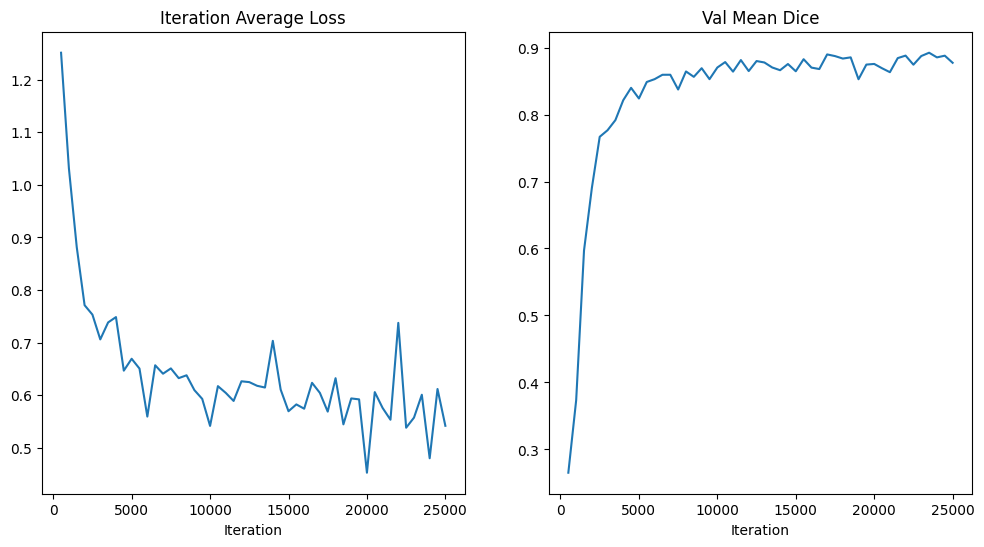

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold0
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]


In [6]:
# # slice_map = {
# #     "img0035.nii.gz": 170,
# #     "img0036.nii.gz": 230,
# #     "img0037.nii.gz": 204,
# #     "img0038.nii.gz": 204,
# #     "img0039.nii.gz": 204,
# #     "img0040.nii.gz": 180,
# # }
# slice_map = {
#     "img0029.nii.gz": 90,
#     "img0030.nii.gz": 230,
#     "img0031.nii.gz": 204,
#     "img0032.nii.gz": 204,
#     "img0033.nii.gz": 204,
#     "img0034.nii.gz": 180,
# }
# case_num = 0
# img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
# img = val_ds[case_num]["image"]
# label = val_ds[case_num]["label"]
# img_shape = img.shape
# label_shape = label.shape
# print(f"image shape: {img_shape}, label shape: {label_shape}")
# plt.figure("image", (18, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("label")
# plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
# plt.show()

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [7]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1", "swinunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold0_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [10]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold0_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=0.60593): 100%|█| 24/24 [00:23<00:00,  1.01it/
Training (47 / 25000 Steps) (loss=0.67990): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (71 / 25000 Steps) (loss=0.91814): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (95 / 25000 Steps) (loss=0.89298): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (119 / 25000 Steps) (loss=0.84448): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (143 / 25000 Steps) (loss=0.75040): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (167 / 25000 Steps) (loss=0.79806): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (191 / 25000 Steps) (loss=0.51149): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (215 / 25000 Steps) (loss=0.63818): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (239 / 25000 Steps) (loss=0.82062): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (263 / 25000 Steps) (loss=0.75871): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (287 / 25000 Steps) (loss=0.85271): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.8369329571723938 Current Avg. Dice: 0.8369329571723938


Training (503 / 25000 Steps) (loss=0.57011): 100%|█| 24/24 [00:36<00:00,  1.51s/
Training (527 / 25000 Steps) (loss=0.86295): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (551 / 25000 Steps) (loss=0.66562): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (575 / 25000 Steps) (loss=0.73112): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (599 / 25000 Steps) (loss=0.81646): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (623 / 25000 Steps) (loss=0.74324): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (647 / 25000 Steps) (loss=0.91320): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (671 / 25000 Steps) (loss=0.66580): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (695 / 25000 Steps) (loss=0.85988): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (719 / 25000 Steps) (loss=0.54500): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (743 / 25000 Steps) (loss=0.87064): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (767 / 25000 Steps) (loss=0.61078): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8865591883659363


Training (1007 / 25000 Steps) (loss=0.70983): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (1031 / 25000 Steps) (loss=0.99834): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1055 / 25000 Steps) (loss=0.66407): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1079 / 25000 Steps) (loss=0.52359): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1103 / 25000 Steps) (loss=0.64340): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1127 / 25000 Steps) (loss=0.84997): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1151 / 25000 Steps) (loss=1.11480): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1175 / 25000 Steps) (loss=0.78958): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1199 / 25000 Steps) (loss=0.59469): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1223 / 25000 Steps) (loss=0.72699): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1247 / 25000 Steps) (loss=0.76334): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1271 / 25000 Steps) (loss=0.60558): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8827300071716309


Training (1511 / 25000 Steps) (loss=0.72342): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (1535 / 25000 Steps) (loss=0.77628): 100%|█| 24/24 [00:19<00:00,  1.26i
Training (1559 / 25000 Steps) (loss=0.44442): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1583 / 25000 Steps) (loss=0.81586): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1607 / 25000 Steps) (loss=0.54667): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1631 / 25000 Steps) (loss=0.82865): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1655 / 25000 Steps) (loss=0.88964): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1679 / 25000 Steps) (loss=0.58785): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1703 / 25000 Steps) (loss=0.75637): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1727 / 25000 Steps) (loss=0.95143): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1751 / 25000 Steps) (loss=0.78859): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1775 / 25000 Steps) (loss=0.80920): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8785211443901062


Training (2015 / 25000 Steps) (loss=0.75473): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (2039 / 25000 Steps) (loss=0.81613): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2063 / 25000 Steps) (loss=1.13972): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2087 / 25000 Steps) (loss=0.60747): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2111 / 25000 Steps) (loss=0.66389): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2135 / 25000 Steps) (loss=0.92787): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2159 / 25000 Steps) (loss=0.76281): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2183 / 25000 Steps) (loss=0.64792): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2207 / 25000 Steps) (loss=1.10238): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2231 / 25000 Steps) (loss=0.51824): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2255 / 25000 Steps) (loss=0.51917): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2279 / 25000 Steps) (loss=0.71229): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8754735589027405


Training (2519 / 25000 Steps) (loss=0.67389): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (2543 / 25000 Steps) (loss=0.66158): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2567 / 25000 Steps) (loss=1.11124): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2591 / 25000 Steps) (loss=0.74947): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2615 / 25000 Steps) (loss=0.48417): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2639 / 25000 Steps) (loss=0.65683): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2663 / 25000 Steps) (loss=0.87663): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2687 / 25000 Steps) (loss=0.68477): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2711 / 25000 Steps) (loss=0.93034): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2735 / 25000 Steps) (loss=0.69953): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2759 / 25000 Steps) (loss=0.58731): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2783 / 25000 Steps) (loss=0.58354): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8609126210212708


Training (3023 / 25000 Steps) (loss=0.65729): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (3047 / 25000 Steps) (loss=0.78025): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3071 / 25000 Steps) (loss=0.82477): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3095 / 25000 Steps) (loss=0.71959): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3119 / 25000 Steps) (loss=0.66765): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3143 / 25000 Steps) (loss=0.71969): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3167 / 25000 Steps) (loss=0.61341): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3191 / 25000 Steps) (loss=0.75499): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3215 / 25000 Steps) (loss=0.63298): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3239 / 25000 Steps) (loss=0.69534): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3263 / 25000 Steps) (loss=0.71415): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3287 / 25000 Steps) (loss=0.76067): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8678944706916809


Training (3503 / 25000 Steps) (loss=0.65989): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (3527 / 25000 Steps) (loss=0.73892): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3551 / 25000 Steps) (loss=0.68049): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3575 / 25000 Steps) (loss=0.56186): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3599 / 25000 Steps) (loss=0.79165): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3623 / 25000 Steps) (loss=0.82794): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3647 / 25000 Steps) (loss=0.74126): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3671 / 25000 Steps) (loss=0.53033): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3695 / 25000 Steps) (loss=0.90781): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3719 / 25000 Steps) (loss=0.90265): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3743 / 25000 Steps) (loss=0.71343): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3767 / 25000 Steps) (loss=0.89356): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8516338467597961


Training (4007 / 25000 Steps) (loss=0.71414): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (4031 / 25000 Steps) (loss=0.70701): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4055 / 25000 Steps) (loss=0.56992): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4079 / 25000 Steps) (loss=0.77891): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4103 / 25000 Steps) (loss=0.63589): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4127 / 25000 Steps) (loss=1.06865): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4151 / 25000 Steps) (loss=0.73522): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4175 / 25000 Steps) (loss=0.84023): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4199 / 25000 Steps) (loss=0.87819): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4223 / 25000 Steps) (loss=0.76839): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4247 / 25000 Steps) (loss=0.43341): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4271 / 25000 Steps) (loss=0.68323): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8644461631774902


Training (4511 / 25000 Steps) (loss=0.68362): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (4535 / 25000 Steps) (loss=0.52967): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4559 / 25000 Steps) (loss=0.74161): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4583 / 25000 Steps) (loss=0.76525): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4607 / 25000 Steps) (loss=1.49939): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4631 / 25000 Steps) (loss=0.70757): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4655 / 25000 Steps) (loss=0.59425): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4679 / 25000 Steps) (loss=1.12617): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4703 / 25000 Steps) (loss=0.66149): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4727 / 25000 Steps) (loss=2.07120): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4751 / 25000 Steps) (loss=0.67113): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4775 / 25000 Steps) (loss=0.75685): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8797305226325989


Training (5015 / 25000 Steps) (loss=0.78810): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (5039 / 25000 Steps) (loss=0.76766): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5063 / 25000 Steps) (loss=0.67447): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5087 / 25000 Steps) (loss=0.64154): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5111 / 25000 Steps) (loss=0.50723): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5135 / 25000 Steps) (loss=0.84644): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5159 / 25000 Steps) (loss=0.67356): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5183 / 25000 Steps) (loss=0.99872): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5207 / 25000 Steps) (loss=0.67665): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5231 / 25000 Steps) (loss=1.65008): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5255 / 25000 Steps) (loss=0.64008): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5279 / 25000 Steps) (loss=0.92923): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8758883476257324


Training (5519 / 25000 Steps) (loss=1.25410): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (5543 / 25000 Steps) (loss=0.72018): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5567 / 25000 Steps) (loss=0.68116): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5591 / 25000 Steps) (loss=0.64519): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5615 / 25000 Steps) (loss=0.69410): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5639 / 25000 Steps) (loss=0.84899): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5663 / 25000 Steps) (loss=0.48564): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5687 / 25000 Steps) (loss=0.50180): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5711 / 25000 Steps) (loss=0.83918): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5735 / 25000 Steps) (loss=0.70613): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5759 / 25000 Steps) (loss=0.61994): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5783 / 25000 Steps) (loss=0.81721): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8603718876838684


Training (6023 / 25000 Steps) (loss=0.83010): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (6047 / 25000 Steps) (loss=0.56118): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6071 / 25000 Steps) (loss=0.51584): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6095 / 25000 Steps) (loss=0.77998): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6119 / 25000 Steps) (loss=0.67656): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6143 / 25000 Steps) (loss=0.87917): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6167 / 25000 Steps) (loss=0.49643): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6191 / 25000 Steps) (loss=0.93763): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6215 / 25000 Steps) (loss=0.57759): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6239 / 25000 Steps) (loss=0.70407): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6263 / 25000 Steps) (loss=0.86490): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6287 / 25000 Steps) (loss=0.64062): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8365376591682434


Training (6503 / 25000 Steps) (loss=0.75726): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (6527 / 25000 Steps) (loss=0.75523): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6551 / 25000 Steps) (loss=0.44552): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6575 / 25000 Steps) (loss=0.57229): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6599 / 25000 Steps) (loss=0.72028): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6623 / 25000 Steps) (loss=0.56669): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6647 / 25000 Steps) (loss=0.78606): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6671 / 25000 Steps) (loss=0.69169): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6695 / 25000 Steps) (loss=0.74985): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6719 / 25000 Steps) (loss=0.64891): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6743 / 25000 Steps) (loss=0.92643): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6767 / 25000 Steps) (loss=0.70385): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8510977625846863


Training (7007 / 25000 Steps) (loss=2.02690): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (7031 / 25000 Steps) (loss=0.60303): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7055 / 25000 Steps) (loss=0.74937): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7079 / 25000 Steps) (loss=1.16660): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7103 / 25000 Steps) (loss=0.82317): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7127 / 25000 Steps) (loss=0.61813): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7151 / 25000 Steps) (loss=0.69580): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7175 / 25000 Steps) (loss=0.68967): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7199 / 25000 Steps) (loss=0.66573): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7223 / 25000 Steps) (loss=0.79221): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7247 / 25000 Steps) (loss=0.55436): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7271 / 25000 Steps) (loss=0.64119): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8524317741394043


Training (7511 / 25000 Steps) (loss=0.69584): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (7535 / 25000 Steps) (loss=1.29142): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7559 / 25000 Steps) (loss=0.93096): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7583 / 25000 Steps) (loss=0.64514): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7607 / 25000 Steps) (loss=1.02481): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7631 / 25000 Steps) (loss=1.00612): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7655 / 25000 Steps) (loss=0.73590): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7679 / 25000 Steps) (loss=0.60172): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7703 / 25000 Steps) (loss=0.57951): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7727 / 25000 Steps) (loss=1.00647): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7751 / 25000 Steps) (loss=0.47320): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7775 / 25000 Steps) (loss=0.68328): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8615402579307556


Training (8015 / 25000 Steps) (loss=0.67575): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (8039 / 25000 Steps) (loss=0.79810): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8063 / 25000 Steps) (loss=0.80675): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8087 / 25000 Steps) (loss=0.58307): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8111 / 25000 Steps) (loss=0.84472): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8135 / 25000 Steps) (loss=0.61452): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8159 / 25000 Steps) (loss=0.78704): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8183 / 25000 Steps) (loss=0.62388): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8207 / 25000 Steps) (loss=0.67401): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8231 / 25000 Steps) (loss=0.74743): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8255 / 25000 Steps) (loss=0.57965): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8279 / 25000 Steps) (loss=0.79744): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8686182498931885


Training (8519 / 25000 Steps) (loss=0.74736): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (8543 / 25000 Steps) (loss=0.92080): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8567 / 25000 Steps) (loss=0.76057): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8591 / 25000 Steps) (loss=0.72001): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8615 / 25000 Steps) (loss=0.61032): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8639 / 25000 Steps) (loss=0.51591): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8663 / 25000 Steps) (loss=0.76213): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8687 / 25000 Steps) (loss=0.87992): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8711 / 25000 Steps) (loss=0.65918): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8735 / 25000 Steps) (loss=0.75840): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8759 / 25000 Steps) (loss=0.74132): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8783 / 25000 Steps) (loss=0.66154): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.861335277557373


Training (9023 / 25000 Steps) (loss=0.68438): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (9047 / 25000 Steps) (loss=0.96090): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9071 / 25000 Steps) (loss=0.51164): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9095 / 25000 Steps) (loss=1.03796): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9119 / 25000 Steps) (loss=0.64096): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9143 / 25000 Steps) (loss=0.65047): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9167 / 25000 Steps) (loss=0.54980): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9191 / 25000 Steps) (loss=0.52970): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9215 / 25000 Steps) (loss=0.67936): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9239 / 25000 Steps) (loss=0.49055): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9263 / 25000 Steps) (loss=1.17672): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9287 / 25000 Steps) (loss=0.56058): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8737409710884094


Training (9503 / 25000 Steps) (loss=1.22126): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (9527 / 25000 Steps) (loss=0.59787): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9551 / 25000 Steps) (loss=0.75036): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9575 / 25000 Steps) (loss=0.73134): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9599 / 25000 Steps) (loss=0.66196): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9623 / 25000 Steps) (loss=0.59980): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9647 / 25000 Steps) (loss=0.81849): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9671 / 25000 Steps) (loss=0.65622): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9695 / 25000 Steps) (loss=0.88471): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9719 / 25000 Steps) (loss=0.77975): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9743 / 25000 Steps) (loss=0.74640): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9767 / 25000 Steps) (loss=0.50177): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8829215168952942


Training (10007 / 25000 Steps) (loss=1.02999): 100%|█| 24/24 [00:35<00:00,  1.47
Training (10031 / 25000 Steps) (loss=1.45274): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10055 / 25000 Steps) (loss=0.69643): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10079 / 25000 Steps) (loss=0.49263): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10103 / 25000 Steps) (loss=0.48960): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10127 / 25000 Steps) (loss=1.15759): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10151 / 25000 Steps) (loss=0.68704): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10175 / 25000 Steps) (loss=0.42993): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10199 / 25000 Steps) (loss=0.62652): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10223 / 25000 Steps) (loss=0.73864): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10247 / 25000 Steps) (loss=0.74132): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10271 / 25000 Steps) (loss=0.53649): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8749056458473206


Training (10511 / 25000 Steps) (loss=0.75074): 100%|█| 24/24 [00:35<00:00,  1.48
Training (10535 / 25000 Steps) (loss=0.81448): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10559 / 25000 Steps) (loss=0.97715): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10583 / 25000 Steps) (loss=0.68982): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10607 / 25000 Steps) (loss=0.66665): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10631 / 25000 Steps) (loss=0.57988): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10655 / 25000 Steps) (loss=0.89414): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10679 / 25000 Steps) (loss=0.70851): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10703 / 25000 Steps) (loss=0.69767): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10727 / 25000 Steps) (loss=0.66566): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10751 / 25000 Steps) (loss=0.59839): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10775 / 25000 Steps) (loss=0.51465): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8573628067970276


Training (11015 / 25000 Steps) (loss=0.79197): 100%|█| 24/24 [00:35<00:00,  1.48
Training (11039 / 25000 Steps) (loss=0.81298): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11063 / 25000 Steps) (loss=0.59534): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11087 / 25000 Steps) (loss=0.69775): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11111 / 25000 Steps) (loss=0.55694): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11135 / 25000 Steps) (loss=0.60550): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11159 / 25000 Steps) (loss=0.89744): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11183 / 25000 Steps) (loss=0.72353): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11207 / 25000 Steps) (loss=0.88880): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11231 / 25000 Steps) (loss=0.67039): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11255 / 25000 Steps) (loss=0.58885): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11279 / 25000 Steps) (loss=0.80483): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8631901741027832


Training (11519 / 25000 Steps) (loss=0.65003): 100%|█| 24/24 [00:35<00:00,  1.48
Training (11543 / 25000 Steps) (loss=0.87689): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11567 / 25000 Steps) (loss=0.72555): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11591 / 25000 Steps) (loss=1.02786): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11615 / 25000 Steps) (loss=0.48887): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11639 / 25000 Steps) (loss=0.68312): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11663 / 25000 Steps) (loss=0.79458): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11687 / 25000 Steps) (loss=0.84934): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11711 / 25000 Steps) (loss=0.75430): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11735 / 25000 Steps) (loss=0.67343): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11759 / 25000 Steps) (loss=0.73941): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11783 / 25000 Steps) (loss=0.57276): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.860154926776886


Training (12023 / 25000 Steps) (loss=0.88036): 100%|█| 24/24 [00:35<00:00,  1.47
Training (12047 / 25000 Steps) (loss=0.68105): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12071 / 25000 Steps) (loss=1.94222): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12095 / 25000 Steps) (loss=0.47737): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12119 / 25000 Steps) (loss=0.73782): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12143 / 25000 Steps) (loss=0.87672): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12167 / 25000 Steps) (loss=0.59581): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12191 / 25000 Steps) (loss=0.56977): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12215 / 25000 Steps) (loss=0.77070): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12239 / 25000 Steps) (loss=0.81385): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12263 / 25000 Steps) (loss=0.58761): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12287 / 25000 Steps) (loss=1.14162): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8395974040031433


Training (12503 / 25000 Steps) (loss=0.82697): 100%|█| 24/24 [00:35<00:00,  1.47
Training (12527 / 25000 Steps) (loss=0.56223): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12551 / 25000 Steps) (loss=1.18064): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12575 / 25000 Steps) (loss=1.65529): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12599 / 25000 Steps) (loss=0.47706): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12623 / 25000 Steps) (loss=0.56586): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12647 / 25000 Steps) (loss=0.79220): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12671 / 25000 Steps) (loss=0.82142): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12695 / 25000 Steps) (loss=0.63425): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12719 / 25000 Steps) (loss=0.72443): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12743 / 25000 Steps) (loss=0.80383): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12767 / 25000 Steps) (loss=0.76899): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8635309338569641


Training (13007 / 25000 Steps) (loss=0.72894): 100%|█| 24/24 [00:35<00:00,  1.48
Training (13031 / 25000 Steps) (loss=0.95531): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13055 / 25000 Steps) (loss=0.59444): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13079 / 25000 Steps) (loss=0.56971): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13103 / 25000 Steps) (loss=0.65260): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13127 / 25000 Steps) (loss=0.66715): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13151 / 25000 Steps) (loss=0.75246): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13175 / 25000 Steps) (loss=0.63850): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13199 / 25000 Steps) (loss=0.82090): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13223 / 25000 Steps) (loss=0.38129): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13247 / 25000 Steps) (loss=0.68846): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13271 / 25000 Steps) (loss=0.77729): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8865591883659363 Current Avg. Dice: 0.8674755692481995


Training (13511 / 25000 Steps) (loss=0.67266): 100%|█| 24/24 [00:35<00:00,  1.48
Training (13535 / 25000 Steps) (loss=0.68471): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13559 / 25000 Steps) (loss=0.71791): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13583 / 25000 Steps) (loss=0.58173): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13607 / 25000 Steps) (loss=0.61753): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13631 / 25000 Steps) (loss=0.50920): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13655 / 25000 Steps) (loss=0.72801): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13679 / 25000 Steps) (loss=0.97304): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13703 / 25000 Steps) (loss=0.62663): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13727 / 25000 Steps) (loss=1.08807): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13751 / 25000 Steps) (loss=0.74746): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13775 / 25000 Steps) (loss=0.99710): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.886897087097168


Training (14015 / 25000 Steps) (loss=0.68123): 100%|█| 24/24 [00:35<00:00,  1.49
Training (14039 / 25000 Steps) (loss=0.71098): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14063 / 25000 Steps) (loss=0.42013): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14087 / 25000 Steps) (loss=0.64804): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14111 / 25000 Steps) (loss=0.73553): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14135 / 25000 Steps) (loss=0.62931): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14159 / 25000 Steps) (loss=0.76924): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14183 / 25000 Steps) (loss=1.95666): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14207 / 25000 Steps) (loss=0.86581): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14231 / 25000 Steps) (loss=0.87144): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14255 / 25000 Steps) (loss=0.75726): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14279 / 25000 Steps) (loss=1.00023): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8811109662055969


Training (14519 / 25000 Steps) (loss=1.26027): 100%|█| 24/24 [00:35<00:00,  1.48
Training (14543 / 25000 Steps) (loss=0.68070): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14567 / 25000 Steps) (loss=0.64545): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14591 / 25000 Steps) (loss=0.73276): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14615 / 25000 Steps) (loss=0.71001): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14639 / 25000 Steps) (loss=0.51087): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14663 / 25000 Steps) (loss=0.57282): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14687 / 25000 Steps) (loss=0.91077): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14711 / 25000 Steps) (loss=0.70167): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14735 / 25000 Steps) (loss=0.65564): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14759 / 25000 Steps) (loss=0.62035): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14783 / 25000 Steps) (loss=0.55308): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8614022731781006


Training (15023 / 25000 Steps) (loss=0.59814): 100%|█| 24/24 [00:35<00:00,  1.47
Training (15047 / 25000 Steps) (loss=0.73744): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15071 / 25000 Steps) (loss=0.72636): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15095 / 25000 Steps) (loss=0.54139): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15119 / 25000 Steps) (loss=0.60781): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15143 / 25000 Steps) (loss=0.71329): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15167 / 25000 Steps) (loss=0.87918): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15191 / 25000 Steps) (loss=0.64829): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15215 / 25000 Steps) (loss=0.65368): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15239 / 25000 Steps) (loss=0.76624): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15263 / 25000 Steps) (loss=0.83275): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15287 / 25000 Steps) (loss=0.80282): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8638861179351807


Training (15503 / 25000 Steps) (loss=0.87698): 100%|█| 24/24 [00:35<00:00,  1.48
Training (15527 / 25000 Steps) (loss=0.95179): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15551 / 25000 Steps) (loss=0.65050): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15575 / 25000 Steps) (loss=0.76488): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15599 / 25000 Steps) (loss=0.67646): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15623 / 25000 Steps) (loss=0.81601): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15647 / 25000 Steps) (loss=0.60735): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15671 / 25000 Steps) (loss=0.76300): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15695 / 25000 Steps) (loss=0.66745): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15719 / 25000 Steps) (loss=0.76476): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15743 / 25000 Steps) (loss=0.85547): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15767 / 25000 Steps) (loss=1.15311): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8587093353271484


Training (16007 / 25000 Steps) (loss=1.29360): 100%|█| 24/24 [00:35<00:00,  1.48
Training (16031 / 25000 Steps) (loss=0.85617): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16055 / 25000 Steps) (loss=0.80457): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16079 / 25000 Steps) (loss=0.70395): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16103 / 25000 Steps) (loss=0.87715): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16127 / 25000 Steps) (loss=0.66056): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16151 / 25000 Steps) (loss=0.68275): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16175 / 25000 Steps) (loss=0.84133): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16199 / 25000 Steps) (loss=0.79650): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16223 / 25000 Steps) (loss=1.52190): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16247 / 25000 Steps) (loss=0.64278): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16271 / 25000 Steps) (loss=0.79939): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8800821900367737


Training (16511 / 25000 Steps) (loss=0.56520): 100%|█| 24/24 [00:35<00:00,  1.48
Training (16535 / 25000 Steps) (loss=0.77945): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16559 / 25000 Steps) (loss=1.49905): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16583 / 25000 Steps) (loss=0.68005): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16607 / 25000 Steps) (loss=0.52954): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16631 / 25000 Steps) (loss=0.67137): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16655 / 25000 Steps) (loss=1.87803): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16679 / 25000 Steps) (loss=0.58264): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16703 / 25000 Steps) (loss=0.79740): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16727 / 25000 Steps) (loss=0.86025): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16751 / 25000 Steps) (loss=1.08927): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16775 / 25000 Steps) (loss=0.79823): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8862497806549072


Training (17015 / 25000 Steps) (loss=0.45113): 100%|█| 24/24 [00:35<00:00,  1.48
Training (17039 / 25000 Steps) (loss=0.79631): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17063 / 25000 Steps) (loss=0.76792): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17087 / 25000 Steps) (loss=0.48091): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17111 / 25000 Steps) (loss=0.76002): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17135 / 25000 Steps) (loss=0.72501): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17159 / 25000 Steps) (loss=0.79967): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17183 / 25000 Steps) (loss=0.77711): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17207 / 25000 Steps) (loss=0.70323): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17231 / 25000 Steps) (loss=0.54180): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17255 / 25000 Steps) (loss=0.58138): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17279 / 25000 Steps) (loss=0.54239): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.87445467710495


Training (17519 / 25000 Steps) (loss=0.87512): 100%|█| 24/24 [00:35<00:00,  1.48
Training (17543 / 25000 Steps) (loss=0.71578): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17567 / 25000 Steps) (loss=0.60652): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17591 / 25000 Steps) (loss=0.69514): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17615 / 25000 Steps) (loss=0.58581): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17639 / 25000 Steps) (loss=0.67701): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17663 / 25000 Steps) (loss=0.83458): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17687 / 25000 Steps) (loss=0.61781): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17711 / 25000 Steps) (loss=0.86763): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17735 / 25000 Steps) (loss=0.43746): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17759 / 25000 Steps) (loss=0.69624): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17783 / 25000 Steps) (loss=0.82747): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.85970538854599


Training (18023 / 25000 Steps) (loss=0.77803): 100%|█| 24/24 [00:35<00:00,  1.48
Training (18047 / 25000 Steps) (loss=0.74777): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18071 / 25000 Steps) (loss=0.70524): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18095 / 25000 Steps) (loss=0.72147): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18119 / 25000 Steps) (loss=0.95656): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18143 / 25000 Steps) (loss=0.60411): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18167 / 25000 Steps) (loss=0.74933): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18191 / 25000 Steps) (loss=0.75926): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18215 / 25000 Steps) (loss=0.66028): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18239 / 25000 Steps) (loss=0.68874): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18263 / 25000 Steps) (loss=1.04597): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18287 / 25000 Steps) (loss=0.67609): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8859699368476868


Training (18503 / 25000 Steps) (loss=0.88964): 100%|█| 24/24 [00:35<00:00,  1.48
Training (18527 / 25000 Steps) (loss=0.93764): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18551 / 25000 Steps) (loss=0.95328): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18575 / 25000 Steps) (loss=0.59300): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18599 / 25000 Steps) (loss=0.73490): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18623 / 25000 Steps) (loss=0.88602): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18647 / 25000 Steps) (loss=0.67807): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18671 / 25000 Steps) (loss=0.52775): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18695 / 25000 Steps) (loss=0.71481): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18719 / 25000 Steps) (loss=0.58164): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18743 / 25000 Steps) (loss=0.53402): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18767 / 25000 Steps) (loss=0.79413): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8665590286254883


Training (19007 / 25000 Steps) (loss=0.81330): 100%|█| 24/24 [00:35<00:00,  1.48
Training (19031 / 25000 Steps) (loss=0.60109): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19055 / 25000 Steps) (loss=0.64317): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19079 / 25000 Steps) (loss=0.61147): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19103 / 25000 Steps) (loss=0.66733): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19127 / 25000 Steps) (loss=0.68112): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19151 / 25000 Steps) (loss=0.65797): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19175 / 25000 Steps) (loss=0.81964): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19199 / 25000 Steps) (loss=0.79460): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19223 / 25000 Steps) (loss=0.78959): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19247 / 25000 Steps) (loss=0.70035): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19271 / 25000 Steps) (loss=0.69959): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8858566284179688


Training (19511 / 25000 Steps) (loss=1.19932): 100%|█| 24/24 [00:35<00:00,  1.48
Training (19535 / 25000 Steps) (loss=0.69456): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19559 / 25000 Steps) (loss=0.68450): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19583 / 25000 Steps) (loss=0.66076): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19607 / 25000 Steps) (loss=0.59023): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19631 / 25000 Steps) (loss=0.79590): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19655 / 25000 Steps) (loss=0.70185): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19679 / 25000 Steps) (loss=0.67680): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19703 / 25000 Steps) (loss=0.92057): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19727 / 25000 Steps) (loss=0.62654): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19751 / 25000 Steps) (loss=0.76389): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19775 / 25000 Steps) (loss=0.84828): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8788142204284668


Training (20015 / 25000 Steps) (loss=0.51401): 100%|█| 24/24 [00:35<00:00,  1.48
Training (20039 / 25000 Steps) (loss=1.82178): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20063 / 25000 Steps) (loss=0.57565): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20087 / 25000 Steps) (loss=0.66488): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20111 / 25000 Steps) (loss=0.78972): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20135 / 25000 Steps) (loss=1.20252): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20159 / 25000 Steps) (loss=0.80652): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20183 / 25000 Steps) (loss=0.58485): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20207 / 25000 Steps) (loss=0.73951): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20231 / 25000 Steps) (loss=0.58598): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20255 / 25000 Steps) (loss=1.01937): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20279 / 25000 Steps) (loss=0.69566): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8693263530731201


Training (20519 / 25000 Steps) (loss=0.63761): 100%|█| 24/24 [00:35<00:00,  1.47
Training (20543 / 25000 Steps) (loss=0.81672): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20567 / 25000 Steps) (loss=0.90377): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20591 / 25000 Steps) (loss=0.76713): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20615 / 25000 Steps) (loss=0.85727): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20639 / 25000 Steps) (loss=0.52609): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20663 / 25000 Steps) (loss=0.78596): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20687 / 25000 Steps) (loss=0.65904): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20711 / 25000 Steps) (loss=2.06774): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20735 / 25000 Steps) (loss=0.74083): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20759 / 25000 Steps) (loss=0.92193): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20783 / 25000 Steps) (loss=0.60965): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8628103733062744


Training (21023 / 25000 Steps) (loss=0.80958): 100%|█| 24/24 [00:35<00:00,  1.48
Training (21047 / 25000 Steps) (loss=0.72418): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21071 / 25000 Steps) (loss=0.69078): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21095 / 25000 Steps) (loss=1.43004): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21119 / 25000 Steps) (loss=0.55989): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21143 / 25000 Steps) (loss=0.72142): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21167 / 25000 Steps) (loss=0.84395): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21191 / 25000 Steps) (loss=0.67901): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21215 / 25000 Steps) (loss=0.54922): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21239 / 25000 Steps) (loss=0.57539): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21263 / 25000 Steps) (loss=0.76287): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21287 / 25000 Steps) (loss=0.74463): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8829308152198792


Training (21503 / 25000 Steps) (loss=0.81354): 100%|█| 24/24 [00:35<00:00,  1.47
Training (21527 / 25000 Steps) (loss=0.69581): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21551 / 25000 Steps) (loss=0.68810): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21575 / 25000 Steps) (loss=0.59661): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21599 / 25000 Steps) (loss=0.59833): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21623 / 25000 Steps) (loss=0.79801): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21647 / 25000 Steps) (loss=0.79632): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21671 / 25000 Steps) (loss=0.63643): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21695 / 25000 Steps) (loss=0.64408): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21719 / 25000 Steps) (loss=0.72833): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21743 / 25000 Steps) (loss=0.55347): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21767 / 25000 Steps) (loss=0.48201): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.886897087097168 Current Avg. Dice: 0.8731600642204285


Training (22007 / 25000 Steps) (loss=0.57689): 100%|█| 24/24 [00:35<00:00,  1.48
Training (22031 / 25000 Steps) (loss=0.45097): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22055 / 25000 Steps) (loss=0.61666): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22079 / 25000 Steps) (loss=0.97297): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22103 / 25000 Steps) (loss=0.79758): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22127 / 25000 Steps) (loss=1.02468): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22151 / 25000 Steps) (loss=0.68525): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22175 / 25000 Steps) (loss=0.75362): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22199 / 25000 Steps) (loss=0.52865): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22223 / 25000 Steps) (loss=0.82518): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22247 / 25000 Steps) (loss=0.87946): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22271 / 25000 Steps) (loss=1.13623): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8875357508659363 Current Avg. Dice: 0.8875357508659363


Training (22511 / 25000 Steps) (loss=0.84463): 100%|█| 24/24 [00:35<00:00,  1.49
Training (22535 / 25000 Steps) (loss=0.74088): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22559 / 25000 Steps) (loss=0.60542): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22583 / 25000 Steps) (loss=0.53213): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22607 / 25000 Steps) (loss=0.79214): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22631 / 25000 Steps) (loss=0.73754): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22655 / 25000 Steps) (loss=0.60719): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22679 / 25000 Steps) (loss=0.74045): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22703 / 25000 Steps) (loss=0.64816): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22727 / 25000 Steps) (loss=0.81205): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22751 / 25000 Steps) (loss=1.38340): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22775 / 25000 Steps) (loss=0.74363): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8875357508659363 Current Avg. Dice: 0.87845379114151


Training (23015 / 25000 Steps) (loss=0.98977): 100%|█| 24/24 [00:35<00:00,  1.48
Training (23039 / 25000 Steps) (loss=0.88220): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23063 / 25000 Steps) (loss=0.80439): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23087 / 25000 Steps) (loss=0.61956): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23111 / 25000 Steps) (loss=0.59574): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23135 / 25000 Steps) (loss=0.68085): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23159 / 25000 Steps) (loss=0.46129): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23183 / 25000 Steps) (loss=0.74923): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23207 / 25000 Steps) (loss=0.55044): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23231 / 25000 Steps) (loss=0.88242): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23255 / 25000 Steps) (loss=0.77071): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23279 / 25000 Steps) (loss=0.53959): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8875357508659363 Current Avg. Dice: 0.8662694096565247


Training (23519 / 25000 Steps) (loss=0.70445): 100%|█| 24/24 [00:35<00:00,  1.48
Training (23543 / 25000 Steps) (loss=0.67982): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23567 / 25000 Steps) (loss=0.78409): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23591 / 25000 Steps) (loss=0.68444): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23615 / 25000 Steps) (loss=1.00951): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23639 / 25000 Steps) (loss=0.79265): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23663 / 25000 Steps) (loss=0.76773): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23687 / 25000 Steps) (loss=0.71518): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23711 / 25000 Steps) (loss=0.59840): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23735 / 25000 Steps) (loss=0.75467): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23759 / 25000 Steps) (loss=0.58724): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23783 / 25000 Steps) (loss=0.53727): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8875357508659363 Current Avg. Dice: 0.8604275584220886


Training (24023 / 25000 Steps) (loss=0.84206): 100%|█| 24/24 [00:35<00:00,  1.47
Training (24047 / 25000 Steps) (loss=0.82644): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24071 / 25000 Steps) (loss=0.70419): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24095 / 25000 Steps) (loss=0.60139): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24119 / 25000 Steps) (loss=0.81615): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24143 / 25000 Steps) (loss=0.75195): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24167 / 25000 Steps) (loss=0.65231): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24191 / 25000 Steps) (loss=0.69840): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24215 / 25000 Steps) (loss=0.79644): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24239 / 25000 Steps) (loss=0.84088): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24263 / 25000 Steps) (loss=0.77219): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24287 / 25000 Steps) (loss=0.58577): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8875357508659363 Current Avg. Dice: 0.8749372959136963


Training (24503 / 25000 Steps) (loss=1.72084): 100%|█| 24/24 [00:35<00:00,  1.47
Training (24527 / 25000 Steps) (loss=0.45198): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24551 / 25000 Steps) (loss=0.66801): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24575 / 25000 Steps) (loss=0.46330): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24599 / 25000 Steps) (loss=0.70561): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24623 / 25000 Steps) (loss=0.64188): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24647 / 25000 Steps) (loss=1.00695): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24671 / 25000 Steps) (loss=0.90635): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24695 / 25000 Steps) (loss=0.65197): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24719 / 25000 Steps) (loss=0.74638): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24743 / 25000 Steps) (loss=0.47936): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24767 / 25000 Steps) (loss=0.81770): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8875357508659363 Current Avg. Dice: 0.8704281449317932


Training (25007 / 25000 Steps) (loss=0.90318): 100%|█| 24/24 [00:35<00:00,  1.48


<All keys matched successfully>

In [11]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8875 at iteration: 22500


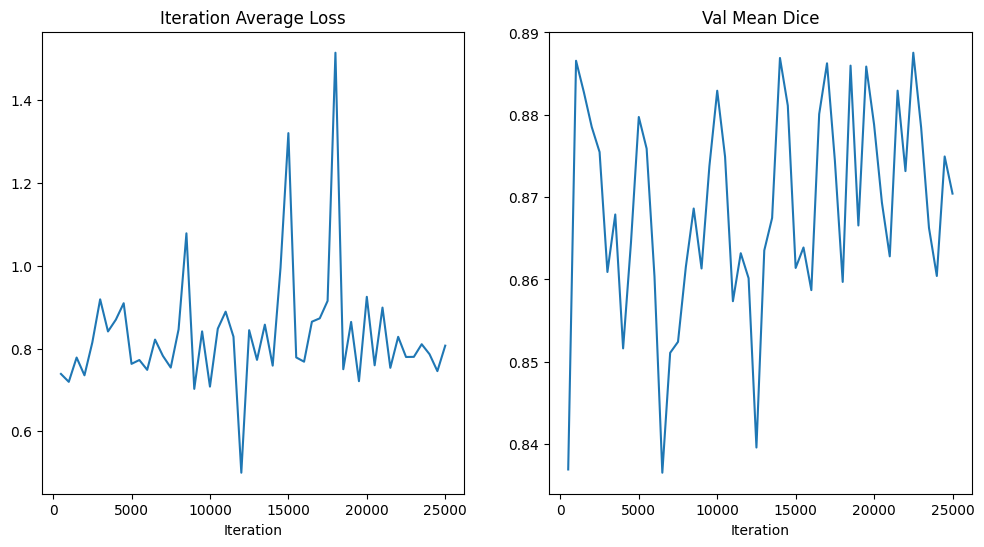

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [13]:
# case_num = 4
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold1_best_metric_model.pth")))
# model.eval()
# with torch.no_grad():
#     img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
#     img = val_ds[case_num]["image"]
#     label = val_ds[case_num]["label"]
#     val_inputs = torch.unsqueeze(img, 1).cuda()
#     val_labels = torch.unsqueeze(label, 1).cuda()
#     val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
#     plt.figure("check", (18, 6))
#     plt.subplot(1, 3, 1)
#     plt.title("image")
#     plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
#     plt.subplot(1, 3, 2)
#     plt.title("label")
#     plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
#     plt.subplot(1, 3, 3)
#     plt.title("output")
#     plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
#     plt.show()

In [14]:
#fold1
torch.cuda.empty_cache()

In [5]:
#fold1
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_1.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.31it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [7]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [8]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1", "swinunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold1_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [9]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold1_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=0.81813): 100%|█| 24/24 [00:23<00:00,  1.02it/
Training (47 / 25000 Steps) (loss=0.68324): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (71 / 25000 Steps) (loss=0.79702): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (95 / 25000 Steps) (loss=0.78100): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (119 / 25000 Steps) (loss=0.74756): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (143 / 25000 Steps) (loss=0.63870): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (167 / 25000 Steps) (loss=0.78138): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (191 / 25000 Steps) (loss=0.67809): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (215 / 25000 Steps) (loss=0.61789): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (239 / 25000 Steps) (loss=0.56346): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (263 / 25000 Steps) (loss=0.66450): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (287 / 25000 Steps) (loss=0.71735): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.8428516983985901 Current Avg. Dice: 0.8428516983985901


Training (503 / 25000 Steps) (loss=0.77586): 100%|█| 24/24 [00:31<00:00,  1.31s/
Training (527 / 25000 Steps) (loss=0.59650): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (551 / 25000 Steps) (loss=0.73208): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (575 / 25000 Steps) (loss=0.75870): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (599 / 25000 Steps) (loss=0.93431): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (623 / 25000 Steps) (loss=0.59835): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (647 / 25000 Steps) (loss=0.77537): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (671 / 25000 Steps) (loss=0.76470): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (695 / 25000 Steps) (loss=0.72031): 100%|█| 24/24 [00:19<00:00,  1.26it
Training (719 / 25000 Steps) (loss=0.75598): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (743 / 25000 Steps) (loss=0.64849): 100%|█| 24/24 [00:18<00:00,  1.26it
Training (767 / 25000 Steps) (loss=1.24355): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.8428516983985901 Current Avg. Dice: 0.8296063542366028


Training (1007 / 25000 Steps) (loss=0.62741): 100%|█| 24/24 [00:31<00:00,  1.29s
Training (1031 / 25000 Steps) (loss=0.86145): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1055 / 25000 Steps) (loss=0.61257): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1079 / 25000 Steps) (loss=0.62113): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1103 / 25000 Steps) (loss=0.74778): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1127 / 25000 Steps) (loss=0.81038): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1151 / 25000 Steps) (loss=0.47402): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1175 / 25000 Steps) (loss=0.79869): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1199 / 25000 Steps) (loss=0.76135): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1223 / 25000 Steps) (loss=0.60361): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1247 / 25000 Steps) (loss=1.12051): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1271 / 25000 Steps) (loss=0.68494): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8428516983985901 Current Avg. Dice: 0.7958877682685852


Training (1511 / 25000 Steps) (loss=0.62949): 100%|█| 24/24 [00:30<00:00,  1.29s
Training (1535 / 25000 Steps) (loss=0.65172): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1559 / 25000 Steps) (loss=1.07075): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1583 / 25000 Steps) (loss=0.61707): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1607 / 25000 Steps) (loss=0.57427): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1631 / 25000 Steps) (loss=0.89959): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1655 / 25000 Steps) (loss=0.79509): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1679 / 25000 Steps) (loss=0.70182): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1703 / 25000 Steps) (loss=0.74018): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1727 / 25000 Steps) (loss=0.85935): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1751 / 25000 Steps) (loss=0.81842): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1775 / 25000 Steps) (loss=0.74794): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8428516983985901 Current Avg. Dice: 0.8247261643409729


Training (2015 / 25000 Steps) (loss=0.74284): 100%|█| 24/24 [00:30<00:00,  1.29s
Training (2039 / 25000 Steps) (loss=0.87833): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2063 / 25000 Steps) (loss=0.74675): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2087 / 25000 Steps) (loss=0.61772): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2111 / 25000 Steps) (loss=0.77463): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2135 / 25000 Steps) (loss=0.73482): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2159 / 25000 Steps) (loss=0.68583): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2183 / 25000 Steps) (loss=0.70636): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2207 / 25000 Steps) (loss=0.55071): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2231 / 25000 Steps) (loss=0.68849): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2255 / 25000 Steps) (loss=0.59399): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2279 / 25000 Steps) (loss=0.53243): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8428516983985901 Current Avg. Dice: 0.8112466335296631


Training (2519 / 25000 Steps) (loss=0.66207): 100%|█| 24/24 [00:30<00:00,  1.29s
Training (2543 / 25000 Steps) (loss=0.73083): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2567 / 25000 Steps) (loss=0.77378): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2591 / 25000 Steps) (loss=0.75048): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2615 / 25000 Steps) (loss=0.66070): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2639 / 25000 Steps) (loss=0.88434): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2663 / 25000 Steps) (loss=0.79147): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2687 / 25000 Steps) (loss=0.79129): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2711 / 25000 Steps) (loss=0.70390): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2735 / 25000 Steps) (loss=0.68688): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2759 / 25000 Steps) (loss=0.77948): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2783 / 25000 Steps) (loss=0.75140): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8428516983985901 Current Avg. Dice: 0.7910103797912598


Training (3023 / 25000 Steps) (loss=0.86128): 100%|█| 24/24 [00:31<00:00,  1.29s
Training (3047 / 25000 Steps) (loss=0.59128): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3071 / 25000 Steps) (loss=0.51509): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3095 / 25000 Steps) (loss=0.75166): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3119 / 25000 Steps) (loss=0.87204): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3143 / 25000 Steps) (loss=0.73879): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3167 / 25000 Steps) (loss=1.62076): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3191 / 25000 Steps) (loss=0.49502): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3215 / 25000 Steps) (loss=0.84958): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3239 / 25000 Steps) (loss=0.54621): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3263 / 25000 Steps) (loss=0.57346): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3287 / 25000 Steps) (loss=1.03828): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8428516983985901 Current Avg. Dice: 0.8367466926574707


Training (3503 / 25000 Steps) (loss=0.86740): 100%|█| 24/24 [00:31<00:00,  1.29s
Training (3527 / 25000 Steps) (loss=1.07151): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3551 / 25000 Steps) (loss=0.61953): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3575 / 25000 Steps) (loss=0.65629): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3599 / 25000 Steps) (loss=0.69241): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3623 / 25000 Steps) (loss=0.63486): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3647 / 25000 Steps) (loss=0.79499): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3671 / 25000 Steps) (loss=0.74686): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3695 / 25000 Steps) (loss=0.72039): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3719 / 25000 Steps) (loss=0.63293): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3743 / 25000 Steps) (loss=1.29630): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3767 / 25000 Steps) (loss=0.81765): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8465970158576965 Current Avg. Dice: 0.8465970158576965


Training (4007 / 25000 Steps) (loss=0.97357): 100%|█| 24/24 [00:31<00:00,  1.31s
Training (4031 / 25000 Steps) (loss=0.54591): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4055 / 25000 Steps) (loss=0.62452): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4079 / 25000 Steps) (loss=0.63209): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4103 / 25000 Steps) (loss=0.87477): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4127 / 25000 Steps) (loss=0.77330): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4151 / 25000 Steps) (loss=0.61556): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4175 / 25000 Steps) (loss=0.62152): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4199 / 25000 Steps) (loss=1.22695): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4223 / 25000 Steps) (loss=0.70333): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4247 / 25000 Steps) (loss=0.81289): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4271 / 25000 Steps) (loss=0.73878): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8465970158576965 Current Avg. Dice: 0.827633798122406


Training (4511 / 25000 Steps) (loss=0.86242): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (4535 / 25000 Steps) (loss=0.80036): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4559 / 25000 Steps) (loss=0.77026): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4583 / 25000 Steps) (loss=0.65524): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4607 / 25000 Steps) (loss=0.51052): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4631 / 25000 Steps) (loss=0.76129): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4655 / 25000 Steps) (loss=0.61210): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4679 / 25000 Steps) (loss=0.82687): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4703 / 25000 Steps) (loss=0.58909): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (4727 / 25000 Steps) (loss=0.76627): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (4751 / 25000 Steps) (loss=0.75568): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4775 / 25000 Steps) (loss=0.90681): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8465970158576965 Current Avg. Dice: 0.8253718018531799


Training (5015 / 25000 Steps) (loss=0.68781): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (5039 / 25000 Steps) (loss=0.88005): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5063 / 25000 Steps) (loss=0.52661): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5087 / 25000 Steps) (loss=0.71104): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5111 / 25000 Steps) (loss=0.69364): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (5135 / 25000 Steps) (loss=0.52680): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5159 / 25000 Steps) (loss=1.36494): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5183 / 25000 Steps) (loss=0.78045): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5207 / 25000 Steps) (loss=0.77170): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5231 / 25000 Steps) (loss=0.77412): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5255 / 25000 Steps) (loss=0.69692): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5279 / 25000 Steps) (loss=0.78783): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8465970158576965 Current Avg. Dice: 0.8010299801826477


Training (5519 / 25000 Steps) (loss=1.05528): 100%|█| 24/24 [00:31<00:00,  1.29s
Training (5543 / 25000 Steps) (loss=0.73096): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5567 / 25000 Steps) (loss=0.59142): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5591 / 25000 Steps) (loss=0.64919): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5615 / 25000 Steps) (loss=0.70253): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5639 / 25000 Steps) (loss=0.70805): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5663 / 25000 Steps) (loss=0.74325): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5687 / 25000 Steps) (loss=0.62486): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5711 / 25000 Steps) (loss=0.79770): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5735 / 25000 Steps) (loss=0.79398): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5759 / 25000 Steps) (loss=0.67390): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5783 / 25000 Steps) (loss=0.61558): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8465970158576965 Current Avg. Dice: 0.7835909724235535


Training (6023 / 25000 Steps) (loss=0.77257): 100%|█| 24/24 [00:31<00:00,  1.29s
Training (6047 / 25000 Steps) (loss=1.69022): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6071 / 25000 Steps) (loss=0.58588): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6095 / 25000 Steps) (loss=1.14278): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6119 / 25000 Steps) (loss=0.74016): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6143 / 25000 Steps) (loss=0.79459): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6167 / 25000 Steps) (loss=0.71874): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6191 / 25000 Steps) (loss=0.80856): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6215 / 25000 Steps) (loss=0.68957): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6239 / 25000 Steps) (loss=0.62510): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6263 / 25000 Steps) (loss=0.57031): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6287 / 25000 Steps) (loss=0.70316): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8465970158576965 Current Avg. Dice: 0.8431393504142761


Training (6503 / 25000 Steps) (loss=0.77446): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (6527 / 25000 Steps) (loss=0.42394): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6551 / 25000 Steps) (loss=0.54780): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (6575 / 25000 Steps) (loss=0.67196): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6599 / 25000 Steps) (loss=0.69645): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6623 / 25000 Steps) (loss=0.64559): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6647 / 25000 Steps) (loss=0.58655): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6671 / 25000 Steps) (loss=0.82789): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6695 / 25000 Steps) (loss=0.69233): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6719 / 25000 Steps) (loss=0.86361): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6743 / 25000 Steps) (loss=0.59132): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6767 / 25000 Steps) (loss=0.84240): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8465970158576965 Current Avg. Dice: 0.8361673355102539


Training (7007 / 25000 Steps) (loss=0.95470): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (7031 / 25000 Steps) (loss=0.79967): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7055 / 25000 Steps) (loss=0.48109): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7079 / 25000 Steps) (loss=0.48279): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7103 / 25000 Steps) (loss=0.67525): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7127 / 25000 Steps) (loss=0.64833): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7151 / 25000 Steps) (loss=0.76271): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7175 / 25000 Steps) (loss=0.74828): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7199 / 25000 Steps) (loss=0.65678): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7223 / 25000 Steps) (loss=0.58591): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (7247 / 25000 Steps) (loss=0.77718): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7271 / 25000 Steps) (loss=0.64238): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8465970158576965 Current Avg. Dice: 0.8407705426216125


Training (7511 / 25000 Steps) (loss=0.80838): 100%|█| 24/24 [00:31<00:00,  1.31s
Training (7535 / 25000 Steps) (loss=0.58283): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7559 / 25000 Steps) (loss=0.92035): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7583 / 25000 Steps) (loss=0.68231): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7607 / 25000 Steps) (loss=0.71406): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7631 / 25000 Steps) (loss=0.72633): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (7655 / 25000 Steps) (loss=0.70718): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7679 / 25000 Steps) (loss=0.59998): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7703 / 25000 Steps) (loss=0.58286): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7727 / 25000 Steps) (loss=0.68394): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (7751 / 25000 Steps) (loss=0.78027): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7775 / 25000 Steps) (loss=0.66594): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8465970158576965 Current Avg. Dice: 0.8282371163368225


Training (8015 / 25000 Steps) (loss=0.82442): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (8039 / 25000 Steps) (loss=0.76241): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8063 / 25000 Steps) (loss=0.59436): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8087 / 25000 Steps) (loss=0.67374): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8111 / 25000 Steps) (loss=0.79606): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8135 / 25000 Steps) (loss=0.85500): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8159 / 25000 Steps) (loss=0.84330): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8183 / 25000 Steps) (loss=0.61686): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (8207 / 25000 Steps) (loss=0.62213): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8231 / 25000 Steps) (loss=0.65310): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8255 / 25000 Steps) (loss=0.75491): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8279 / 25000 Steps) (loss=0.63733): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8465970158576965 Current Avg. Dice: 0.795028030872345


Training (8519 / 25000 Steps) (loss=0.74781): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (8543 / 25000 Steps) (loss=0.72094): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8567 / 25000 Steps) (loss=0.77019): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8591 / 25000 Steps) (loss=0.84796): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8615 / 25000 Steps) (loss=0.86263): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8639 / 25000 Steps) (loss=0.79043): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8663 / 25000 Steps) (loss=0.82529): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8687 / 25000 Steps) (loss=0.74809): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8711 / 25000 Steps) (loss=0.67837): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8735 / 25000 Steps) (loss=0.81129): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8759 / 25000 Steps) (loss=0.82330): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8783 / 25000 Steps) (loss=0.60315): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8465970158576965 Current Avg. Dice: 0.7875967025756836


Training (9023 / 25000 Steps) (loss=0.80658): 100%|█| 24/24 [00:31<00:00,  1.30s
Training (9047 / 25000 Steps) (loss=0.57503): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9071 / 25000 Steps) (loss=0.80196): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9095 / 25000 Steps) (loss=1.05046): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9119 / 25000 Steps) (loss=0.76231): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9143 / 25000 Steps) (loss=0.63527): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9167 / 25000 Steps) (loss=0.64599): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9191 / 25000 Steps) (loss=0.77229): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9215 / 25000 Steps) (loss=0.67206): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9239 / 25000 Steps) (loss=0.76653): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9263 / 25000 Steps) (loss=0.76845): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9287 / 25000 Steps) (loss=0.62324): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8467841744422913 Current Avg. Dice: 0.8467841744422913


Training (9503 / 25000 Steps) (loss=1.42212): 100%|█| 24/24 [00:31<00:00,  1.32s
Training (9527 / 25000 Steps) (loss=0.61280): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9551 / 25000 Steps) (loss=0.67180): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9575 / 25000 Steps) (loss=0.57005): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9599 / 25000 Steps) (loss=0.76424): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9623 / 25000 Steps) (loss=0.69525): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9647 / 25000 Steps) (loss=0.49864): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9671 / 25000 Steps) (loss=0.50842): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9695 / 25000 Steps) (loss=0.79770): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9719 / 25000 Steps) (loss=0.81399): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9743 / 25000 Steps) (loss=0.39201): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9767 / 25000 Steps) (loss=0.60217): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8630205988883972


Training (10007 / 25000 Steps) (loss=0.70314): 100%|█| 24/24 [00:31<00:00,  1.32
Training (10031 / 25000 Steps) (loss=0.64058): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10055 / 25000 Steps) (loss=0.50557): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10079 / 25000 Steps) (loss=0.80069): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10103 / 25000 Steps) (loss=0.67322): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10127 / 25000 Steps) (loss=0.51912): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10151 / 25000 Steps) (loss=0.72879): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10175 / 25000 Steps) (loss=0.85690): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10199 / 25000 Steps) (loss=0.83879): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10223 / 25000 Steps) (loss=0.77040): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10247 / 25000 Steps) (loss=0.89064): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10271 / 25000 Steps) (loss=0.88406): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8341915607452393


Training (10511 / 25000 Steps) (loss=0.57681): 100%|█| 24/24 [00:31<00:00,  1.31
Training (10535 / 25000 Steps) (loss=1.16809): 100%|█| 24/24 [00:18<00:00,  1.27
Training (10559 / 25000 Steps) (loss=0.78552): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10583 / 25000 Steps) (loss=1.20288): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10607 / 25000 Steps) (loss=0.67446): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10631 / 25000 Steps) (loss=0.58008): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10655 / 25000 Steps) (loss=1.29953): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10679 / 25000 Steps) (loss=0.72354): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10703 / 25000 Steps) (loss=0.75943): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10727 / 25000 Steps) (loss=0.67315): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10751 / 25000 Steps) (loss=0.72070): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10775 / 25000 Steps) (loss=0.68045): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8241992592811584


Training (11015 / 25000 Steps) (loss=0.69819): 100%|█| 24/24 [00:31<00:00,  1.30
Training (11039 / 25000 Steps) (loss=0.89050): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11063 / 25000 Steps) (loss=0.68758): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11087 / 25000 Steps) (loss=0.69933): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11111 / 25000 Steps) (loss=0.78705): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11135 / 25000 Steps) (loss=0.71061): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11159 / 25000 Steps) (loss=0.63694): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11183 / 25000 Steps) (loss=0.83332): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11207 / 25000 Steps) (loss=1.26405): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11231 / 25000 Steps) (loss=0.74208): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11255 / 25000 Steps) (loss=0.70322): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11279 / 25000 Steps) (loss=0.64015): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.7892453074455261


Training (11519 / 25000 Steps) (loss=0.72961): 100%|█| 24/24 [00:31<00:00,  1.31
Training (11543 / 25000 Steps) (loss=0.93331): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11567 / 25000 Steps) (loss=0.73981): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11591 / 25000 Steps) (loss=0.71467): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11615 / 25000 Steps) (loss=0.69771): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11639 / 25000 Steps) (loss=0.68571): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11663 / 25000 Steps) (loss=0.66740): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11687 / 25000 Steps) (loss=0.68207): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11711 / 25000 Steps) (loss=0.54290): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11735 / 25000 Steps) (loss=0.65255): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11759 / 25000 Steps) (loss=0.87206): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11783 / 25000 Steps) (loss=0.66579): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.789811372756958


Training (12023 / 25000 Steps) (loss=0.50230): 100%|█| 24/24 [00:31<00:00,  1.30
Training (12047 / 25000 Steps) (loss=0.73096): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12071 / 25000 Steps) (loss=0.86993): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12095 / 25000 Steps) (loss=0.83209): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12119 / 25000 Steps) (loss=0.91539): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12143 / 25000 Steps) (loss=0.66958): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12167 / 25000 Steps) (loss=0.69357): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12191 / 25000 Steps) (loss=1.18110): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12215 / 25000 Steps) (loss=0.97958): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12239 / 25000 Steps) (loss=0.62858): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12263 / 25000 Steps) (loss=0.58963): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12287 / 25000 Steps) (loss=0.58150): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8587995171546936


Training (12503 / 25000 Steps) (loss=0.61123): 100%|█| 24/24 [00:31<00:00,  1.30
Training (12527 / 25000 Steps) (loss=0.77965): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12551 / 25000 Steps) (loss=1.12736): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12575 / 25000 Steps) (loss=1.04552): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12599 / 25000 Steps) (loss=0.68044): 100%|█| 24/24 [00:18<00:00,  1.27
Training (12623 / 25000 Steps) (loss=0.55493): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12647 / 25000 Steps) (loss=1.05624): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12671 / 25000 Steps) (loss=0.49563): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12695 / 25000 Steps) (loss=0.62278): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12719 / 25000 Steps) (loss=0.76009): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12743 / 25000 Steps) (loss=0.95676): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12767 / 25000 Steps) (loss=0.67854): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8346552848815918


Training (13007 / 25000 Steps) (loss=0.59237): 100%|█| 24/24 [00:31<00:00,  1.30
Training (13031 / 25000 Steps) (loss=0.98631): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13055 / 25000 Steps) (loss=0.64628): 100%|█| 24/24 [00:18<00:00,  1.27
Training (13079 / 25000 Steps) (loss=0.80351): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13103 / 25000 Steps) (loss=0.62046): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13127 / 25000 Steps) (loss=0.70641): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13151 / 25000 Steps) (loss=0.58198): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13175 / 25000 Steps) (loss=0.97004): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13199 / 25000 Steps) (loss=1.25189): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13223 / 25000 Steps) (loss=0.85351): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13247 / 25000 Steps) (loss=0.77204): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13271 / 25000 Steps) (loss=0.82898): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8444290161132812


Training (13511 / 25000 Steps) (loss=0.69288): 100%|█| 24/24 [00:31<00:00,  1.30
Training (13535 / 25000 Steps) (loss=0.58630): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13559 / 25000 Steps) (loss=0.55140): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13583 / 25000 Steps) (loss=0.61405): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13607 / 25000 Steps) (loss=0.73092): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13631 / 25000 Steps) (loss=0.91828): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13655 / 25000 Steps) (loss=0.84626): 100%|█| 24/24 [00:18<00:00,  1.27
Training (13679 / 25000 Steps) (loss=0.59029): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13703 / 25000 Steps) (loss=0.41963): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13727 / 25000 Steps) (loss=0.69573): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13751 / 25000 Steps) (loss=0.86773): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13775 / 25000 Steps) (loss=1.65925): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8364244103431702


Training (14015 / 25000 Steps) (loss=1.31558): 100%|█| 24/24 [00:31<00:00,  1.31
Training (14039 / 25000 Steps) (loss=0.74563): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14063 / 25000 Steps) (loss=0.75557): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14087 / 25000 Steps) (loss=0.89883): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14111 / 25000 Steps) (loss=0.72967): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14135 / 25000 Steps) (loss=0.65821): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14159 / 25000 Steps) (loss=0.97342): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14183 / 25000 Steps) (loss=0.75149): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14207 / 25000 Steps) (loss=0.54236): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14231 / 25000 Steps) (loss=0.46164): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14255 / 25000 Steps) (loss=0.79080): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14279 / 25000 Steps) (loss=1.04699): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8031110763549805


Training (14519 / 25000 Steps) (loss=0.75508): 100%|█| 24/24 [00:31<00:00,  1.30
Training (14543 / 25000 Steps) (loss=0.75403): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14567 / 25000 Steps) (loss=0.63995): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14591 / 25000 Steps) (loss=0.74346): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14615 / 25000 Steps) (loss=0.80812): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14639 / 25000 Steps) (loss=1.00442): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14663 / 25000 Steps) (loss=0.36249): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14687 / 25000 Steps) (loss=0.54230): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14711 / 25000 Steps) (loss=0.75430): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14735 / 25000 Steps) (loss=0.66463): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14759 / 25000 Steps) (loss=0.67960): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14783 / 25000 Steps) (loss=0.57156): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.7956380844116211


Training (15023 / 25000 Steps) (loss=0.72102): 100%|█| 24/24 [00:31<00:00,  1.30
Training (15047 / 25000 Steps) (loss=0.57618): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15071 / 25000 Steps) (loss=0.66816): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15095 / 25000 Steps) (loss=1.09195): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15119 / 25000 Steps) (loss=0.79867): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15143 / 25000 Steps) (loss=0.81641): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15167 / 25000 Steps) (loss=0.77808): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15191 / 25000 Steps) (loss=0.78446): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15215 / 25000 Steps) (loss=0.79088): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15239 / 25000 Steps) (loss=0.74868): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15263 / 25000 Steps) (loss=0.40859): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15287 / 25000 Steps) (loss=2.02636): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8490293622016907


Training (15503 / 25000 Steps) (loss=0.49456): 100%|█| 24/24 [00:31<00:00,  1.30
Training (15527 / 25000 Steps) (loss=0.70107): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15551 / 25000 Steps) (loss=0.68466): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15575 / 25000 Steps) (loss=0.63442): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15599 / 25000 Steps) (loss=0.68329): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15623 / 25000 Steps) (loss=0.70809): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15647 / 25000 Steps) (loss=0.57789): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15671 / 25000 Steps) (loss=0.68711): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15695 / 25000 Steps) (loss=0.57828): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15719 / 25000 Steps) (loss=0.79160): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15743 / 25000 Steps) (loss=1.23023): 100%|█| 24/24 [00:18<00:00,  1.27
Training (15767 / 25000 Steps) (loss=0.85273): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8457903861999512


Training (16007 / 25000 Steps) (loss=0.61679): 100%|█| 24/24 [00:31<00:00,  1.30
Training (16031 / 25000 Steps) (loss=0.61581): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16055 / 25000 Steps) (loss=0.83159): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16079 / 25000 Steps) (loss=0.69475): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16103 / 25000 Steps) (loss=0.39487): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16127 / 25000 Steps) (loss=0.52986): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16151 / 25000 Steps) (loss=1.04752): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16175 / 25000 Steps) (loss=0.83435): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16199 / 25000 Steps) (loss=0.71101): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16223 / 25000 Steps) (loss=0.80279): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16247 / 25000 Steps) (loss=0.82301): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16271 / 25000 Steps) (loss=0.98532): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8302633762359619


Training (16511 / 25000 Steps) (loss=1.07256): 100%|█| 24/24 [00:31<00:00,  1.30
Training (16535 / 25000 Steps) (loss=0.76022): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16559 / 25000 Steps) (loss=0.81917): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16583 / 25000 Steps) (loss=0.63923): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16607 / 25000 Steps) (loss=0.77310): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16631 / 25000 Steps) (loss=1.39690): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16655 / 25000 Steps) (loss=0.78220): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16679 / 25000 Steps) (loss=0.87098): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16703 / 25000 Steps) (loss=0.54904): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16727 / 25000 Steps) (loss=0.61161): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16751 / 25000 Steps) (loss=0.67238): 100%|█| 24/24 [00:18<00:00,  1.27
Training (16775 / 25000 Steps) (loss=0.71067): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8283626437187195


Training (17015 / 25000 Steps) (loss=0.74015): 100%|█| 24/24 [00:31<00:00,  1.29
Training (17039 / 25000 Steps) (loss=0.85857): 100%|█| 24/24 [00:18<00:00,  1.27
Training (17063 / 25000 Steps) (loss=0.77118): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17087 / 25000 Steps) (loss=1.21128): 100%|█| 24/24 [00:18<00:00,  1.27
Training (17111 / 25000 Steps) (loss=0.68623): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17135 / 25000 Steps) (loss=0.55496): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17159 / 25000 Steps) (loss=0.68575): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17183 / 25000 Steps) (loss=1.28943): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17207 / 25000 Steps) (loss=0.64417): 100%|█| 24/24 [00:18<00:00,  1.27
Training (17231 / 25000 Steps) (loss=0.59908): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17255 / 25000 Steps) (loss=0.84851): 100%|█| 24/24 [00:18<00:00,  1.27
Training (17279 / 25000 Steps) (loss=0.64875): 100%|█| 24/24 [00:18<00:00,  1.27
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.7926568984985352


Training (17519 / 25000 Steps) (loss=0.63277): 100%|█| 24/24 [00:31<00:00,  1.29
Training (17543 / 25000 Steps) (loss=0.73072): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17567 / 25000 Steps) (loss=0.64126): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17591 / 25000 Steps) (loss=0.84272): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17615 / 25000 Steps) (loss=0.78365): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17639 / 25000 Steps) (loss=0.59605): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17663 / 25000 Steps) (loss=0.36063): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17687 / 25000 Steps) (loss=1.02919): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17711 / 25000 Steps) (loss=0.81388): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17735 / 25000 Steps) (loss=0.60552): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17759 / 25000 Steps) (loss=0.77996): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17783 / 25000 Steps) (loss=0.78977): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.7882966995239258


Training (18023 / 25000 Steps) (loss=0.72904): 100%|█| 24/24 [00:31<00:00,  1.29
Training (18047 / 25000 Steps) (loss=0.64052): 100%|█| 24/24 [00:18<00:00,  1.27
Training (18071 / 25000 Steps) (loss=0.65531): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18095 / 25000 Steps) (loss=0.85780): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18119 / 25000 Steps) (loss=0.71722): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18143 / 25000 Steps) (loss=0.59278): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18167 / 25000 Steps) (loss=0.47701): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18191 / 25000 Steps) (loss=0.67739): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18215 / 25000 Steps) (loss=0.71998): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18239 / 25000 Steps) (loss=0.51573): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18263 / 25000 Steps) (loss=1.32662): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18287 / 25000 Steps) (loss=0.61499): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8521725535392761


Training (18503 / 25000 Steps) (loss=0.72395): 100%|█| 24/24 [00:30<00:00,  1.29
Training (18527 / 25000 Steps) (loss=0.86012): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18551 / 25000 Steps) (loss=0.69066): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18575 / 25000 Steps) (loss=0.67508): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18599 / 25000 Steps) (loss=0.76366): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18623 / 25000 Steps) (loss=0.66916): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18647 / 25000 Steps) (loss=0.93926): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18671 / 25000 Steps) (loss=0.73168): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18695 / 25000 Steps) (loss=1.29067): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18719 / 25000 Steps) (loss=0.78666): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18743 / 25000 Steps) (loss=1.05159): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18767 / 25000 Steps) (loss=1.52014): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8059618473052979


Training (19007 / 25000 Steps) (loss=0.59091): 100%|█| 24/24 [00:31<00:00,  1.30
Training (19031 / 25000 Steps) (loss=0.80441): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19055 / 25000 Steps) (loss=1.23359): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19079 / 25000 Steps) (loss=0.87524): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19103 / 25000 Steps) (loss=0.93602): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19127 / 25000 Steps) (loss=0.80412): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19151 / 25000 Steps) (loss=0.71191): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19175 / 25000 Steps) (loss=0.62721): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19199 / 25000 Steps) (loss=0.78827): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19223 / 25000 Steps) (loss=0.73970): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19247 / 25000 Steps) (loss=0.67922): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19271 / 25000 Steps) (loss=0.72920): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8208170533180237


Training (19511 / 25000 Steps) (loss=0.98540): 100%|█| 24/24 [00:31<00:00,  1.29
Training (19535 / 25000 Steps) (loss=0.65933): 100%|█| 24/24 [00:18<00:00,  1.27
Training (19559 / 25000 Steps) (loss=0.70763): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19583 / 25000 Steps) (loss=0.91229): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19607 / 25000 Steps) (loss=0.65263): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19631 / 25000 Steps) (loss=0.67061): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19655 / 25000 Steps) (loss=1.29280): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19679 / 25000 Steps) (loss=0.56288): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19703 / 25000 Steps) (loss=0.57499): 100%|█| 24/24 [00:18<00:00,  1.27
Training (19727 / 25000 Steps) (loss=0.57090): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19751 / 25000 Steps) (loss=0.80464): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19775 / 25000 Steps) (loss=0.74073): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.7951948046684265


Training (20015 / 25000 Steps) (loss=0.63960): 100%|█| 24/24 [00:31<00:00,  1.29
Training (20039 / 25000 Steps) (loss=0.78234): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20063 / 25000 Steps) (loss=0.63264): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20087 / 25000 Steps) (loss=0.67147): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20111 / 25000 Steps) (loss=0.76223): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20135 / 25000 Steps) (loss=0.60222): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20159 / 25000 Steps) (loss=0.79454): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20183 / 25000 Steps) (loss=0.93513): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20207 / 25000 Steps) (loss=0.73355): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20231 / 25000 Steps) (loss=0.65484): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20255 / 25000 Steps) (loss=1.59189): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20279 / 25000 Steps) (loss=0.79954): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8130658268928528


Training (20519 / 25000 Steps) (loss=0.69814): 100%|█| 24/24 [00:31<00:00,  1.30
Training (20543 / 25000 Steps) (loss=1.29850): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20567 / 25000 Steps) (loss=0.59345): 100%|█| 24/24 [00:18<00:00,  1.27
Training (20591 / 25000 Steps) (loss=0.50325): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20615 / 25000 Steps) (loss=0.89109): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20639 / 25000 Steps) (loss=0.87581): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20663 / 25000 Steps) (loss=1.23699): 100%|█| 24/24 [00:18<00:00,  1.27
Training (20687 / 25000 Steps) (loss=0.68126): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20711 / 25000 Steps) (loss=1.23786): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20735 / 25000 Steps) (loss=0.81703): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20759 / 25000 Steps) (loss=0.83671): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20783 / 25000 Steps) (loss=0.61049): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.7894777655601501


Training (21023 / 25000 Steps) (loss=0.56302): 100%|█| 24/24 [00:31<00:00,  1.30
Training (21047 / 25000 Steps) (loss=0.58383): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21071 / 25000 Steps) (loss=0.62517): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21095 / 25000 Steps) (loss=1.31331): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21119 / 25000 Steps) (loss=1.05965): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21143 / 25000 Steps) (loss=0.82251): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21167 / 25000 Steps) (loss=1.22616): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21191 / 25000 Steps) (loss=1.25169): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21215 / 25000 Steps) (loss=0.59633): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21239 / 25000 Steps) (loss=0.76121): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21263 / 25000 Steps) (loss=0.49232): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21287 / 25000 Steps) (loss=0.81544): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.846895158290863


Training (21503 / 25000 Steps) (loss=0.69035): 100%|█| 24/24 [00:31<00:00,  1.30
Training (21527 / 25000 Steps) (loss=0.74620): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21551 / 25000 Steps) (loss=0.81998): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21575 / 25000 Steps) (loss=0.69020): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21599 / 25000 Steps) (loss=1.13509): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21623 / 25000 Steps) (loss=0.83866): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21647 / 25000 Steps) (loss=0.69569): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21671 / 25000 Steps) (loss=0.65038): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21695 / 25000 Steps) (loss=0.52069): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21719 / 25000 Steps) (loss=0.56179): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21743 / 25000 Steps) (loss=1.06433): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21767 / 25000 Steps) (loss=0.67708): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8465325236320496


Training (22007 / 25000 Steps) (loss=1.03673): 100%|█| 24/24 [00:31<00:00,  1.30
Training (22031 / 25000 Steps) (loss=1.09611): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22055 / 25000 Steps) (loss=0.61007): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22079 / 25000 Steps) (loss=0.48380): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22103 / 25000 Steps) (loss=0.59519): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22127 / 25000 Steps) (loss=0.62683): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22151 / 25000 Steps) (loss=0.76484): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22175 / 25000 Steps) (loss=0.59227): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22199 / 25000 Steps) (loss=0.90517): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22223 / 25000 Steps) (loss=0.74242): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22247 / 25000 Steps) (loss=0.79415): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22271 / 25000 Steps) (loss=0.74369): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.826932430267334


Training (22511 / 25000 Steps) (loss=0.56753): 100%|█| 24/24 [00:31<00:00,  1.30
Training (22535 / 25000 Steps) (loss=0.62869): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22559 / 25000 Steps) (loss=0.63533): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22583 / 25000 Steps) (loss=0.84359): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22607 / 25000 Steps) (loss=0.64625): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22631 / 25000 Steps) (loss=1.17204): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22655 / 25000 Steps) (loss=0.67603): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22679 / 25000 Steps) (loss=0.85610): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22703 / 25000 Steps) (loss=0.85896): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22727 / 25000 Steps) (loss=1.04815): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22751 / 25000 Steps) (loss=0.79860): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22775 / 25000 Steps) (loss=0.57192): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8318621516227722


Training (23015 / 25000 Steps) (loss=0.86346): 100%|█| 24/24 [00:31<00:00,  1.30
Training (23039 / 25000 Steps) (loss=0.78344): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23063 / 25000 Steps) (loss=0.89519): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23087 / 25000 Steps) (loss=0.90475): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23111 / 25000 Steps) (loss=0.72317): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23135 / 25000 Steps) (loss=0.48994): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23159 / 25000 Steps) (loss=0.77267): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23183 / 25000 Steps) (loss=0.83875): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23207 / 25000 Steps) (loss=0.82111): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23231 / 25000 Steps) (loss=0.70346): 100%|█| 24/24 [00:18<00:00,  1.27
Training (23255 / 25000 Steps) (loss=0.55946): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23279 / 25000 Steps) (loss=0.59362): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.811656653881073


Training (23519 / 25000 Steps) (loss=0.58083): 100%|█| 24/24 [00:31<00:00,  1.30
Training (23543 / 25000 Steps) (loss=0.64045): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23567 / 25000 Steps) (loss=0.72061): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23591 / 25000 Steps) (loss=0.76230): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23615 / 25000 Steps) (loss=0.80804): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23639 / 25000 Steps) (loss=1.04238): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23663 / 25000 Steps) (loss=0.50648): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23687 / 25000 Steps) (loss=0.60293): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23711 / 25000 Steps) (loss=0.86901): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23735 / 25000 Steps) (loss=0.59863): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23759 / 25000 Steps) (loss=0.95142): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23783 / 25000 Steps) (loss=0.75252): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.7858738899230957


Training (24023 / 25000 Steps) (loss=0.82687): 100%|█| 24/24 [00:31<00:00,  1.30
Training (24047 / 25000 Steps) (loss=0.83127): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24071 / 25000 Steps) (loss=0.85514): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24095 / 25000 Steps) (loss=0.73364): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24119 / 25000 Steps) (loss=0.64958): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24143 / 25000 Steps) (loss=0.68846): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24167 / 25000 Steps) (loss=0.85187): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24191 / 25000 Steps) (loss=0.59495): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24215 / 25000 Steps) (loss=0.58628): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24239 / 25000 Steps) (loss=0.81914): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24263 / 25000 Steps) (loss=0.59456): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24287 / 25000 Steps) (loss=0.83393): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8436594009399414


Training (24503 / 25000 Steps) (loss=0.85287): 100%|█| 24/24 [00:31<00:00,  1.29
Training (24527 / 25000 Steps) (loss=0.64409): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24551 / 25000 Steps) (loss=1.32568): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24575 / 25000 Steps) (loss=0.86400): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24599 / 25000 Steps) (loss=0.78664): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24623 / 25000 Steps) (loss=0.57873): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24647 / 25000 Steps) (loss=0.67650): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24671 / 25000 Steps) (loss=0.75410): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24695 / 25000 Steps) (loss=0.70916): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24719 / 25000 Steps) (loss=0.83505): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24743 / 25000 Steps) (loss=0.81967): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24767 / 25000 Steps) (loss=0.94661): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8630205988883972 Current Avg. Dice: 0.8597781658172607


Training (25007 / 25000 Steps) (loss=0.69987): 100%|█| 24/24 [00:31<00:00,  1.29


<All keys matched successfully>

In [10]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8630 at iteration: 10000


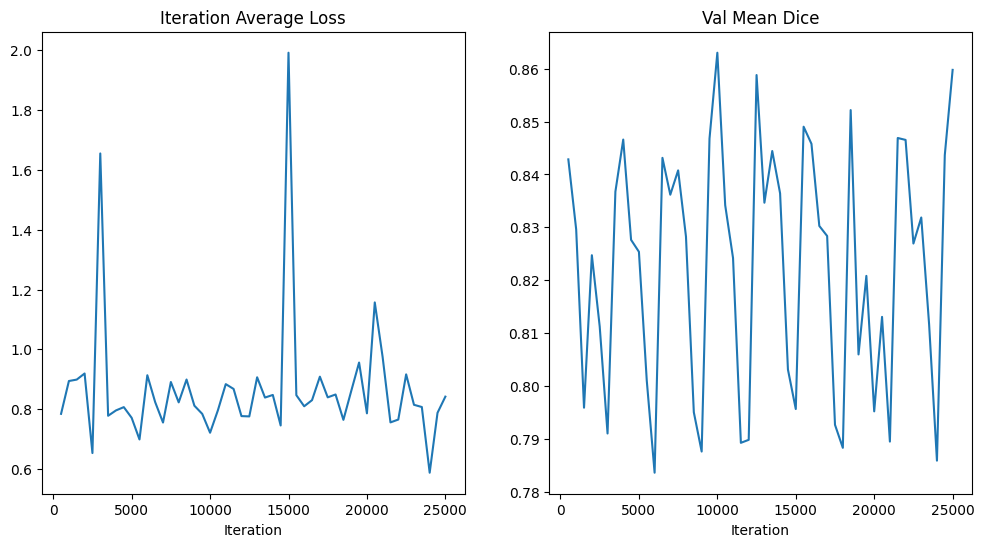

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [12]:
#fold2
torch.cuda.empty_cache()

In [5]:
#fold2
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_2.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.33it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [7]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [8]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1", "swinunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold2_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [9]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold2_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=0.78824): 100%|█| 24/24 [00:23<00:00,  1.02it/
Training (47 / 25000 Steps) (loss=0.69000): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (71 / 25000 Steps) (loss=0.52687): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (95 / 25000 Steps) (loss=0.49642): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (119 / 25000 Steps) (loss=0.68154): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (143 / 25000 Steps) (loss=0.64357): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (167 / 25000 Steps) (loss=0.74298): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (191 / 25000 Steps) (loss=0.68664): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (215 / 25000 Steps) (loss=0.71070): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (239 / 25000 Steps) (loss=0.67723): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (263 / 25000 Steps) (loss=0.55512): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (287 / 25000 Steps) (loss=0.76742): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7774477601051331 Current Avg. Dice: 0.7774477601051331


Training (503 / 25000 Steps) (loss=0.60248): 100%|█| 24/24 [00:33<00:00,  1.39s/
Training (527 / 25000 Steps) (loss=0.60675): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (551 / 25000 Steps) (loss=0.60372): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (575 / 25000 Steps) (loss=1.57473): 100%|█| 24/24 [00:18<00:00,  1.26it
Training (599 / 25000 Steps) (loss=0.63605): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (623 / 25000 Steps) (loss=0.75924): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (647 / 25000 Steps) (loss=0.84589): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (671 / 25000 Steps) (loss=0.75822): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (695 / 25000 Steps) (loss=0.71164): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (719 / 25000 Steps) (loss=0.86568): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (743 / 25000 Steps) (loss=0.82125): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (767 / 25000 Steps) (loss=0.55944): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7914204597473145 Current Avg. Dice: 0.7914204597473145


Training (1007 / 25000 Steps) (loss=0.39288): 100%|█| 24/24 [00:32<00:00,  1.36s
Training (1031 / 25000 Steps) (loss=0.71821): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1055 / 25000 Steps) (loss=0.59105): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1079 / 25000 Steps) (loss=0.70939): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1103 / 25000 Steps) (loss=0.68171): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1127 / 25000 Steps) (loss=0.63591): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1151 / 25000 Steps) (loss=0.81747): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1175 / 25000 Steps) (loss=0.48280): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1199 / 25000 Steps) (loss=0.72358): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1223 / 25000 Steps) (loss=0.63447): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1247 / 25000 Steps) (loss=0.64084): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1271 / 25000 Steps) (loss=0.79198): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7914204597473145 Current Avg. Dice: 0.7583523392677307


Training (1511 / 25000 Steps) (loss=0.68037): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (1535 / 25000 Steps) (loss=0.57972): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1559 / 25000 Steps) (loss=0.70442): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1583 / 25000 Steps) (loss=0.49068): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1607 / 25000 Steps) (loss=0.76633): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1631 / 25000 Steps) (loss=0.63190): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1655 / 25000 Steps) (loss=0.84203): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1679 / 25000 Steps) (loss=0.66026): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1703 / 25000 Steps) (loss=0.49188): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1727 / 25000 Steps) (loss=0.74429): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1751 / 25000 Steps) (loss=0.99459): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1775 / 25000 Steps) (loss=0.59901): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7914204597473145 Current Avg. Dice: 0.7484235763549805


Training (2015 / 25000 Steps) (loss=0.49318): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (2039 / 25000 Steps) (loss=0.63593): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2063 / 25000 Steps) (loss=0.75042): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2087 / 25000 Steps) (loss=0.56550): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2111 / 25000 Steps) (loss=0.86839): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2135 / 25000 Steps) (loss=0.85216): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2159 / 25000 Steps) (loss=0.67792): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2183 / 25000 Steps) (loss=0.79565): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2207 / 25000 Steps) (loss=0.69760): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2231 / 25000 Steps) (loss=0.41610): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2255 / 25000 Steps) (loss=0.74118): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2279 / 25000 Steps) (loss=0.75152): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7914204597473145 Current Avg. Dice: 0.7300147414207458


Training (2519 / 25000 Steps) (loss=0.72304): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (2543 / 25000 Steps) (loss=0.85433): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2567 / 25000 Steps) (loss=0.75396): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2591 / 25000 Steps) (loss=0.51014): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2615 / 25000 Steps) (loss=1.02449): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2639 / 25000 Steps) (loss=0.66619): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2663 / 25000 Steps) (loss=0.60154): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2687 / 25000 Steps) (loss=0.71156): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2711 / 25000 Steps) (loss=0.44397): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2735 / 25000 Steps) (loss=0.60241): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2759 / 25000 Steps) (loss=0.73621): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2783 / 25000 Steps) (loss=0.86053): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7914204597473145 Current Avg. Dice: 0.7060028910636902


Training (3023 / 25000 Steps) (loss=0.48101): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (3047 / 25000 Steps) (loss=0.85428): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3071 / 25000 Steps) (loss=0.67759): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3095 / 25000 Steps) (loss=0.48900): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3119 / 25000 Steps) (loss=0.66879): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3143 / 25000 Steps) (loss=0.63437): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3167 / 25000 Steps) (loss=0.65703): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3191 / 25000 Steps) (loss=0.55642): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3215 / 25000 Steps) (loss=0.70312): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3239 / 25000 Steps) (loss=0.71288): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3263 / 25000 Steps) (loss=0.87752): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3287 / 25000 Steps) (loss=0.54916): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.792393684387207 Current Avg. Dice: 0.792393684387207


Training (3503 / 25000 Steps) (loss=0.68214): 100%|█| 24/24 [00:32<00:00,  1.36s
Training (3527 / 25000 Steps) (loss=0.60780): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3551 / 25000 Steps) (loss=0.53797): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3575 / 25000 Steps) (loss=0.57770): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3599 / 25000 Steps) (loss=0.58357): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3623 / 25000 Steps) (loss=0.78224): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3647 / 25000 Steps) (loss=0.47387): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3671 / 25000 Steps) (loss=0.60835): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3695 / 25000 Steps) (loss=0.36903): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3719 / 25000 Steps) (loss=0.62726): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3743 / 25000 Steps) (loss=0.68607): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3767 / 25000 Steps) (loss=0.76136): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.795793354511261


Training (4007 / 25000 Steps) (loss=1.14891): 100%|█| 24/24 [00:32<00:00,  1.36s
Training (4031 / 25000 Steps) (loss=0.57701): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4055 / 25000 Steps) (loss=1.21437): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4079 / 25000 Steps) (loss=0.48078): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4103 / 25000 Steps) (loss=0.55753): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4127 / 25000 Steps) (loss=0.71625): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4151 / 25000 Steps) (loss=0.69364): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4175 / 25000 Steps) (loss=0.66063): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4199 / 25000 Steps) (loss=0.67456): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4223 / 25000 Steps) (loss=0.81052): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4247 / 25000 Steps) (loss=0.53292): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4271 / 25000 Steps) (loss=0.75280): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7577421069145203


Training (4511 / 25000 Steps) (loss=0.68283): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (4535 / 25000 Steps) (loss=0.48597): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4559 / 25000 Steps) (loss=0.72399): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4583 / 25000 Steps) (loss=0.74219): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4607 / 25000 Steps) (loss=0.77020): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4631 / 25000 Steps) (loss=0.78063): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4655 / 25000 Steps) (loss=0.68524): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4679 / 25000 Steps) (loss=0.63043): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4703 / 25000 Steps) (loss=0.74048): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4727 / 25000 Steps) (loss=0.79939): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4751 / 25000 Steps) (loss=1.04558): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4775 / 25000 Steps) (loss=0.75046): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7558765411376953


Training (5015 / 25000 Steps) (loss=0.84939): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (5039 / 25000 Steps) (loss=1.24479): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5063 / 25000 Steps) (loss=0.75756): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5087 / 25000 Steps) (loss=0.73961): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5111 / 25000 Steps) (loss=0.71553): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5135 / 25000 Steps) (loss=0.65838): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5159 / 25000 Steps) (loss=0.65869): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5183 / 25000 Steps) (loss=0.46743): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5207 / 25000 Steps) (loss=0.55513): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5231 / 25000 Steps) (loss=0.54547): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5255 / 25000 Steps) (loss=0.82000): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5279 / 25000 Steps) (loss=0.70650): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7341518402099609


Training (5519 / 25000 Steps) (loss=0.56553): 100%|█| 24/24 [00:32<00:00,  1.34s
Training (5543 / 25000 Steps) (loss=0.61333): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5567 / 25000 Steps) (loss=0.70624): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5591 / 25000 Steps) (loss=0.66588): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5615 / 25000 Steps) (loss=0.50262): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5639 / 25000 Steps) (loss=0.67075): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5663 / 25000 Steps) (loss=0.80089): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5687 / 25000 Steps) (loss=0.43649): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5711 / 25000 Steps) (loss=0.73203): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5735 / 25000 Steps) (loss=0.62502): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5759 / 25000 Steps) (loss=0.63758): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5783 / 25000 Steps) (loss=0.91456): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7097620368003845


Training (6023 / 25000 Steps) (loss=0.74566): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (6047 / 25000 Steps) (loss=0.63820): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6071 / 25000 Steps) (loss=0.74576): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6095 / 25000 Steps) (loss=0.77826): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6119 / 25000 Steps) (loss=0.78412): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6143 / 25000 Steps) (loss=0.79147): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6167 / 25000 Steps) (loss=0.70033): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6191 / 25000 Steps) (loss=0.56356): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6215 / 25000 Steps) (loss=0.78916): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6239 / 25000 Steps) (loss=0.77318): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6263 / 25000 Steps) (loss=0.83388): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6287 / 25000 Steps) (loss=0.80133): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7846269607543945


Training (6503 / 25000 Steps) (loss=0.59696): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (6527 / 25000 Steps) (loss=0.49675): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6551 / 25000 Steps) (loss=0.99865): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6575 / 25000 Steps) (loss=0.64195): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6599 / 25000 Steps) (loss=0.63913): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6623 / 25000 Steps) (loss=0.56322): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6647 / 25000 Steps) (loss=1.06353): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (6671 / 25000 Steps) (loss=0.59173): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6695 / 25000 Steps) (loss=0.69163): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6719 / 25000 Steps) (loss=0.40747): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6743 / 25000 Steps) (loss=0.63016): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6767 / 25000 Steps) (loss=0.70579): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7892752289772034


Training (7007 / 25000 Steps) (loss=1.07465): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (7031 / 25000 Steps) (loss=0.47414): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7055 / 25000 Steps) (loss=0.78302): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7079 / 25000 Steps) (loss=0.74132): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7103 / 25000 Steps) (loss=1.81857): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7127 / 25000 Steps) (loss=0.87202): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7151 / 25000 Steps) (loss=0.68284): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7175 / 25000 Steps) (loss=0.69789): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7199 / 25000 Steps) (loss=0.69035): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7223 / 25000 Steps) (loss=0.61923): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7247 / 25000 Steps) (loss=0.75041): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7271 / 25000 Steps) (loss=0.62027): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7708624005317688


Training (7511 / 25000 Steps) (loss=0.99722): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (7535 / 25000 Steps) (loss=0.72967): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7559 / 25000 Steps) (loss=0.77549): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7583 / 25000 Steps) (loss=1.20255): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7607 / 25000 Steps) (loss=0.63977): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7631 / 25000 Steps) (loss=0.84467): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7655 / 25000 Steps) (loss=0.83426): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7679 / 25000 Steps) (loss=0.57192): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7703 / 25000 Steps) (loss=0.70316): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7727 / 25000 Steps) (loss=0.75968): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7751 / 25000 Steps) (loss=0.85113): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7775 / 25000 Steps) (loss=0.80731): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7626924514770508


Training (8015 / 25000 Steps) (loss=0.69003): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (8039 / 25000 Steps) (loss=0.67364): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8063 / 25000 Steps) (loss=0.79423): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8087 / 25000 Steps) (loss=0.56379): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8111 / 25000 Steps) (loss=0.75403): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8135 / 25000 Steps) (loss=0.51559): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8159 / 25000 Steps) (loss=0.87871): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8183 / 25000 Steps) (loss=0.65384): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8207 / 25000 Steps) (loss=0.56789): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8231 / 25000 Steps) (loss=0.76494): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8255 / 25000 Steps) (loss=0.63814): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8279 / 25000 Steps) (loss=0.69690): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7192638516426086


Training (8519 / 25000 Steps) (loss=0.74335): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (8543 / 25000 Steps) (loss=0.80567): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8567 / 25000 Steps) (loss=0.66784): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8591 / 25000 Steps) (loss=0.52077): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8615 / 25000 Steps) (loss=1.16688): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8639 / 25000 Steps) (loss=0.64402): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8663 / 25000 Steps) (loss=0.74957): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8687 / 25000 Steps) (loss=0.64948): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8711 / 25000 Steps) (loss=0.54972): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8735 / 25000 Steps) (loss=0.67616): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8759 / 25000 Steps) (loss=0.60730): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8783 / 25000 Steps) (loss=0.63837): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7029164433479309


Training (9023 / 25000 Steps) (loss=0.61965): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (9047 / 25000 Steps) (loss=0.70686): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9071 / 25000 Steps) (loss=2.06490): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9095 / 25000 Steps) (loss=0.44914): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9119 / 25000 Steps) (loss=0.73250): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9143 / 25000 Steps) (loss=0.91466): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9167 / 25000 Steps) (loss=0.58048): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9191 / 25000 Steps) (loss=0.71188): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9215 / 25000 Steps) (loss=0.60861): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9239 / 25000 Steps) (loss=0.60888): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9263 / 25000 Steps) (loss=0.65641): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9287 / 25000 Steps) (loss=0.84943): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7486733794212341


Training (9503 / 25000 Steps) (loss=0.63803): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (9527 / 25000 Steps) (loss=0.56885): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9551 / 25000 Steps) (loss=0.74846): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9575 / 25000 Steps) (loss=0.96609): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9599 / 25000 Steps) (loss=0.41311): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9623 / 25000 Steps) (loss=0.80268): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9647 / 25000 Steps) (loss=0.73969): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9671 / 25000 Steps) (loss=1.08393): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9695 / 25000 Steps) (loss=0.97876): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9719 / 25000 Steps) (loss=0.68901): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9743 / 25000 Steps) (loss=0.68467): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9767 / 25000 Steps) (loss=0.76779): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7758681178092957


Training (10007 / 25000 Steps) (loss=0.70859): 100%|█| 24/24 [00:32<00:00,  1.35
Training (10031 / 25000 Steps) (loss=0.80514): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10055 / 25000 Steps) (loss=0.70556): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10079 / 25000 Steps) (loss=0.46857): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10103 / 25000 Steps) (loss=0.57584): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10127 / 25000 Steps) (loss=0.99751): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10151 / 25000 Steps) (loss=0.63257): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10175 / 25000 Steps) (loss=0.71599): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10199 / 25000 Steps) (loss=0.67306): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10223 / 25000 Steps) (loss=0.60793): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10247 / 25000 Steps) (loss=0.46815): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10271 / 25000 Steps) (loss=1.13263): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7587773203849792


Training (10511 / 25000 Steps) (loss=1.14173): 100%|█| 24/24 [00:32<00:00,  1.35
Training (10535 / 25000 Steps) (loss=0.84541): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10559 / 25000 Steps) (loss=0.42415): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10583 / 25000 Steps) (loss=0.59081): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10607 / 25000 Steps) (loss=0.61404): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10631 / 25000 Steps) (loss=0.73019): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10655 / 25000 Steps) (loss=0.73827): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10679 / 25000 Steps) (loss=0.75311): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10703 / 25000 Steps) (loss=0.69358): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10727 / 25000 Steps) (loss=0.79930): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10751 / 25000 Steps) (loss=0.73536): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10775 / 25000 Steps) (loss=0.63537): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7179369926452637


Training (11015 / 25000 Steps) (loss=0.75704): 100%|█| 24/24 [00:32<00:00,  1.35
Training (11039 / 25000 Steps) (loss=0.78378): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11063 / 25000 Steps) (loss=0.66679): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11087 / 25000 Steps) (loss=0.83390): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11111 / 25000 Steps) (loss=0.56532): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11135 / 25000 Steps) (loss=0.75408): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11159 / 25000 Steps) (loss=0.65489): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11183 / 25000 Steps) (loss=0.64987): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11207 / 25000 Steps) (loss=0.96088): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11231 / 25000 Steps) (loss=0.82782): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11255 / 25000 Steps) (loss=1.25420): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11279 / 25000 Steps) (loss=1.27550): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7067334651947021


Training (11519 / 25000 Steps) (loss=1.62353): 100%|█| 24/24 [00:32<00:00,  1.35
Training (11543 / 25000 Steps) (loss=0.79499): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11567 / 25000 Steps) (loss=0.54351): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11591 / 25000 Steps) (loss=1.10675): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11615 / 25000 Steps) (loss=1.25916): 100%|█| 24/24 [00:18<00:00,  1.27
Training (11639 / 25000 Steps) (loss=1.19106): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11663 / 25000 Steps) (loss=0.55455): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11687 / 25000 Steps) (loss=0.60835): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11711 / 25000 Steps) (loss=0.80470): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11735 / 25000 Steps) (loss=0.76446): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11759 / 25000 Steps) (loss=0.88243): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11783 / 25000 Steps) (loss=0.53861): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.795793354511261 Current Avg. Dice: 0.7109335064888


Training (12023 / 25000 Steps) (loss=0.68331): 100%|█| 24/24 [00:32<00:00,  1.35
Training (12047 / 25000 Steps) (loss=0.69755): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12071 / 25000 Steps) (loss=0.70209): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12095 / 25000 Steps) (loss=0.67614): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12119 / 25000 Steps) (loss=1.14005): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12143 / 25000 Steps) (loss=0.96330): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12167 / 25000 Steps) (loss=0.69983): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12191 / 25000 Steps) (loss=0.59442): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12215 / 25000 Steps) (loss=0.51070): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12239 / 25000 Steps) (loss=1.60069): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12263 / 25000 Steps) (loss=0.70487): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12287 / 25000 Steps) (loss=0.66039): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.8023608326911926


Training (12503 / 25000 Steps) (loss=0.73627): 100%|█| 24/24 [00:32<00:00,  1.36
Training (12527 / 25000 Steps) (loss=0.69465): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12551 / 25000 Steps) (loss=0.64421): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12575 / 25000 Steps) (loss=0.71665): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12599 / 25000 Steps) (loss=0.85546): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12623 / 25000 Steps) (loss=0.68060): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12647 / 25000 Steps) (loss=0.77104): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12671 / 25000 Steps) (loss=0.64418): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12695 / 25000 Steps) (loss=0.67939): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12719 / 25000 Steps) (loss=0.48572): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12743 / 25000 Steps) (loss=0.93047): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12767 / 25000 Steps) (loss=0.61468): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7881975173950195


Training (13007 / 25000 Steps) (loss=0.68078): 100%|█| 24/24 [00:32<00:00,  1.35
Training (13031 / 25000 Steps) (loss=0.51832): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13055 / 25000 Steps) (loss=0.86486): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13079 / 25000 Steps) (loss=0.62443): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13103 / 25000 Steps) (loss=1.66559): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13127 / 25000 Steps) (loss=0.57802): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13151 / 25000 Steps) (loss=0.80063): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13175 / 25000 Steps) (loss=0.84629): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13199 / 25000 Steps) (loss=0.66212): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13223 / 25000 Steps) (loss=0.54129): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13247 / 25000 Steps) (loss=0.57913): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13271 / 25000 Steps) (loss=0.77411): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7664132118225098


Training (13511 / 25000 Steps) (loss=0.70307): 100%|█| 24/24 [00:32<00:00,  1.35
Training (13535 / 25000 Steps) (loss=0.79839): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13559 / 25000 Steps) (loss=0.70997): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13583 / 25000 Steps) (loss=0.84041): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13607 / 25000 Steps) (loss=0.59375): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13631 / 25000 Steps) (loss=0.60049): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13655 / 25000 Steps) (loss=0.59046): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13679 / 25000 Steps) (loss=0.71023): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13703 / 25000 Steps) (loss=0.80412): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13727 / 25000 Steps) (loss=0.66192): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13751 / 25000 Steps) (loss=0.56447): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13775 / 25000 Steps) (loss=0.51422): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7316265106201172


Training (14015 / 25000 Steps) (loss=0.84176): 100%|█| 24/24 [00:32<00:00,  1.35
Training (14039 / 25000 Steps) (loss=0.42970): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14063 / 25000 Steps) (loss=0.85064): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14087 / 25000 Steps) (loss=0.67273): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14111 / 25000 Steps) (loss=0.45310): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14135 / 25000 Steps) (loss=1.13014): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14159 / 25000 Steps) (loss=0.84601): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14183 / 25000 Steps) (loss=1.05900): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14207 / 25000 Steps) (loss=0.61385): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14231 / 25000 Steps) (loss=0.82230): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14255 / 25000 Steps) (loss=0.62788): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14279 / 25000 Steps) (loss=0.65770): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7453813552856445


Training (14519 / 25000 Steps) (loss=0.93908): 100%|█| 24/24 [00:32<00:00,  1.35
Training (14543 / 25000 Steps) (loss=0.84945): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14567 / 25000 Steps) (loss=0.65395): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14591 / 25000 Steps) (loss=0.76456): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14615 / 25000 Steps) (loss=0.78729): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14639 / 25000 Steps) (loss=0.90146): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14663 / 25000 Steps) (loss=0.82425): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14687 / 25000 Steps) (loss=0.87463): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14711 / 25000 Steps) (loss=0.63531): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14735 / 25000 Steps) (loss=0.63239): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14759 / 25000 Steps) (loss=0.46432): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14783 / 25000 Steps) (loss=0.77015): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7040823101997375


Training (15023 / 25000 Steps) (loss=0.84421): 100%|█| 24/24 [00:32<00:00,  1.35
Training (15047 / 25000 Steps) (loss=0.44640): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15071 / 25000 Steps) (loss=0.71113): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15095 / 25000 Steps) (loss=0.75331): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15119 / 25000 Steps) (loss=0.61851): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15143 / 25000 Steps) (loss=0.69696): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15167 / 25000 Steps) (loss=0.66938): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15191 / 25000 Steps) (loss=0.59220): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15215 / 25000 Steps) (loss=0.63933): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15239 / 25000 Steps) (loss=1.03420): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15263 / 25000 Steps) (loss=0.64291): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15287 / 25000 Steps) (loss=0.53341): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7773103713989258


Training (15503 / 25000 Steps) (loss=0.52712): 100%|█| 24/24 [00:32<00:00,  1.35
Training (15527 / 25000 Steps) (loss=0.82451): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15551 / 25000 Steps) (loss=0.70328): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15575 / 25000 Steps) (loss=0.81386): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15599 / 25000 Steps) (loss=0.83006): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15623 / 25000 Steps) (loss=0.62703): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15647 / 25000 Steps) (loss=0.82439): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15671 / 25000 Steps) (loss=0.79256): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15695 / 25000 Steps) (loss=0.77217): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15719 / 25000 Steps) (loss=0.68122): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15743 / 25000 Steps) (loss=0.57063): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15767 / 25000 Steps) (loss=0.72474): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7555899024009705


Training (16007 / 25000 Steps) (loss=0.85239): 100%|█| 24/24 [00:32<00:00,  1.35
Training (16031 / 25000 Steps) (loss=1.17792): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16055 / 25000 Steps) (loss=0.65151): 100%|█| 24/24 [00:18<00:00,  1.27
Training (16079 / 25000 Steps) (loss=0.77575): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16103 / 25000 Steps) (loss=0.73147): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16127 / 25000 Steps) (loss=0.67535): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16151 / 25000 Steps) (loss=0.45452): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16175 / 25000 Steps) (loss=1.14546): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16199 / 25000 Steps) (loss=1.34107): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16223 / 25000 Steps) (loss=0.78977): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16247 / 25000 Steps) (loss=0.84006): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16271 / 25000 Steps) (loss=0.59219): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7651593089103699


Training (16511 / 25000 Steps) (loss=0.75656): 100%|█| 24/24 [00:32<00:00,  1.35
Training (16535 / 25000 Steps) (loss=1.39877): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16559 / 25000 Steps) (loss=0.82029): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16583 / 25000 Steps) (loss=0.59711): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16607 / 25000 Steps) (loss=0.84206): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16631 / 25000 Steps) (loss=0.78059): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16655 / 25000 Steps) (loss=0.93280): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16679 / 25000 Steps) (loss=0.71154): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16703 / 25000 Steps) (loss=1.00633): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16727 / 25000 Steps) (loss=0.63115): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16751 / 25000 Steps) (loss=0.89976): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16775 / 25000 Steps) (loss=0.64870): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7336705327033997


Training (17015 / 25000 Steps) (loss=0.70944): 100%|█| 24/24 [00:32<00:00,  1.35
Training (17039 / 25000 Steps) (loss=0.55526): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17063 / 25000 Steps) (loss=0.95108): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17087 / 25000 Steps) (loss=0.74354): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17111 / 25000 Steps) (loss=0.86445): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17135 / 25000 Steps) (loss=0.80113): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17159 / 25000 Steps) (loss=0.76977): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17183 / 25000 Steps) (loss=0.61636): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17207 / 25000 Steps) (loss=0.73444): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17231 / 25000 Steps) (loss=0.70703): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17255 / 25000 Steps) (loss=0.98720): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17279 / 25000 Steps) (loss=0.58430): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7287953495979309


Training (17519 / 25000 Steps) (loss=0.65274): 100%|█| 24/24 [00:32<00:00,  1.34
Training (17543 / 25000 Steps) (loss=0.65538): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17567 / 25000 Steps) (loss=0.64240): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17591 / 25000 Steps) (loss=0.50818): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17615 / 25000 Steps) (loss=1.56837): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17639 / 25000 Steps) (loss=0.87555): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17663 / 25000 Steps) (loss=0.78251): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17687 / 25000 Steps) (loss=0.77087): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17711 / 25000 Steps) (loss=0.62457): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17735 / 25000 Steps) (loss=0.72315): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17759 / 25000 Steps) (loss=0.88150): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17783 / 25000 Steps) (loss=0.56233): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7078364491462708


Training (18023 / 25000 Steps) (loss=0.77120): 100%|█| 24/24 [00:32<00:00,  1.34
Training (18047 / 25000 Steps) (loss=0.81596): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18071 / 25000 Steps) (loss=0.80492): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18095 / 25000 Steps) (loss=0.68079): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18119 / 25000 Steps) (loss=0.80414): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18143 / 25000 Steps) (loss=0.71146): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18167 / 25000 Steps) (loss=1.49948): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18191 / 25000 Steps) (loss=0.76809): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18215 / 25000 Steps) (loss=0.69418): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18239 / 25000 Steps) (loss=0.63340): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18263 / 25000 Steps) (loss=0.53938): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18287 / 25000 Steps) (loss=0.71502): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7865330576896667


Training (18503 / 25000 Steps) (loss=0.78152): 100%|█| 24/24 [00:32<00:00,  1.34
Training (18527 / 25000 Steps) (loss=0.77001): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18551 / 25000 Steps) (loss=0.61223): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18575 / 25000 Steps) (loss=0.83422): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18599 / 25000 Steps) (loss=0.55631): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18623 / 25000 Steps) (loss=0.59286): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18647 / 25000 Steps) (loss=0.57926): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18671 / 25000 Steps) (loss=1.07281): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18695 / 25000 Steps) (loss=0.64072): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18719 / 25000 Steps) (loss=0.58438): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18743 / 25000 Steps) (loss=0.77060): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18767 / 25000 Steps) (loss=0.62292): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7643775939941406


Training (19007 / 25000 Steps) (loss=0.57654): 100%|█| 24/24 [00:32<00:00,  1.34
Training (19031 / 25000 Steps) (loss=0.62189): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19055 / 25000 Steps) (loss=0.80175): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19079 / 25000 Steps) (loss=0.55322): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19103 / 25000 Steps) (loss=0.58494): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19127 / 25000 Steps) (loss=0.63653): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19151 / 25000 Steps) (loss=0.62629): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19175 / 25000 Steps) (loss=0.62774): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19199 / 25000 Steps) (loss=0.66353): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19223 / 25000 Steps) (loss=0.67361): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19247 / 25000 Steps) (loss=0.64948): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19271 / 25000 Steps) (loss=0.70129): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7416945099830627


Training (19511 / 25000 Steps) (loss=0.89567): 100%|█| 24/24 [00:32<00:00,  1.34
Training (19535 / 25000 Steps) (loss=0.83430): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19559 / 25000 Steps) (loss=0.56612): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19583 / 25000 Steps) (loss=0.91738): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19607 / 25000 Steps) (loss=0.62854): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19631 / 25000 Steps) (loss=0.69918): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19655 / 25000 Steps) (loss=0.63644): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19679 / 25000 Steps) (loss=0.68986): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19703 / 25000 Steps) (loss=0.65665): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19727 / 25000 Steps) (loss=0.72822): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19751 / 25000 Steps) (loss=2.10264): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19775 / 25000 Steps) (loss=0.77036): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7433467507362366


Training (20015 / 25000 Steps) (loss=0.82233): 100%|█| 24/24 [00:32<00:00,  1.34
Training (20039 / 25000 Steps) (loss=0.76575): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20063 / 25000 Steps) (loss=1.55620): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20087 / 25000 Steps) (loss=0.81793): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20111 / 25000 Steps) (loss=0.98146): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20135 / 25000 Steps) (loss=0.53437): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20159 / 25000 Steps) (loss=0.65340): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20183 / 25000 Steps) (loss=0.73882): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20207 / 25000 Steps) (loss=0.75696): 100%|█| 24/24 [00:18<00:00,  1.27
Training (20231 / 25000 Steps) (loss=0.78804): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20255 / 25000 Steps) (loss=0.76611): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20279 / 25000 Steps) (loss=0.71973): 100%|█| 24/24 [00:18<00:00,  1.27
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7406787872314453


Training (20519 / 25000 Steps) (loss=0.61087): 100%|█| 24/24 [00:32<00:00,  1.35
Training (20543 / 25000 Steps) (loss=0.57903): 100%|█| 24/24 [00:18<00:00,  1.27
Training (20567 / 25000 Steps) (loss=0.70083): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20591 / 25000 Steps) (loss=0.48322): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20615 / 25000 Steps) (loss=0.63586): 100%|█| 24/24 [00:18<00:00,  1.27
Training (20639 / 25000 Steps) (loss=0.71232): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20663 / 25000 Steps) (loss=0.73091): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20687 / 25000 Steps) (loss=0.68018): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20711 / 25000 Steps) (loss=0.63454): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20735 / 25000 Steps) (loss=0.69432): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20759 / 25000 Steps) (loss=0.64181): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20783 / 25000 Steps) (loss=0.55183): 100%|█| 24/24 [00:18<00:00,  1.27
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7086021304130554


Training (21023 / 25000 Steps) (loss=0.80064): 100%|█| 24/24 [00:32<00:00,  1.35
Training (21047 / 25000 Steps) (loss=0.79103): 100%|█| 24/24 [00:18<00:00,  1.27
Training (21071 / 25000 Steps) (loss=0.67437): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21095 / 25000 Steps) (loss=0.78527): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21119 / 25000 Steps) (loss=0.75313): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21143 / 25000 Steps) (loss=0.73077): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21167 / 25000 Steps) (loss=0.52644): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21191 / 25000 Steps) (loss=0.69053): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21215 / 25000 Steps) (loss=0.94497): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21239 / 25000 Steps) (loss=0.71261): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21263 / 25000 Steps) (loss=0.71957): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21287 / 25000 Steps) (loss=0.92284): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7762476801872253


Training (21503 / 25000 Steps) (loss=0.86871): 100%|█| 24/24 [00:32<00:00,  1.35
Training (21527 / 25000 Steps) (loss=0.78405): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21551 / 25000 Steps) (loss=0.60771): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21575 / 25000 Steps) (loss=0.51139): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21599 / 25000 Steps) (loss=1.14076): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21623 / 25000 Steps) (loss=0.83986): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21647 / 25000 Steps) (loss=0.96679): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21671 / 25000 Steps) (loss=0.78578): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21695 / 25000 Steps) (loss=0.72092): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21719 / 25000 Steps) (loss=0.77393): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21743 / 25000 Steps) (loss=0.56733): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21767 / 25000 Steps) (loss=0.60120): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7614998817443848


Training (22007 / 25000 Steps) (loss=0.68255): 100%|█| 24/24 [00:32<00:00,  1.35
Training (22031 / 25000 Steps) (loss=0.58698): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22055 / 25000 Steps) (loss=1.19254): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22079 / 25000 Steps) (loss=0.61544): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22103 / 25000 Steps) (loss=0.69612): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22127 / 25000 Steps) (loss=0.67075): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22151 / 25000 Steps) (loss=0.65970): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22175 / 25000 Steps) (loss=0.67148): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22199 / 25000 Steps) (loss=0.65305): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22223 / 25000 Steps) (loss=0.60532): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22247 / 25000 Steps) (loss=0.65956): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22271 / 25000 Steps) (loss=0.59651): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7503579258918762


Training (22511 / 25000 Steps) (loss=0.88364): 100%|█| 24/24 [00:32<00:00,  1.35
Training (22535 / 25000 Steps) (loss=0.70085): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22559 / 25000 Steps) (loss=0.68034): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22583 / 25000 Steps) (loss=1.38415): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22607 / 25000 Steps) (loss=0.59342): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22631 / 25000 Steps) (loss=0.71960): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22655 / 25000 Steps) (loss=0.53720): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22679 / 25000 Steps) (loss=0.59443): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22703 / 25000 Steps) (loss=0.61691): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22727 / 25000 Steps) (loss=0.69020): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22751 / 25000 Steps) (loss=0.57128): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22775 / 25000 Steps) (loss=0.69669): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7328304648399353


Training (23015 / 25000 Steps) (loss=0.60164): 100%|█| 24/24 [00:32<00:00,  1.35
Training (23039 / 25000 Steps) (loss=0.59230): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23063 / 25000 Steps) (loss=0.85213): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23087 / 25000 Steps) (loss=0.49361): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23111 / 25000 Steps) (loss=0.64060): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23135 / 25000 Steps) (loss=0.48204): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23159 / 25000 Steps) (loss=0.58609): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23183 / 25000 Steps) (loss=0.63452): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23207 / 25000 Steps) (loss=0.75167): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23231 / 25000 Steps) (loss=0.73327): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23255 / 25000 Steps) (loss=0.61856): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23279 / 25000 Steps) (loss=1.40119): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7421547770500183


Training (23519 / 25000 Steps) (loss=0.65883): 100%|█| 24/24 [00:32<00:00,  1.35
Training (23543 / 25000 Steps) (loss=0.45198): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23567 / 25000 Steps) (loss=1.04478): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23591 / 25000 Steps) (loss=0.90672): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23615 / 25000 Steps) (loss=0.85162): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23639 / 25000 Steps) (loss=0.59114): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23663 / 25000 Steps) (loss=0.86324): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23687 / 25000 Steps) (loss=0.76298): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23711 / 25000 Steps) (loss=0.83332): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23735 / 25000 Steps) (loss=0.82863): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23759 / 25000 Steps) (loss=0.52753): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23783 / 25000 Steps) (loss=0.70245): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7133942246437073


Training (24023 / 25000 Steps) (loss=0.90733): 100%|█| 24/24 [00:32<00:00,  1.35
Training (24047 / 25000 Steps) (loss=0.41073): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24071 / 25000 Steps) (loss=0.81563): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24095 / 25000 Steps) (loss=0.54905): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24119 / 25000 Steps) (loss=0.68844): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24143 / 25000 Steps) (loss=0.74416): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24167 / 25000 Steps) (loss=0.37767): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24191 / 25000 Steps) (loss=0.58241): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24215 / 25000 Steps) (loss=0.58787): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24239 / 25000 Steps) (loss=0.70129): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24263 / 25000 Steps) (loss=0.71947): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24287 / 25000 Steps) (loss=0.73602): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.7835721969604492


Training (24503 / 25000 Steps) (loss=0.66765): 100%|█| 24/24 [00:32<00:00,  1.35
Training (24527 / 25000 Steps) (loss=0.68954): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24551 / 25000 Steps) (loss=0.74667): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24575 / 25000 Steps) (loss=0.46892): 100%|█| 24/24 [00:18<00:00,  1.27
Training (24599 / 25000 Steps) (loss=0.93550): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24623 / 25000 Steps) (loss=0.87302): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24647 / 25000 Steps) (loss=0.69871): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24671 / 25000 Steps) (loss=0.58973): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24695 / 25000 Steps) (loss=0.91563): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24719 / 25000 Steps) (loss=0.75283): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24743 / 25000 Steps) (loss=0.73556): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24767 / 25000 Steps) (loss=0.58858): 100%|█| 24/24 [00:18<00:00,  1.27
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8023608326911926 Current Avg. Dice: 0.789560854434967


Training (25007 / 25000 Steps) (loss=0.65564): 100%|█| 24/24 [00:32<00:00,  1.35


<All keys matched successfully>

In [10]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8024 at iteration: 12500


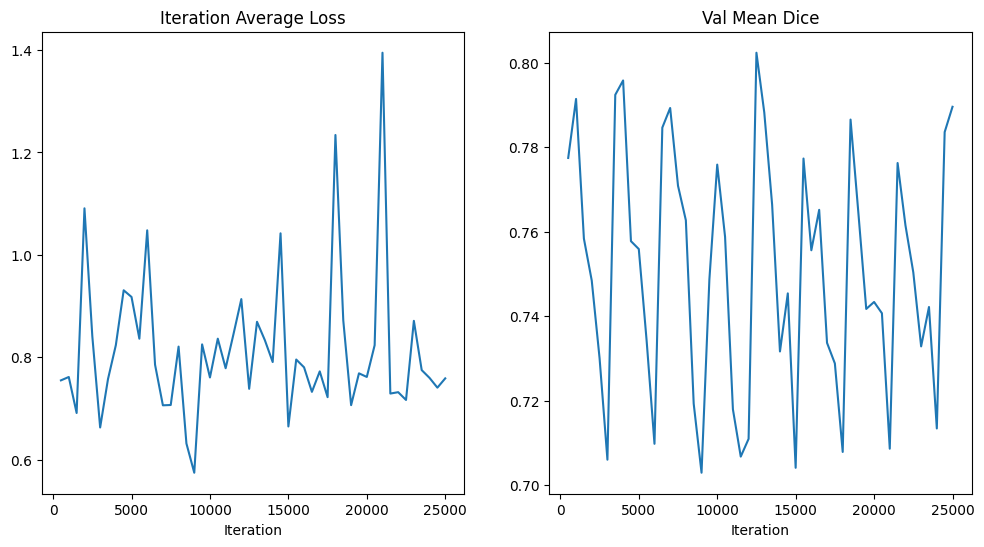

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
#fold3
torch.cuda.empty_cache()

In [5]:
#fold3
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_3.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.09it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [7]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [8]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1", "swinunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold3_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [9]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold3_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=0.72278): 100%|█| 24/24 [00:23<00:00,  1.02it/
Training (47 / 25000 Steps) (loss=0.78038): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (71 / 25000 Steps) (loss=1.17521): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (95 / 25000 Steps) (loss=1.07149): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (119 / 25000 Steps) (loss=0.68118): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (143 / 25000 Steps) (loss=0.79375): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (167 / 25000 Steps) (loss=0.71356): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (191 / 25000 Steps) (loss=0.89047): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (215 / 25000 Steps) (loss=0.78914): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (239 / 25000 Steps) (loss=0.73121): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (263 / 25000 Steps) (loss=0.66434): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (287 / 25000 Steps) (loss=0.75363): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7318546175956726 Current Avg. Dice: 0.7318546175956726


Training (503 / 25000 Steps) (loss=0.68609): 100%|█| 24/24 [00:33<00:00,  1.39s/
Training (527 / 25000 Steps) (loss=0.85905): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (551 / 25000 Steps) (loss=0.63846): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (575 / 25000 Steps) (loss=0.65104): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (599 / 25000 Steps) (loss=0.54088): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (623 / 25000 Steps) (loss=0.89660): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (647 / 25000 Steps) (loss=0.67563): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (671 / 25000 Steps) (loss=0.58539): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (695 / 25000 Steps) (loss=0.67985): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (719 / 25000 Steps) (loss=0.51679): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (743 / 25000 Steps) (loss=0.57328): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (767 / 25000 Steps) (loss=0.69030): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7383990287780762 Current Avg. Dice: 0.7383990287780762


Training (1007 / 25000 Steps) (loss=0.72604): 100%|█| 24/24 [00:32<00:00,  1.36s
Training (1031 / 25000 Steps) (loss=0.84653): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1055 / 25000 Steps) (loss=0.54406): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1079 / 25000 Steps) (loss=0.72161): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1103 / 25000 Steps) (loss=0.63200): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1127 / 25000 Steps) (loss=0.67483): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1151 / 25000 Steps) (loss=0.95736): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1175 / 25000 Steps) (loss=0.82847): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1199 / 25000 Steps) (loss=0.70616): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1223 / 25000 Steps) (loss=0.55393): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1247 / 25000 Steps) (loss=0.77815): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1271 / 25000 Steps) (loss=0.80192): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7383990287780762 Current Avg. Dice: 0.7228376269340515


Training (1511 / 25000 Steps) (loss=0.86516): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (1535 / 25000 Steps) (loss=0.65038): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1559 / 25000 Steps) (loss=0.70991): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1583 / 25000 Steps) (loss=0.55982): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1607 / 25000 Steps) (loss=0.68265): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1631 / 25000 Steps) (loss=0.49054): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1655 / 25000 Steps) (loss=0.59595): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1679 / 25000 Steps) (loss=0.60248): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1703 / 25000 Steps) (loss=0.64944): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1727 / 25000 Steps) (loss=0.54821): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1751 / 25000 Steps) (loss=0.80630): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1775 / 25000 Steps) (loss=0.61034): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7383990287780762 Current Avg. Dice: 0.7298000454902649


Training (2015 / 25000 Steps) (loss=0.62751): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (2039 / 25000 Steps) (loss=0.79731): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2063 / 25000 Steps) (loss=0.66665): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2087 / 25000 Steps) (loss=0.48404): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2111 / 25000 Steps) (loss=0.56115): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2135 / 25000 Steps) (loss=0.73547): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2159 / 25000 Steps) (loss=0.63158): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2183 / 25000 Steps) (loss=0.79504): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2207 / 25000 Steps) (loss=0.76825): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2231 / 25000 Steps) (loss=0.62570): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2255 / 25000 Steps) (loss=0.54192): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2279 / 25000 Steps) (loss=0.77104): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7383990287780762 Current Avg. Dice: 0.718148946762085


Training (2519 / 25000 Steps) (loss=0.74823): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (2543 / 25000 Steps) (loss=0.58671): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2567 / 25000 Steps) (loss=0.85506): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2591 / 25000 Steps) (loss=0.96905): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2615 / 25000 Steps) (loss=0.72654): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2639 / 25000 Steps) (loss=0.66819): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2663 / 25000 Steps) (loss=0.65053): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2687 / 25000 Steps) (loss=0.56133): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2711 / 25000 Steps) (loss=0.58556): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2735 / 25000 Steps) (loss=0.82976): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2759 / 25000 Steps) (loss=0.83000): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2783 / 25000 Steps) (loss=0.84496): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7383990287780762 Current Avg. Dice: 0.7089959979057312


Training (3023 / 25000 Steps) (loss=0.87654): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (3047 / 25000 Steps) (loss=0.67558): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3071 / 25000 Steps) (loss=0.84022): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3095 / 25000 Steps) (loss=0.77380): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3119 / 25000 Steps) (loss=0.80213): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3143 / 25000 Steps) (loss=0.70141): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3167 / 25000 Steps) (loss=0.60778): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3191 / 25000 Steps) (loss=0.82298): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3215 / 25000 Steps) (loss=0.62593): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3239 / 25000 Steps) (loss=0.65359): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3263 / 25000 Steps) (loss=0.66029): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3287 / 25000 Steps) (loss=0.73557): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7383990287780762 Current Avg. Dice: 0.7342793345451355


Training (3503 / 25000 Steps) (loss=0.78204): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (3527 / 25000 Steps) (loss=0.65063): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3551 / 25000 Steps) (loss=0.55140): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3575 / 25000 Steps) (loss=0.75389): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3599 / 25000 Steps) (loss=0.44097): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3623 / 25000 Steps) (loss=0.67964): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3647 / 25000 Steps) (loss=0.49103): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3671 / 25000 Steps) (loss=1.00161): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3695 / 25000 Steps) (loss=0.94652): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3719 / 25000 Steps) (loss=0.79247): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3743 / 25000 Steps) (loss=1.40787): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3767 / 25000 Steps) (loss=0.74016): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7383990287780762 Current Avg. Dice: 0.730982780456543


Training (4007 / 25000 Steps) (loss=0.61383): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (4031 / 25000 Steps) (loss=0.81310): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4055 / 25000 Steps) (loss=0.70264): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4079 / 25000 Steps) (loss=0.70113): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4103 / 25000 Steps) (loss=0.79842): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4127 / 25000 Steps) (loss=0.72884): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4151 / 25000 Steps) (loss=0.66338): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4175 / 25000 Steps) (loss=0.78920): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4199 / 25000 Steps) (loss=0.50465): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4223 / 25000 Steps) (loss=0.80993): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4247 / 25000 Steps) (loss=0.53938): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4271 / 25000 Steps) (loss=0.63584): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7383990287780762 Current Avg. Dice: 0.7351467609405518


Training (4511 / 25000 Steps) (loss=0.75259): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (4535 / 25000 Steps) (loss=0.76322): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4559 / 25000 Steps) (loss=0.69302): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4583 / 25000 Steps) (loss=0.79819): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4607 / 25000 Steps) (loss=0.54748): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4631 / 25000 Steps) (loss=0.72000): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4655 / 25000 Steps) (loss=0.81921): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4679 / 25000 Steps) (loss=0.66617): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4703 / 25000 Steps) (loss=0.67243): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4727 / 25000 Steps) (loss=0.76810): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4751 / 25000 Steps) (loss=0.51735): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4775 / 25000 Steps) (loss=0.79815): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7383990287780762 Current Avg. Dice: 0.7282474637031555


Training (5015 / 25000 Steps) (loss=0.56388): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (5039 / 25000 Steps) (loss=0.62347): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5063 / 25000 Steps) (loss=0.62101): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5087 / 25000 Steps) (loss=0.68004): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5111 / 25000 Steps) (loss=0.76864): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5135 / 25000 Steps) (loss=0.70438): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5159 / 25000 Steps) (loss=0.65481): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5183 / 25000 Steps) (loss=0.66205): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5207 / 25000 Steps) (loss=0.72289): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5231 / 25000 Steps) (loss=0.78672): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5255 / 25000 Steps) (loss=0.56552): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5279 / 25000 Steps) (loss=0.69592): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7383990287780762 Current Avg. Dice: 0.7241067290306091


Training (5519 / 25000 Steps) (loss=0.75241): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (5543 / 25000 Steps) (loss=0.88157): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5567 / 25000 Steps) (loss=0.55360): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5591 / 25000 Steps) (loss=0.70696): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5615 / 25000 Steps) (loss=0.64628): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5639 / 25000 Steps) (loss=0.58146): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5663 / 25000 Steps) (loss=0.64196): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5687 / 25000 Steps) (loss=0.67498): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5711 / 25000 Steps) (loss=0.82205): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5735 / 25000 Steps) (loss=0.73480): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5759 / 25000 Steps) (loss=0.79326): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5783 / 25000 Steps) (loss=0.70589): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7383990287780762 Current Avg. Dice: 0.7064765095710754


Training (6023 / 25000 Steps) (loss=0.74128): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (6047 / 25000 Steps) (loss=0.41350): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6071 / 25000 Steps) (loss=0.62288): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6095 / 25000 Steps) (loss=0.65732): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6119 / 25000 Steps) (loss=0.57082): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6143 / 25000 Steps) (loss=0.65066): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6167 / 25000 Steps) (loss=0.57519): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6191 / 25000 Steps) (loss=0.78769): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6215 / 25000 Steps) (loss=0.50402): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6239 / 25000 Steps) (loss=0.61776): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6263 / 25000 Steps) (loss=0.98853): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6287 / 25000 Steps) (loss=0.68754): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7397408485412598 Current Avg. Dice: 0.7397408485412598


Training (6503 / 25000 Steps) (loss=1.07367): 100%|█| 24/24 [00:32<00:00,  1.36s
Training (6527 / 25000 Steps) (loss=0.46128): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6551 / 25000 Steps) (loss=0.54870): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6575 / 25000 Steps) (loss=0.75788): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6599 / 25000 Steps) (loss=0.69327): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6623 / 25000 Steps) (loss=0.62035): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6647 / 25000 Steps) (loss=0.71385): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6671 / 25000 Steps) (loss=0.56299): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6695 / 25000 Steps) (loss=0.53059): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6719 / 25000 Steps) (loss=0.86672): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6743 / 25000 Steps) (loss=1.14367): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6767 / 25000 Steps) (loss=0.78500): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7397408485412598 Current Avg. Dice: 0.7252247929573059


Training (7007 / 25000 Steps) (loss=0.64265): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (7031 / 25000 Steps) (loss=0.89516): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7055 / 25000 Steps) (loss=0.38446): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7079 / 25000 Steps) (loss=0.59792): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7103 / 25000 Steps) (loss=0.76138): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7127 / 25000 Steps) (loss=0.66880): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7151 / 25000 Steps) (loss=0.74555): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7175 / 25000 Steps) (loss=0.56979): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7199 / 25000 Steps) (loss=0.64969): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7223 / 25000 Steps) (loss=0.69273): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7247 / 25000 Steps) (loss=0.71998): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7271 / 25000 Steps) (loss=0.58255): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7397408485412598 Current Avg. Dice: 0.7228798866271973


Training (7511 / 25000 Steps) (loss=0.56614): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (7535 / 25000 Steps) (loss=0.62363): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7559 / 25000 Steps) (loss=0.66649): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7583 / 25000 Steps) (loss=0.45169): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7607 / 25000 Steps) (loss=0.71920): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7631 / 25000 Steps) (loss=0.71209): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7655 / 25000 Steps) (loss=1.04268): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7679 / 25000 Steps) (loss=0.64581): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7703 / 25000 Steps) (loss=0.69483): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7727 / 25000 Steps) (loss=0.65704): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7751 / 25000 Steps) (loss=0.74567): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7775 / 25000 Steps) (loss=0.68203): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7397408485412598 Current Avg. Dice: 0.7158384323120117


Training (8015 / 25000 Steps) (loss=0.82819): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (8039 / 25000 Steps) (loss=0.79317): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8063 / 25000 Steps) (loss=0.74147): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8087 / 25000 Steps) (loss=0.69776): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8111 / 25000 Steps) (loss=0.70359): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8135 / 25000 Steps) (loss=0.57071): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8159 / 25000 Steps) (loss=0.71503): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8183 / 25000 Steps) (loss=0.64477): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8207 / 25000 Steps) (loss=0.61635): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8231 / 25000 Steps) (loss=0.73254): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8255 / 25000 Steps) (loss=0.81333): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8279 / 25000 Steps) (loss=0.73429): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7397408485412598 Current Avg. Dice: 0.7148606777191162


Training (8519 / 25000 Steps) (loss=0.93961): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (8543 / 25000 Steps) (loss=0.55266): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8567 / 25000 Steps) (loss=0.64925): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8591 / 25000 Steps) (loss=0.50403): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8615 / 25000 Steps) (loss=0.76615): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8639 / 25000 Steps) (loss=0.79981): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8663 / 25000 Steps) (loss=0.77961): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8687 / 25000 Steps) (loss=0.56584): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (8711 / 25000 Steps) (loss=0.59754): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8735 / 25000 Steps) (loss=0.41475): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8759 / 25000 Steps) (loss=0.70543): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8783 / 25000 Steps) (loss=0.91112): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7397408485412598 Current Avg. Dice: 0.7070105671882629


Training (9023 / 25000 Steps) (loss=0.55774): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (9047 / 25000 Steps) (loss=0.90870): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9071 / 25000 Steps) (loss=1.34217): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9095 / 25000 Steps) (loss=0.64447): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9119 / 25000 Steps) (loss=0.76387): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9143 / 25000 Steps) (loss=0.80557): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9167 / 25000 Steps) (loss=0.77717): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9191 / 25000 Steps) (loss=0.63388): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9215 / 25000 Steps) (loss=0.61145): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9239 / 25000 Steps) (loss=0.68255): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9263 / 25000 Steps) (loss=0.80273): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9287 / 25000 Steps) (loss=0.87010): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7397408485412598 Current Avg. Dice: 0.7301585078239441


Training (9503 / 25000 Steps) (loss=0.80571): 100%|█| 24/24 [00:32<00:00,  1.35s
Training (9527 / 25000 Steps) (loss=0.51265): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9551 / 25000 Steps) (loss=0.70393): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9575 / 25000 Steps) (loss=1.58149): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9599 / 25000 Steps) (loss=0.74113): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9623 / 25000 Steps) (loss=0.76188): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9647 / 25000 Steps) (loss=1.08240): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9671 / 25000 Steps) (loss=0.76153): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9695 / 25000 Steps) (loss=0.76728): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9719 / 25000 Steps) (loss=0.76504): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9743 / 25000 Steps) (loss=0.54942): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9767 / 25000 Steps) (loss=0.76347): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7397408485412598 Current Avg. Dice: 0.7384454607963562


Training (10007 / 25000 Steps) (loss=0.58507): 100%|█| 24/24 [00:32<00:00,  1.35
Training (10031 / 25000 Steps) (loss=0.94010): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10055 / 25000 Steps) (loss=0.65275): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10079 / 25000 Steps) (loss=0.63268): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10103 / 25000 Steps) (loss=0.71485): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10127 / 25000 Steps) (loss=1.36092): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10151 / 25000 Steps) (loss=0.87298): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10175 / 25000 Steps) (loss=0.59101): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10199 / 25000 Steps) (loss=0.43709): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10223 / 25000 Steps) (loss=0.76075): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10247 / 25000 Steps) (loss=0.69669): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10271 / 25000 Steps) (loss=0.68739): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7414039969444275 Current Avg. Dice: 0.7414039969444275


Training (10511 / 25000 Steps) (loss=0.55844): 100%|█| 24/24 [00:32<00:00,  1.36
Training (10535 / 25000 Steps) (loss=0.85061): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10559 / 25000 Steps) (loss=0.99443): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10583 / 25000 Steps) (loss=0.63668): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10607 / 25000 Steps) (loss=0.49837): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10631 / 25000 Steps) (loss=0.74092): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10655 / 25000 Steps) (loss=0.65753): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10679 / 25000 Steps) (loss=0.62156): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10703 / 25000 Steps) (loss=0.74733): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10727 / 25000 Steps) (loss=0.75246): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10751 / 25000 Steps) (loss=0.49380): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10775 / 25000 Steps) (loss=0.62947): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7414039969444275 Current Avg. Dice: 0.7208282351493835


Training (11015 / 25000 Steps) (loss=0.55758): 100%|█| 24/24 [00:32<00:00,  1.35
Training (11039 / 25000 Steps) (loss=0.78922): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11063 / 25000 Steps) (loss=0.85528): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11087 / 25000 Steps) (loss=0.75457): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11111 / 25000 Steps) (loss=0.78016): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11135 / 25000 Steps) (loss=0.72277): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11159 / 25000 Steps) (loss=0.89721): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11183 / 25000 Steps) (loss=0.75564): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11207 / 25000 Steps) (loss=0.75696): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11231 / 25000 Steps) (loss=0.71442): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11255 / 25000 Steps) (loss=0.78867): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11279 / 25000 Steps) (loss=0.74898): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7414039969444275 Current Avg. Dice: 0.7254446148872375


Training (11519 / 25000 Steps) (loss=1.22575): 100%|█| 24/24 [00:32<00:00,  1.35
Training (11543 / 25000 Steps) (loss=1.17295): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11567 / 25000 Steps) (loss=0.77342): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11591 / 25000 Steps) (loss=0.61035): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11615 / 25000 Steps) (loss=0.75730): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11639 / 25000 Steps) (loss=0.72764): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11663 / 25000 Steps) (loss=0.62333): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11687 / 25000 Steps) (loss=1.10731): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11711 / 25000 Steps) (loss=0.68215): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11735 / 25000 Steps) (loss=0.71997): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11759 / 25000 Steps) (loss=0.72323): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11783 / 25000 Steps) (loss=0.69469): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7414039969444275 Current Avg. Dice: 0.7080060839653015


Training (12023 / 25000 Steps) (loss=0.82999): 100%|█| 24/24 [00:32<00:00,  1.35
Training (12047 / 25000 Steps) (loss=0.55034): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12071 / 25000 Steps) (loss=0.59949): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12095 / 25000 Steps) (loss=0.92650): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12119 / 25000 Steps) (loss=0.76062): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12143 / 25000 Steps) (loss=0.57873): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12167 / 25000 Steps) (loss=0.62529): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12191 / 25000 Steps) (loss=0.71653): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12215 / 25000 Steps) (loss=0.88697): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12239 / 25000 Steps) (loss=0.51541): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12263 / 25000 Steps) (loss=0.70587): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12287 / 25000 Steps) (loss=0.62571): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7414039969444275 Current Avg. Dice: 0.7278280258178711


Training (12503 / 25000 Steps) (loss=0.62293): 100%|█| 24/24 [00:32<00:00,  1.35
Training (12527 / 25000 Steps) (loss=0.68026): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12551 / 25000 Steps) (loss=0.64973): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12575 / 25000 Steps) (loss=0.85662): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12599 / 25000 Steps) (loss=0.57595): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12623 / 25000 Steps) (loss=0.89054): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12647 / 25000 Steps) (loss=0.70822): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12671 / 25000 Steps) (loss=0.77919): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12695 / 25000 Steps) (loss=0.82277): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12719 / 25000 Steps) (loss=0.67648): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12743 / 25000 Steps) (loss=0.86816): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12767 / 25000 Steps) (loss=0.76047): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7414039969444275 Current Avg. Dice: 0.7201253771781921


Training (13007 / 25000 Steps) (loss=0.84973): 100%|█| 24/24 [00:32<00:00,  1.35
Training (13031 / 25000 Steps) (loss=0.52801): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13055 / 25000 Steps) (loss=0.59578): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13079 / 25000 Steps) (loss=0.66095): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13103 / 25000 Steps) (loss=0.72755): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13127 / 25000 Steps) (loss=0.69400): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13151 / 25000 Steps) (loss=0.71444): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13175 / 25000 Steps) (loss=0.89523): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13199 / 25000 Steps) (loss=0.79257): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13223 / 25000 Steps) (loss=0.80786): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13247 / 25000 Steps) (loss=0.74617): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13271 / 25000 Steps) (loss=0.78627): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7414039969444275 Current Avg. Dice: 0.7061559557914734


Training (13511 / 25000 Steps) (loss=0.50942): 100%|█| 24/24 [00:32<00:00,  1.35
Training (13535 / 25000 Steps) (loss=0.51107): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13559 / 25000 Steps) (loss=0.60748): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13583 / 25000 Steps) (loss=0.75333): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13607 / 25000 Steps) (loss=0.59882): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13631 / 25000 Steps) (loss=0.68815): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13655 / 25000 Steps) (loss=0.72162): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13679 / 25000 Steps) (loss=0.77782): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13703 / 25000 Steps) (loss=0.83510): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13727 / 25000 Steps) (loss=0.63749): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13751 / 25000 Steps) (loss=0.62665): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13775 / 25000 Steps) (loss=0.51150): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7414039969444275 Current Avg. Dice: 0.7168211340904236


Training (14015 / 25000 Steps) (loss=0.65006): 100%|█| 24/24 [00:32<00:00,  1.35
Training (14039 / 25000 Steps) (loss=0.73738): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14063 / 25000 Steps) (loss=0.69353): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14087 / 25000 Steps) (loss=0.70008): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14111 / 25000 Steps) (loss=0.76329): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14135 / 25000 Steps) (loss=0.84783): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14159 / 25000 Steps) (loss=0.55001): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14183 / 25000 Steps) (loss=0.97560): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14207 / 25000 Steps) (loss=0.51995): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14231 / 25000 Steps) (loss=0.78591): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14255 / 25000 Steps) (loss=0.73964): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14279 / 25000 Steps) (loss=0.83079): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7414039969444275 Current Avg. Dice: 0.7194607853889465


Training (14519 / 25000 Steps) (loss=0.73943): 100%|█| 24/24 [00:32<00:00,  1.35
Training (14543 / 25000 Steps) (loss=0.53913): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14567 / 25000 Steps) (loss=0.50561): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14591 / 25000 Steps) (loss=0.83455): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14615 / 25000 Steps) (loss=0.67430): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14639 / 25000 Steps) (loss=0.62949): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14663 / 25000 Steps) (loss=0.58624): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14687 / 25000 Steps) (loss=0.66761): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14711 / 25000 Steps) (loss=0.75162): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14735 / 25000 Steps) (loss=0.49889): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14759 / 25000 Steps) (loss=0.50119): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14783 / 25000 Steps) (loss=0.54160): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7414039969444275 Current Avg. Dice: 0.7128539085388184


Training (15023 / 25000 Steps) (loss=0.64256): 100%|█| 24/24 [00:32<00:00,  1.35
Training (15047 / 25000 Steps) (loss=0.70000): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15071 / 25000 Steps) (loss=1.01530): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15095 / 25000 Steps) (loss=0.82318): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15119 / 25000 Steps) (loss=0.65257): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15143 / 25000 Steps) (loss=0.65523): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15167 / 25000 Steps) (loss=0.55400): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15191 / 25000 Steps) (loss=0.64358): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15215 / 25000 Steps) (loss=0.75404): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15239 / 25000 Steps) (loss=0.70814): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15263 / 25000 Steps) (loss=0.61170): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15287 / 25000 Steps) (loss=0.95158): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7414039969444275 Current Avg. Dice: 0.7401513457298279


Training (15503 / 25000 Steps) (loss=1.26325): 100%|█| 24/24 [00:32<00:00,  1.35
Training (15527 / 25000 Steps) (loss=0.57853): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15551 / 25000 Steps) (loss=0.62571): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15575 / 25000 Steps) (loss=0.80259): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15599 / 25000 Steps) (loss=0.90773): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15623 / 25000 Steps) (loss=0.74432): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15647 / 25000 Steps) (loss=0.71893): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15671 / 25000 Steps) (loss=0.80787): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15695 / 25000 Steps) (loss=0.67468): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15719 / 25000 Steps) (loss=0.55802): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15743 / 25000 Steps) (loss=0.72835): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15767 / 25000 Steps) (loss=0.70183): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7452695369720459


Training (16007 / 25000 Steps) (loss=0.46548): 100%|█| 24/24 [00:32<00:00,  1.36
Training (16031 / 25000 Steps) (loss=0.63917): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16055 / 25000 Steps) (loss=0.68633): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16079 / 25000 Steps) (loss=0.59123): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16103 / 25000 Steps) (loss=0.73520): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16127 / 25000 Steps) (loss=0.69483): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16151 / 25000 Steps) (loss=0.71913): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16175 / 25000 Steps) (loss=0.51002): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16199 / 25000 Steps) (loss=0.62842): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16223 / 25000 Steps) (loss=0.50079): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16247 / 25000 Steps) (loss=0.93184): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16271 / 25000 Steps) (loss=0.71849): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7185335159301758


Training (16511 / 25000 Steps) (loss=0.78027): 100%|█| 24/24 [00:32<00:00,  1.35
Training (16535 / 25000 Steps) (loss=0.70403): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16559 / 25000 Steps) (loss=0.94563): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16583 / 25000 Steps) (loss=0.77227): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16607 / 25000 Steps) (loss=0.51921): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16631 / 25000 Steps) (loss=0.93975): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16655 / 25000 Steps) (loss=0.74527): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16679 / 25000 Steps) (loss=0.78699): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16703 / 25000 Steps) (loss=0.80598): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16727 / 25000 Steps) (loss=0.68132): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16751 / 25000 Steps) (loss=0.66525): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16775 / 25000 Steps) (loss=0.71789): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7184979319572449


Training (17015 / 25000 Steps) (loss=0.82986): 100%|█| 24/24 [00:32<00:00,  1.35
Training (17039 / 25000 Steps) (loss=0.47576): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17063 / 25000 Steps) (loss=1.24500): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17087 / 25000 Steps) (loss=0.57481): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17111 / 25000 Steps) (loss=0.57132): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17135 / 25000 Steps) (loss=0.69139): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17159 / 25000 Steps) (loss=0.61020): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17183 / 25000 Steps) (loss=0.73677): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17207 / 25000 Steps) (loss=0.52071): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17231 / 25000 Steps) (loss=0.82516): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17255 / 25000 Steps) (loss=0.61040): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17279 / 25000 Steps) (loss=0.65383): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7233753204345703


Training (17519 / 25000 Steps) (loss=0.67137): 100%|█| 24/24 [00:32<00:00,  1.35
Training (17543 / 25000 Steps) (loss=0.63573): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17567 / 25000 Steps) (loss=0.95049): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17591 / 25000 Steps) (loss=0.92006): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17615 / 25000 Steps) (loss=0.71280): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17639 / 25000 Steps) (loss=0.57424): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17663 / 25000 Steps) (loss=0.84230): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17687 / 25000 Steps) (loss=0.72867): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17711 / 25000 Steps) (loss=0.66543): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17735 / 25000 Steps) (loss=0.77039): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17759 / 25000 Steps) (loss=0.62652): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17783 / 25000 Steps) (loss=0.67000): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7073548436164856


Training (18023 / 25000 Steps) (loss=1.05431): 100%|█| 24/24 [00:32<00:00,  1.35
Training (18047 / 25000 Steps) (loss=0.87488): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18071 / 25000 Steps) (loss=0.66009): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18095 / 25000 Steps) (loss=0.59336): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18119 / 25000 Steps) (loss=0.74962): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18143 / 25000 Steps) (loss=0.80258): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18167 / 25000 Steps) (loss=1.15385): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18191 / 25000 Steps) (loss=0.83630): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18215 / 25000 Steps) (loss=0.51437): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18239 / 25000 Steps) (loss=0.59742): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18263 / 25000 Steps) (loss=0.68362): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18287 / 25000 Steps) (loss=0.47062): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7395959496498108


Training (18503 / 25000 Steps) (loss=0.80121): 100%|█| 24/24 [00:32<00:00,  1.35
Training (18527 / 25000 Steps) (loss=0.66672): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18551 / 25000 Steps) (loss=0.62643): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18575 / 25000 Steps) (loss=0.56897): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18599 / 25000 Steps) (loss=0.77226): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18623 / 25000 Steps) (loss=0.80334): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18647 / 25000 Steps) (loss=0.66618): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18671 / 25000 Steps) (loss=0.64568): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18695 / 25000 Steps) (loss=0.99474): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18719 / 25000 Steps) (loss=0.60821): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18743 / 25000 Steps) (loss=0.66073): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18767 / 25000 Steps) (loss=0.58828): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.6803865432739258


Training (19007 / 25000 Steps) (loss=0.71121): 100%|█| 24/24 [00:32<00:00,  1.35
Training (19031 / 25000 Steps) (loss=0.82014): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19055 / 25000 Steps) (loss=0.68793): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19079 / 25000 Steps) (loss=1.01305): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19103 / 25000 Steps) (loss=0.71540): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19127 / 25000 Steps) (loss=0.73554): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19151 / 25000 Steps) (loss=0.53896): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19175 / 25000 Steps) (loss=0.75110): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19199 / 25000 Steps) (loss=0.68251): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19223 / 25000 Steps) (loss=0.73578): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19247 / 25000 Steps) (loss=0.72841): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19271 / 25000 Steps) (loss=0.60950): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.6404129862785339


Training (19511 / 25000 Steps) (loss=0.81650): 100%|█| 24/24 [00:32<00:00,  1.35
Training (19535 / 25000 Steps) (loss=0.70306): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19559 / 25000 Steps) (loss=0.78963): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19583 / 25000 Steps) (loss=0.66356): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19607 / 25000 Steps) (loss=0.83002): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19631 / 25000 Steps) (loss=0.94282): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19655 / 25000 Steps) (loss=0.53918): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19679 / 25000 Steps) (loss=0.63571): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19703 / 25000 Steps) (loss=0.79669): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19727 / 25000 Steps) (loss=0.83090): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19751 / 25000 Steps) (loss=0.58527): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19775 / 25000 Steps) (loss=0.55506): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7241105437278748


Training (20015 / 25000 Steps) (loss=0.62048): 100%|█| 24/24 [00:32<00:00,  1.35
Training (20039 / 25000 Steps) (loss=0.52608): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20063 / 25000 Steps) (loss=0.38028): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20087 / 25000 Steps) (loss=0.69487): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20111 / 25000 Steps) (loss=0.72512): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20135 / 25000 Steps) (loss=1.30905): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20159 / 25000 Steps) (loss=0.78257): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20183 / 25000 Steps) (loss=0.77250): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20207 / 25000 Steps) (loss=0.56215): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20231 / 25000 Steps) (loss=0.78830): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20255 / 25000 Steps) (loss=0.61463): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20279 / 25000 Steps) (loss=0.77577): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7177734375


Training (20519 / 25000 Steps) (loss=0.91293): 100%|█| 24/24 [00:32<00:00,  1.35
Training (20543 / 25000 Steps) (loss=0.70180): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20567 / 25000 Steps) (loss=0.49905): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20591 / 25000 Steps) (loss=0.66715): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20615 / 25000 Steps) (loss=1.17316): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20639 / 25000 Steps) (loss=0.79245): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20663 / 25000 Steps) (loss=0.75465): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20687 / 25000 Steps) (loss=0.72841): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20711 / 25000 Steps) (loss=0.64249): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20735 / 25000 Steps) (loss=0.81729): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20759 / 25000 Steps) (loss=1.13557): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20783 / 25000 Steps) (loss=0.70825): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7080960273742676


Training (21023 / 25000 Steps) (loss=0.69717): 100%|█| 24/24 [00:32<00:00,  1.35
Training (21047 / 25000 Steps) (loss=0.63014): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21071 / 25000 Steps) (loss=0.70609): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21095 / 25000 Steps) (loss=1.20381): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21119 / 25000 Steps) (loss=0.98705): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21143 / 25000 Steps) (loss=0.82322): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21167 / 25000 Steps) (loss=0.74477): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21191 / 25000 Steps) (loss=0.65866): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21215 / 25000 Steps) (loss=0.60649): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21239 / 25000 Steps) (loss=1.68100): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21263 / 25000 Steps) (loss=0.76496): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21287 / 25000 Steps) (loss=0.75402): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7241793274879456


Training (21503 / 25000 Steps) (loss=0.74172): 100%|█| 24/24 [00:32<00:00,  1.35
Training (21527 / 25000 Steps) (loss=0.81739): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21551 / 25000 Steps) (loss=0.82831): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21575 / 25000 Steps) (loss=0.51911): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21599 / 25000 Steps) (loss=0.74301): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21623 / 25000 Steps) (loss=0.59971): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21647 / 25000 Steps) (loss=0.83509): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21671 / 25000 Steps) (loss=0.59113): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21695 / 25000 Steps) (loss=0.79158): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21719 / 25000 Steps) (loss=0.61622): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21743 / 25000 Steps) (loss=0.85314): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21767 / 25000 Steps) (loss=0.62320): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7428528666496277


Training (22007 / 25000 Steps) (loss=0.73599): 100%|█| 24/24 [00:32<00:00,  1.35
Training (22031 / 25000 Steps) (loss=0.69322): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22055 / 25000 Steps) (loss=0.86989): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22079 / 25000 Steps) (loss=0.80331): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22103 / 25000 Steps) (loss=0.63738): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22127 / 25000 Steps) (loss=0.84682): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22151 / 25000 Steps) (loss=0.70262): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22175 / 25000 Steps) (loss=0.65624): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22199 / 25000 Steps) (loss=0.68654): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22223 / 25000 Steps) (loss=0.71751): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22247 / 25000 Steps) (loss=0.49636): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22271 / 25000 Steps) (loss=0.71885): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7194475531578064


Training (22511 / 25000 Steps) (loss=0.50468): 100%|█| 24/24 [00:32<00:00,  1.35
Training (22535 / 25000 Steps) (loss=0.62824): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22559 / 25000 Steps) (loss=0.76024): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22583 / 25000 Steps) (loss=0.89858): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22607 / 25000 Steps) (loss=0.55343): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22631 / 25000 Steps) (loss=0.56585): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22655 / 25000 Steps) (loss=0.71306): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22679 / 25000 Steps) (loss=0.62822): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22703 / 25000 Steps) (loss=0.76092): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22727 / 25000 Steps) (loss=0.77855): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22751 / 25000 Steps) (loss=0.86888): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22775 / 25000 Steps) (loss=0.51129): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.6969324946403503


Training (23015 / 25000 Steps) (loss=0.80144): 100%|█| 24/24 [00:32<00:00,  1.35
Training (23039 / 25000 Steps) (loss=0.67863): 100%|█| 24/24 [00:18<00:00,  1.27
Training (23063 / 25000 Steps) (loss=0.83890): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23087 / 25000 Steps) (loss=1.30126): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23111 / 25000 Steps) (loss=1.38226): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23135 / 25000 Steps) (loss=0.69399): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23159 / 25000 Steps) (loss=0.62851): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23183 / 25000 Steps) (loss=0.72683): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23207 / 25000 Steps) (loss=0.68468): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23231 / 25000 Steps) (loss=0.68804): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23255 / 25000 Steps) (loss=0.78203): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23279 / 25000 Steps) (loss=1.07730): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7187642455101013


Training (23519 / 25000 Steps) (loss=0.66833): 100%|█| 24/24 [00:32<00:00,  1.35
Training (23543 / 25000 Steps) (loss=0.56536): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23567 / 25000 Steps) (loss=0.88351): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23591 / 25000 Steps) (loss=0.61111): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23615 / 25000 Steps) (loss=0.85727): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23639 / 25000 Steps) (loss=0.66848): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23663 / 25000 Steps) (loss=0.56778): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23687 / 25000 Steps) (loss=1.10309): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23711 / 25000 Steps) (loss=0.58826): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23735 / 25000 Steps) (loss=0.76343): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23759 / 25000 Steps) (loss=0.70985): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23783 / 25000 Steps) (loss=0.63561): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7072464823722839


Training (24023 / 25000 Steps) (loss=0.68770): 100%|█| 24/24 [00:32<00:00,  1.35
Training (24047 / 25000 Steps) (loss=0.61177): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24071 / 25000 Steps) (loss=0.71947): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24095 / 25000 Steps) (loss=0.56624): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24119 / 25000 Steps) (loss=0.76438): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24143 / 25000 Steps) (loss=0.70145): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24167 / 25000 Steps) (loss=0.49855): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24191 / 25000 Steps) (loss=0.61727): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24215 / 25000 Steps) (loss=0.68414): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24239 / 25000 Steps) (loss=0.43504): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24263 / 25000 Steps) (loss=0.61619): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24287 / 25000 Steps) (loss=0.51290): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.6970152854919434


Training (24503 / 25000 Steps) (loss=0.50814): 100%|█| 24/24 [00:32<00:00,  1.35
Training (24527 / 25000 Steps) (loss=0.84023): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24551 / 25000 Steps) (loss=0.70237): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24575 / 25000 Steps) (loss=0.64514): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24599 / 25000 Steps) (loss=0.68171): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24623 / 25000 Steps) (loss=0.66873): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24647 / 25000 Steps) (loss=0.60976): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24671 / 25000 Steps) (loss=0.71213): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24695 / 25000 Steps) (loss=0.60506): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24719 / 25000 Steps) (loss=0.52117): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24743 / 25000 Steps) (loss=0.74822): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24767 / 25000 Steps) (loss=0.65280): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7452695369720459 Current Avg. Dice: 0.7042975425720215


Training (25007 / 25000 Steps) (loss=0.52307): 100%|█| 24/24 [00:32<00:00,  1.35


<All keys matched successfully>

In [10]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7453 at iteration: 16000


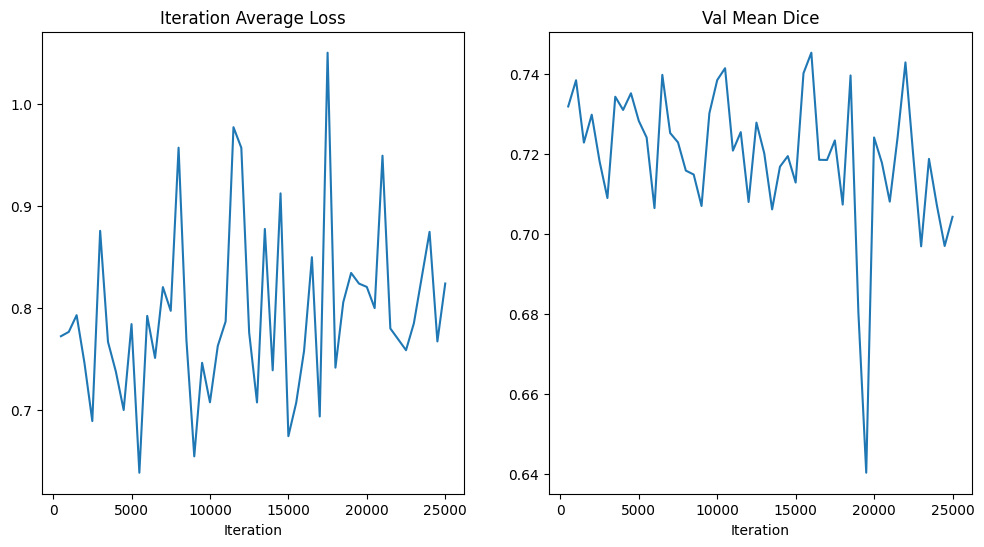

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
#fold4
torch.cuda.empty_cache()

In [5]:
#fold4
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_4.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.11it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [7]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1", "swinunetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold4_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [10]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_pretrainonwordfinetuneonmiccai_fold4_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=0.65331): 100%|█| 24/24 [00:23<00:00,  1.02it/
Training (47 / 25000 Steps) (loss=0.48362): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (71 / 25000 Steps) (loss=0.68116): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (95 / 25000 Steps) (loss=0.61494): 100%|█| 24/24 [00:18<00:00,  1.29it/
Training (119 / 25000 Steps) (loss=0.70613): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (143 / 25000 Steps) (loss=0.85359): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (167 / 25000 Steps) (loss=0.66450): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (191 / 25000 Steps) (loss=0.85965): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (215 / 25000 Steps) (loss=0.61178): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (239 / 25000 Steps) (loss=0.66712): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (263 / 25000 Steps) (loss=0.59067): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (287 / 25000 Steps) (loss=1.07605): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.7741009593009949 Current Avg. Dice: 0.7741009593009949


Training (503 / 25000 Steps) (loss=0.82324): 100%|█| 24/24 [00:31<00:00,  1.33s/
Training (527 / 25000 Steps) (loss=0.73584): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (551 / 25000 Steps) (loss=0.71002): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (575 / 25000 Steps) (loss=0.73932): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (599 / 25000 Steps) (loss=0.58569): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (623 / 25000 Steps) (loss=0.57258): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (647 / 25000 Steps) (loss=0.56202): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (671 / 25000 Steps) (loss=0.84034): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (695 / 25000 Steps) (loss=0.88554): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (719 / 25000 Steps) (loss=0.92968): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (743 / 25000 Steps) (loss=0.80764): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (767 / 25000 Steps) (loss=0.57574): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.7741009593009949 Current Avg. Dice: 0.7631168365478516


Training (1007 / 25000 Steps) (loss=0.39978): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (1031 / 25000 Steps) (loss=0.58932): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1055 / 25000 Steps) (loss=0.61776): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1079 / 25000 Steps) (loss=0.71379): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1103 / 25000 Steps) (loss=0.62422): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1127 / 25000 Steps) (loss=0.87970): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1151 / 25000 Steps) (loss=1.63475): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1175 / 25000 Steps) (loss=0.58690): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1199 / 25000 Steps) (loss=0.65067): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1223 / 25000 Steps) (loss=0.72615): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1247 / 25000 Steps) (loss=0.60680): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1271 / 25000 Steps) (loss=0.70612): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7742260098457336 Current Avg. Dice: 0.7742260098457336


Training (1511 / 25000 Steps) (loss=0.77786): 100%|█| 24/24 [00:30<00:00,  1.27s
Training (1535 / 25000 Steps) (loss=0.58424): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1559 / 25000 Steps) (loss=0.55784): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1583 / 25000 Steps) (loss=0.60295): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1607 / 25000 Steps) (loss=0.71560): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1631 / 25000 Steps) (loss=0.83644): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1655 / 25000 Steps) (loss=0.69905): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1679 / 25000 Steps) (loss=0.75946): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1703 / 25000 Steps) (loss=0.63950): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1727 / 25000 Steps) (loss=0.57690): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1751 / 25000 Steps) (loss=0.62711): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1775 / 25000 Steps) (loss=0.44683): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7742260098457336 Current Avg. Dice: 0.7532647252082825


Training (2015 / 25000 Steps) (loss=0.59900): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (2039 / 25000 Steps) (loss=0.72263): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2063 / 25000 Steps) (loss=0.59295): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2087 / 25000 Steps) (loss=0.77817): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2111 / 25000 Steps) (loss=0.65397): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2135 / 25000 Steps) (loss=0.84196): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2159 / 25000 Steps) (loss=0.67466): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2183 / 25000 Steps) (loss=0.65759): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2207 / 25000 Steps) (loss=0.65550): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (2231 / 25000 Steps) (loss=0.77288): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2255 / 25000 Steps) (loss=0.59073): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2279 / 25000 Steps) (loss=0.69304): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7742260098457336 Current Avg. Dice: 0.7269578576087952


Training (2519 / 25000 Steps) (loss=0.68807): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (2543 / 25000 Steps) (loss=0.49269): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2567 / 25000 Steps) (loss=0.67717): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2591 / 25000 Steps) (loss=0.58017): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2615 / 25000 Steps) (loss=1.30828): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2639 / 25000 Steps) (loss=0.63291): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2663 / 25000 Steps) (loss=0.59862): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2687 / 25000 Steps) (loss=1.07642): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2711 / 25000 Steps) (loss=0.68556): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2735 / 25000 Steps) (loss=0.66889): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2759 / 25000 Steps) (loss=0.71827): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2783 / 25000 Steps) (loss=0.85204): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7742260098457336 Current Avg. Dice: 0.7109179496765137


Training (3023 / 25000 Steps) (loss=0.68608): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (3047 / 25000 Steps) (loss=0.72049): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3071 / 25000 Steps) (loss=0.98439): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3095 / 25000 Steps) (loss=0.79626): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3119 / 25000 Steps) (loss=0.63991): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3143 / 25000 Steps) (loss=1.09404): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3167 / 25000 Steps) (loss=0.75214): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3191 / 25000 Steps) (loss=0.53487): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3215 / 25000 Steps) (loss=0.55910): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3239 / 25000 Steps) (loss=0.57499): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3263 / 25000 Steps) (loss=0.83607): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3287 / 25000 Steps) (loss=0.81336): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7742260098457336 Current Avg. Dice: 0.7420822978019714


Training (3503 / 25000 Steps) (loss=0.57881): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (3527 / 25000 Steps) (loss=0.67023): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3551 / 25000 Steps) (loss=0.68970): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3575 / 25000 Steps) (loss=0.69453): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3599 / 25000 Steps) (loss=0.61507): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3623 / 25000 Steps) (loss=0.73173): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3647 / 25000 Steps) (loss=0.56279): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3671 / 25000 Steps) (loss=1.33978): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3695 / 25000 Steps) (loss=0.78214): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3719 / 25000 Steps) (loss=1.12535): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3743 / 25000 Steps) (loss=0.72353): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3767 / 25000 Steps) (loss=0.57907): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7782747149467468 Current Avg. Dice: 0.7782747149467468


Training (4007 / 25000 Steps) (loss=0.82948): 100%|█| 24/24 [00:30<00:00,  1.27s
Training (4031 / 25000 Steps) (loss=1.09906): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4055 / 25000 Steps) (loss=0.66928): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4079 / 25000 Steps) (loss=0.80234): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4103 / 25000 Steps) (loss=0.54358): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4127 / 25000 Steps) (loss=0.70567): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4151 / 25000 Steps) (loss=0.64565): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4175 / 25000 Steps) (loss=2.21484): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4199 / 25000 Steps) (loss=0.73351): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4223 / 25000 Steps) (loss=0.79983): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4247 / 25000 Steps) (loss=0.69043): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4271 / 25000 Steps) (loss=0.54675): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7782747149467468 Current Avg. Dice: 0.7506031394004822


Training (4511 / 25000 Steps) (loss=1.05247): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (4535 / 25000 Steps) (loss=0.65072): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4559 / 25000 Steps) (loss=0.62547): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4583 / 25000 Steps) (loss=0.61808): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4607 / 25000 Steps) (loss=0.80313): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4631 / 25000 Steps) (loss=0.74348): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4655 / 25000 Steps) (loss=0.77243): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4679 / 25000 Steps) (loss=0.63201): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4703 / 25000 Steps) (loss=0.92002): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4727 / 25000 Steps) (loss=0.90536): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4751 / 25000 Steps) (loss=0.39973): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4775 / 25000 Steps) (loss=0.69827): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7782747149467468 Current Avg. Dice: 0.7567128539085388


Training (5015 / 25000 Steps) (loss=0.57169): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (5039 / 25000 Steps) (loss=0.69603): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5063 / 25000 Steps) (loss=0.48599): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5087 / 25000 Steps) (loss=1.36473): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5111 / 25000 Steps) (loss=0.74889): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5135 / 25000 Steps) (loss=0.82068): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5159 / 25000 Steps) (loss=0.67852): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5183 / 25000 Steps) (loss=0.77721): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5207 / 25000 Steps) (loss=0.61281): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5231 / 25000 Steps) (loss=0.72486): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5255 / 25000 Steps) (loss=0.63335): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5279 / 25000 Steps) (loss=0.65755): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7782747149467468 Current Avg. Dice: 0.7346086502075195


Training (5519 / 25000 Steps) (loss=0.76684): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (5543 / 25000 Steps) (loss=0.69841): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5567 / 25000 Steps) (loss=0.64443): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5591 / 25000 Steps) (loss=0.63896): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5615 / 25000 Steps) (loss=1.16745): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5639 / 25000 Steps) (loss=0.73946): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5663 / 25000 Steps) (loss=0.54327): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5687 / 25000 Steps) (loss=0.67515): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5711 / 25000 Steps) (loss=0.76884): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5735 / 25000 Steps) (loss=0.58073): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5759 / 25000 Steps) (loss=0.83652): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5783 / 25000 Steps) (loss=0.53889): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7782747149467468 Current Avg. Dice: 0.7154125571250916


Training (6023 / 25000 Steps) (loss=0.65115): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (6047 / 25000 Steps) (loss=0.52906): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6071 / 25000 Steps) (loss=0.64579): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6095 / 25000 Steps) (loss=0.99132): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6119 / 25000 Steps) (loss=0.62927): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6143 / 25000 Steps) (loss=0.98282): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6167 / 25000 Steps) (loss=0.76362): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6191 / 25000 Steps) (loss=0.75466): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6215 / 25000 Steps) (loss=1.00005): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6239 / 25000 Steps) (loss=0.73134): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6263 / 25000 Steps) (loss=0.79224): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6287 / 25000 Steps) (loss=0.53888): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7856438755989075


Training (6503 / 25000 Steps) (loss=0.85964): 100%|█| 24/24 [00:30<00:00,  1.28s
Training (6527 / 25000 Steps) (loss=0.77763): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6551 / 25000 Steps) (loss=0.79348): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6575 / 25000 Steps) (loss=0.65344): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6599 / 25000 Steps) (loss=0.51321): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6623 / 25000 Steps) (loss=0.79514): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6647 / 25000 Steps) (loss=0.41197): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6671 / 25000 Steps) (loss=0.62945): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6695 / 25000 Steps) (loss=0.86537): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6719 / 25000 Steps) (loss=0.81201): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6743 / 25000 Steps) (loss=0.63042): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6767 / 25000 Steps) (loss=0.72008): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7615528702735901


Training (7007 / 25000 Steps) (loss=0.68806): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (7031 / 25000 Steps) (loss=1.08202): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7055 / 25000 Steps) (loss=0.73941): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7079 / 25000 Steps) (loss=0.48347): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7103 / 25000 Steps) (loss=1.89536): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7127 / 25000 Steps) (loss=0.72825): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7151 / 25000 Steps) (loss=0.81855): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7175 / 25000 Steps) (loss=0.54214): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7199 / 25000 Steps) (loss=0.50686): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7223 / 25000 Steps) (loss=0.50673): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7247 / 25000 Steps) (loss=0.80658): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7271 / 25000 Steps) (loss=0.85820): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7511002421379089


Training (7511 / 25000 Steps) (loss=0.60044): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (7535 / 25000 Steps) (loss=0.69464): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7559 / 25000 Steps) (loss=0.77382): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7583 / 25000 Steps) (loss=0.49534): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7607 / 25000 Steps) (loss=1.61924): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7631 / 25000 Steps) (loss=0.55224): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7655 / 25000 Steps) (loss=1.14770): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7679 / 25000 Steps) (loss=0.91997): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7703 / 25000 Steps) (loss=0.68955): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7727 / 25000 Steps) (loss=0.75774): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7751 / 25000 Steps) (loss=0.78240): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7775 / 25000 Steps) (loss=0.97289): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7520753741264343


Training (8015 / 25000 Steps) (loss=0.64345): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (8039 / 25000 Steps) (loss=0.72261): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8063 / 25000 Steps) (loss=0.75905): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8087 / 25000 Steps) (loss=0.76802): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8111 / 25000 Steps) (loss=0.76450): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8135 / 25000 Steps) (loss=0.60233): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8159 / 25000 Steps) (loss=0.86749): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8183 / 25000 Steps) (loss=0.63741): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8207 / 25000 Steps) (loss=0.57284): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8231 / 25000 Steps) (loss=0.82359): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8255 / 25000 Steps) (loss=0.68259): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8279 / 25000 Steps) (loss=0.56360): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7375031113624573


Training (8519 / 25000 Steps) (loss=0.51202): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (8543 / 25000 Steps) (loss=0.68885): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8567 / 25000 Steps) (loss=0.73379): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8591 / 25000 Steps) (loss=0.93166): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8615 / 25000 Steps) (loss=0.72418): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8639 / 25000 Steps) (loss=0.68072): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8663 / 25000 Steps) (loss=0.63692): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8687 / 25000 Steps) (loss=0.72869): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8711 / 25000 Steps) (loss=0.59367): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8735 / 25000 Steps) (loss=0.47053): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8759 / 25000 Steps) (loss=0.73490): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8783 / 25000 Steps) (loss=1.73516): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7149064540863037


Training (9023 / 25000 Steps) (loss=0.75496): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (9047 / 25000 Steps) (loss=0.64593): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9071 / 25000 Steps) (loss=0.63555): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9095 / 25000 Steps) (loss=0.55606): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9119 / 25000 Steps) (loss=0.79925): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9143 / 25000 Steps) (loss=0.65657): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9167 / 25000 Steps) (loss=0.81805): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9191 / 25000 Steps) (loss=0.73978): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (9215 / 25000 Steps) (loss=0.72641): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9239 / 25000 Steps) (loss=0.70594): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9263 / 25000 Steps) (loss=0.79970): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9287 / 25000 Steps) (loss=0.78626): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7758195400238037


Training (9503 / 25000 Steps) (loss=0.80406): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (9527 / 25000 Steps) (loss=0.75242): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9551 / 25000 Steps) (loss=0.70359): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9575 / 25000 Steps) (loss=0.48368): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9599 / 25000 Steps) (loss=0.89169): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9623 / 25000 Steps) (loss=0.68306): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9647 / 25000 Steps) (loss=0.75102): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9671 / 25000 Steps) (loss=0.78584): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9695 / 25000 Steps) (loss=0.84755): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9719 / 25000 Steps) (loss=0.62385): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9743 / 25000 Steps) (loss=0.47912): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9767 / 25000 Steps) (loss=0.54247): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7617117762565613


Training (10007 / 25000 Steps) (loss=0.76593): 100%|█| 24/24 [00:30<00:00,  1.26
Training (10031 / 25000 Steps) (loss=0.63682): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10055 / 25000 Steps) (loss=1.48396): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10079 / 25000 Steps) (loss=0.72802): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10103 / 25000 Steps) (loss=0.58574): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10127 / 25000 Steps) (loss=0.77428): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10151 / 25000 Steps) (loss=0.64151): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10175 / 25000 Steps) (loss=0.80147): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10199 / 25000 Steps) (loss=0.81339): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10223 / 25000 Steps) (loss=0.63844): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10247 / 25000 Steps) (loss=0.72350): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10271 / 25000 Steps) (loss=0.68290): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7532423138618469


Training (10511 / 25000 Steps) (loss=0.73980): 100%|█| 24/24 [00:30<00:00,  1.26
Training (10535 / 25000 Steps) (loss=1.20143): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10559 / 25000 Steps) (loss=0.64970): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10583 / 25000 Steps) (loss=0.81560): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10607 / 25000 Steps) (loss=0.86498): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10631 / 25000 Steps) (loss=0.88444): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10655 / 25000 Steps) (loss=1.09886): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10679 / 25000 Steps) (loss=0.92101): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10703 / 25000 Steps) (loss=0.89744): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10727 / 25000 Steps) (loss=0.75715): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10751 / 25000 Steps) (loss=0.71583): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10775 / 25000 Steps) (loss=0.65350): 100%|█| 24/24 [00:18<00:00,  1.28
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7221702933311462


Training (11015 / 25000 Steps) (loss=0.64658): 100%|█| 24/24 [00:30<00:00,  1.26
Training (11039 / 25000 Steps) (loss=0.48353): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11063 / 25000 Steps) (loss=0.76317): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11087 / 25000 Steps) (loss=0.53420): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11111 / 25000 Steps) (loss=1.08959): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11135 / 25000 Steps) (loss=0.69125): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11159 / 25000 Steps) (loss=0.55468): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11183 / 25000 Steps) (loss=0.63365): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11207 / 25000 Steps) (loss=0.89798): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11231 / 25000 Steps) (loss=0.68680): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11255 / 25000 Steps) (loss=0.88506): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11279 / 25000 Steps) (loss=0.83539): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7125635743141174


Training (11519 / 25000 Steps) (loss=0.54601): 100%|█| 24/24 [00:30<00:00,  1.26
Training (11543 / 25000 Steps) (loss=0.67360): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11567 / 25000 Steps) (loss=0.75325): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11591 / 25000 Steps) (loss=1.12011): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11615 / 25000 Steps) (loss=0.97578): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11639 / 25000 Steps) (loss=0.47405): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11663 / 25000 Steps) (loss=0.60947): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11687 / 25000 Steps) (loss=0.63083): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11711 / 25000 Steps) (loss=0.65857): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11735 / 25000 Steps) (loss=0.72012): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11759 / 25000 Steps) (loss=0.81109): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11783 / 25000 Steps) (loss=0.67599): 100%|█| 24/24 [00:18<00:00,  1.28
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7088212966918945


Training (12023 / 25000 Steps) (loss=0.76450): 100%|█| 24/24 [00:30<00:00,  1.26
Training (12047 / 25000 Steps) (loss=0.71881): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12071 / 25000 Steps) (loss=0.78178): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12095 / 25000 Steps) (loss=1.88069): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12119 / 25000 Steps) (loss=0.79930): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12143 / 25000 Steps) (loss=0.70386): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12167 / 25000 Steps) (loss=0.74262): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12191 / 25000 Steps) (loss=0.68934): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12215 / 25000 Steps) (loss=0.62463): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12239 / 25000 Steps) (loss=0.67953): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12263 / 25000 Steps) (loss=0.95708): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12287 / 25000 Steps) (loss=0.57735): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.750909149646759


Training (12503 / 25000 Steps) (loss=0.95516): 100%|█| 24/24 [00:30<00:00,  1.26
Training (12527 / 25000 Steps) (loss=0.83095): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12551 / 25000 Steps) (loss=0.79674): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12575 / 25000 Steps) (loss=0.51391): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12599 / 25000 Steps) (loss=0.74940): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12623 / 25000 Steps) (loss=0.62778): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12647 / 25000 Steps) (loss=0.66530): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12671 / 25000 Steps) (loss=0.49702): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12695 / 25000 Steps) (loss=0.90597): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12719 / 25000 Steps) (loss=0.64505): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12743 / 25000 Steps) (loss=0.70185): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12767 / 25000 Steps) (loss=0.53958): 100%|█| 24/24 [00:18<00:00,  1.28
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7793306708335876


Training (13007 / 25000 Steps) (loss=0.64555): 100%|█| 24/24 [00:30<00:00,  1.26
Training (13031 / 25000 Steps) (loss=0.58669): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13055 / 25000 Steps) (loss=0.84949): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13079 / 25000 Steps) (loss=0.65429): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13103 / 25000 Steps) (loss=0.84966): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13127 / 25000 Steps) (loss=0.55310): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13151 / 25000 Steps) (loss=1.00676): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13175 / 25000 Steps) (loss=0.70511): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13199 / 25000 Steps) (loss=0.71450): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13223 / 25000 Steps) (loss=1.02828): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13247 / 25000 Steps) (loss=0.63475): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13271 / 25000 Steps) (loss=0.77033): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7580937743186951


Training (13511 / 25000 Steps) (loss=0.52313): 100%|█| 24/24 [00:30<00:00,  1.26
Training (13535 / 25000 Steps) (loss=0.80264): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13559 / 25000 Steps) (loss=0.74784): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13583 / 25000 Steps) (loss=0.53738): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13607 / 25000 Steps) (loss=0.69907): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13631 / 25000 Steps) (loss=0.81895): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13655 / 25000 Steps) (loss=0.74332): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13679 / 25000 Steps) (loss=0.84527): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13703 / 25000 Steps) (loss=0.79679): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13727 / 25000 Steps) (loss=0.80768): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13751 / 25000 Steps) (loss=0.76323): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13775 / 25000 Steps) (loss=0.62093): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.766251266002655


Training (14015 / 25000 Steps) (loss=0.56376): 100%|█| 24/24 [00:30<00:00,  1.26
Training (14039 / 25000 Steps) (loss=1.10595): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14063 / 25000 Steps) (loss=0.72639): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14087 / 25000 Steps) (loss=0.55371): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14111 / 25000 Steps) (loss=0.70161): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14135 / 25000 Steps) (loss=0.84369): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14159 / 25000 Steps) (loss=0.48952): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14183 / 25000 Steps) (loss=0.69020): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14207 / 25000 Steps) (loss=0.57791): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14231 / 25000 Steps) (loss=0.59183): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14255 / 25000 Steps) (loss=0.77228): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14279 / 25000 Steps) (loss=0.51052): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7158376574516296


Training (14519 / 25000 Steps) (loss=0.69527): 100%|█| 24/24 [00:30<00:00,  1.26
Training (14543 / 25000 Steps) (loss=0.58823): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14567 / 25000 Steps) (loss=1.50221): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14591 / 25000 Steps) (loss=0.81536): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14615 / 25000 Steps) (loss=0.71761): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14639 / 25000 Steps) (loss=0.64924): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14663 / 25000 Steps) (loss=0.68916): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14687 / 25000 Steps) (loss=0.67505): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14711 / 25000 Steps) (loss=0.77746): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14735 / 25000 Steps) (loss=1.33461): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14759 / 25000 Steps) (loss=0.81797): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14783 / 25000 Steps) (loss=0.54190): 100%|█| 24/24 [00:18<00:00,  1.28
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.7110348343849182


Training (15023 / 25000 Steps) (loss=0.69595): 100%|█| 24/24 [00:30<00:00,  1.26
Training (15047 / 25000 Steps) (loss=0.75032): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15071 / 25000 Steps) (loss=0.69679): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15095 / 25000 Steps) (loss=0.54159): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15119 / 25000 Steps) (loss=0.74720): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15143 / 25000 Steps) (loss=0.80334): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15167 / 25000 Steps) (loss=0.66509): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15191 / 25000 Steps) (loss=0.79922): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15215 / 25000 Steps) (loss=0.61531): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15239 / 25000 Steps) (loss=0.53702): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15263 / 25000 Steps) (loss=0.84568): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15287 / 25000 Steps) (loss=0.79318): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7856438755989075 Current Avg. Dice: 0.751796543598175


Training (15503 / 25000 Steps) (loss=0.48052): 100%|█| 24/24 [00:30<00:00,  1.26
Training (15527 / 25000 Steps) (loss=0.45155): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15551 / 25000 Steps) (loss=0.73596): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15575 / 25000 Steps) (loss=0.69054): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15599 / 25000 Steps) (loss=0.72190): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15623 / 25000 Steps) (loss=0.82805): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15647 / 25000 Steps) (loss=0.90007): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15671 / 25000 Steps) (loss=0.84151): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15695 / 25000 Steps) (loss=0.67624): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15719 / 25000 Steps) (loss=0.66622): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15743 / 25000 Steps) (loss=0.77180): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15767 / 25000 Steps) (loss=0.56606): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7883181571960449 Current Avg. Dice: 0.7883181571960449


Training (16007 / 25000 Steps) (loss=0.80762): 100%|█| 24/24 [00:30<00:00,  1.27
Training (16031 / 25000 Steps) (loss=0.51994): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16055 / 25000 Steps) (loss=1.06785): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16079 / 25000 Steps) (loss=0.76791): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16103 / 25000 Steps) (loss=0.91635): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16127 / 25000 Steps) (loss=0.52359): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16151 / 25000 Steps) (loss=0.82307): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16175 / 25000 Steps) (loss=1.13140): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16199 / 25000 Steps) (loss=1.11216): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16223 / 25000 Steps) (loss=0.67265): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16247 / 25000 Steps) (loss=0.59531): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16271 / 25000 Steps) (loss=0.54759): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7883181571960449 Current Avg. Dice: 0.7627052664756775


Training (16511 / 25000 Steps) (loss=0.45610): 100%|█| 24/24 [00:30<00:00,  1.26
Training (16535 / 25000 Steps) (loss=0.47590): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16559 / 25000 Steps) (loss=0.82395): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16583 / 25000 Steps) (loss=0.88617): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16607 / 25000 Steps) (loss=0.73360): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16631 / 25000 Steps) (loss=0.56334): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16655 / 25000 Steps) (loss=0.72377): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16679 / 25000 Steps) (loss=0.70656): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16703 / 25000 Steps) (loss=0.48967): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16727 / 25000 Steps) (loss=0.74957): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16751 / 25000 Steps) (loss=0.72303): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16775 / 25000 Steps) (loss=0.74840): 100%|█| 24/24 [00:18<00:00,  1.28
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7883181571960449 Current Avg. Dice: 0.7714440226554871


Training (17015 / 25000 Steps) (loss=0.75300): 100%|█| 24/24 [00:30<00:00,  1.26
Training (17039 / 25000 Steps) (loss=0.73895): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17063 / 25000 Steps) (loss=0.80004): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17087 / 25000 Steps) (loss=0.59762): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17111 / 25000 Steps) (loss=1.52637): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17135 / 25000 Steps) (loss=0.82672): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17159 / 25000 Steps) (loss=0.70266): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17183 / 25000 Steps) (loss=0.74805): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17207 / 25000 Steps) (loss=0.58313): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17231 / 25000 Steps) (loss=0.95370): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17255 / 25000 Steps) (loss=0.76156): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17279 / 25000 Steps) (loss=0.83717): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7883181571960449 Current Avg. Dice: 0.7508617043495178


Training (17519 / 25000 Steps) (loss=0.71191): 100%|█| 24/24 [00:30<00:00,  1.26
Training (17543 / 25000 Steps) (loss=0.80390): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17567 / 25000 Steps) (loss=0.86845): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17591 / 25000 Steps) (loss=0.68492): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17615 / 25000 Steps) (loss=0.52253): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17639 / 25000 Steps) (loss=0.86699): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17663 / 25000 Steps) (loss=0.65567): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17687 / 25000 Steps) (loss=0.76056): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17711 / 25000 Steps) (loss=0.58217): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17735 / 25000 Steps) (loss=0.69809): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17759 / 25000 Steps) (loss=0.74287): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17783 / 25000 Steps) (loss=0.77091): 100%|█| 24/24 [00:18<00:00,  1.28
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7883181571960449 Current Avg. Dice: 0.7151349186897278


Training (18023 / 25000 Steps) (loss=0.73068): 100%|█| 24/24 [00:30<00:00,  1.26
Training (18047 / 25000 Steps) (loss=0.58445): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18071 / 25000 Steps) (loss=0.67872): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18095 / 25000 Steps) (loss=0.67721): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18119 / 25000 Steps) (loss=0.76736): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18143 / 25000 Steps) (loss=0.84097): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18167 / 25000 Steps) (loss=0.76262): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18191 / 25000 Steps) (loss=1.20577): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18215 / 25000 Steps) (loss=0.69451): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18239 / 25000 Steps) (loss=0.95511): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18263 / 25000 Steps) (loss=0.76214): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18287 / 25000 Steps) (loss=0.48309): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7883181571960449 Current Avg. Dice: 0.7748024463653564


Training (18503 / 25000 Steps) (loss=0.82090): 100%|█| 24/24 [00:30<00:00,  1.26
Training (18527 / 25000 Steps) (loss=0.57433): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18551 / 25000 Steps) (loss=0.71692): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18575 / 25000 Steps) (loss=0.55178): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18599 / 25000 Steps) (loss=0.68899): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18623 / 25000 Steps) (loss=0.77288): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18647 / 25000 Steps) (loss=1.86040): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18671 / 25000 Steps) (loss=0.58357): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18695 / 25000 Steps) (loss=0.60586): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18719 / 25000 Steps) (loss=0.66135): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18743 / 25000 Steps) (loss=0.72692): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18767 / 25000 Steps) (loss=0.74422): 100%|█| 24/24 [00:18<00:00,  1.28
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7883181571960449 Current Avg. Dice: 0.7739064693450928


Training (19007 / 25000 Steps) (loss=0.75809): 100%|█| 24/24 [00:30<00:00,  1.26
Training (19031 / 25000 Steps) (loss=0.44825): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19055 / 25000 Steps) (loss=0.72250): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19079 / 25000 Steps) (loss=0.93982): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19103 / 25000 Steps) (loss=0.82403): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19127 / 25000 Steps) (loss=0.72232): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19151 / 25000 Steps) (loss=0.62209): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19175 / 25000 Steps) (loss=0.64337): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19199 / 25000 Steps) (loss=0.42021): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19223 / 25000 Steps) (loss=0.74551): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19247 / 25000 Steps) (loss=0.62840): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19271 / 25000 Steps) (loss=0.78352): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7883181571960449 Current Avg. Dice: 0.75995272397995


Training (19511 / 25000 Steps) (loss=0.93250): 100%|█| 24/24 [00:30<00:00,  1.26
Training (19535 / 25000 Steps) (loss=0.61627): 100%|█| 24/24 [00:19<00:00,  1.25
Training (19559 / 25000 Steps) (loss=1.12734): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19583 / 25000 Steps) (loss=1.05089): 100%|█| 24/24 [00:18<00:00,  1.27
Training (19607 / 25000 Steps) (loss=0.67484): 100%|█| 24/24 [00:18<00:00,  1.27
Training (19631 / 25000 Steps) (loss=0.72980): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19655 / 25000 Steps) (loss=0.73968): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19679 / 25000 Steps) (loss=0.74923): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19703 / 25000 Steps) (loss=0.68766): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19727 / 25000 Steps) (loss=0.72261): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19751 / 25000 Steps) (loss=0.66427): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19775 / 25000 Steps) (loss=1.00474): 100%|█| 24/24 [00:18<00:00,  1.28
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7883181571960449 Current Avg. Dice: 0.7471097111701965


Training (20015 / 25000 Steps) (loss=0.60109): 100%|█| 24/24 [00:30<00:00,  1.27
Training (20039 / 25000 Steps) (loss=0.54807): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20063 / 25000 Steps) (loss=0.73933): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20087 / 25000 Steps) (loss=0.62748): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20111 / 25000 Steps) (loss=0.78741): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20135 / 25000 Steps) (loss=0.60634): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20159 / 25000 Steps) (loss=0.62334): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20183 / 25000 Steps) (loss=0.76523): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20207 / 25000 Steps) (loss=0.71190): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20231 / 25000 Steps) (loss=0.63263): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20255 / 25000 Steps) (loss=0.50913): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20279 / 25000 Steps) (loss=0.54878): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7883181571960449 Current Avg. Dice: 0.7222240567207336


Training (20519 / 25000 Steps) (loss=0.83234): 100%|█| 24/24 [00:30<00:00,  1.27
Training (20543 / 25000 Steps) (loss=0.72499): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20567 / 25000 Steps) (loss=0.73245): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20591 / 25000 Steps) (loss=0.68883): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20615 / 25000 Steps) (loss=0.67507): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20639 / 25000 Steps) (loss=0.63118): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20663 / 25000 Steps) (loss=0.82823): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20687 / 25000 Steps) (loss=0.79174): 100%|█| 24/24 [00:18<00:00,  1.27
Training (20711 / 25000 Steps) (loss=0.70839): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20735 / 25000 Steps) (loss=0.78523): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20759 / 25000 Steps) (loss=0.78026): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20783 / 25000 Steps) (loss=0.61053): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7883181571960449 Current Avg. Dice: 0.7163105010986328


Training (21023 / 25000 Steps) (loss=0.96538): 100%|█| 24/24 [00:30<00:00,  1.26
Training (21047 / 25000 Steps) (loss=0.75028): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21071 / 25000 Steps) (loss=0.76020): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21095 / 25000 Steps) (loss=0.63428): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21119 / 25000 Steps) (loss=0.73509): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21143 / 25000 Steps) (loss=0.54754): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21167 / 25000 Steps) (loss=0.70154): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21191 / 25000 Steps) (loss=0.77611): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21215 / 25000 Steps) (loss=1.12822): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21239 / 25000 Steps) (loss=0.58304): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21263 / 25000 Steps) (loss=0.73276): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21287 / 25000 Steps) (loss=0.70222): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7911542057991028 Current Avg. Dice: 0.7911542057991028


Training (21503 / 25000 Steps) (loss=0.74329): 100%|█| 24/24 [00:30<00:00,  1.28
Training (21527 / 25000 Steps) (loss=0.80114): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21551 / 25000 Steps) (loss=0.73711): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21575 / 25000 Steps) (loss=0.62160): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21599 / 25000 Steps) (loss=0.61321): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21623 / 25000 Steps) (loss=0.59733): 100%|█| 24/24 [00:18<00:00,  1.27
Training (21647 / 25000 Steps) (loss=0.66084): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21671 / 25000 Steps) (loss=0.80156): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21695 / 25000 Steps) (loss=0.83280): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21719 / 25000 Steps) (loss=0.61866): 100%|█| 24/24 [00:18<00:00,  1.27
Training (21743 / 25000 Steps) (loss=0.78385): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21767 / 25000 Steps) (loss=0.64218): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7911542057991028 Current Avg. Dice: 0.7512324452400208


Training (22007 / 25000 Steps) (loss=0.75489): 100%|█| 24/24 [00:30<00:00,  1.27
Training (22031 / 25000 Steps) (loss=0.74655): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22055 / 25000 Steps) (loss=0.73606): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22079 / 25000 Steps) (loss=0.96962): 100%|█| 24/24 [00:18<00:00,  1.27
Training (22103 / 25000 Steps) (loss=0.73526): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22127 / 25000 Steps) (loss=0.94450): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22151 / 25000 Steps) (loss=0.54396): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22175 / 25000 Steps) (loss=0.57931): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22199 / 25000 Steps) (loss=0.74779): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22223 / 25000 Steps) (loss=0.72204): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22247 / 25000 Steps) (loss=0.61160): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22271 / 25000 Steps) (loss=0.71858): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7911542057991028 Current Avg. Dice: 0.7477807998657227


Training (22511 / 25000 Steps) (loss=0.85379): 100%|█| 24/24 [00:30<00:00,  1.27
Training (22535 / 25000 Steps) (loss=0.79490): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22559 / 25000 Steps) (loss=1.93425): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22583 / 25000 Steps) (loss=0.99334): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22607 / 25000 Steps) (loss=0.54284): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22631 / 25000 Steps) (loss=0.75143): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22655 / 25000 Steps) (loss=0.65442): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22679 / 25000 Steps) (loss=0.90024): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22703 / 25000 Steps) (loss=0.61440): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22727 / 25000 Steps) (loss=0.68436): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22751 / 25000 Steps) (loss=0.79478): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22775 / 25000 Steps) (loss=0.79879): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7911542057991028 Current Avg. Dice: 0.7510760426521301


Training (23015 / 25000 Steps) (loss=0.66393): 100%|█| 24/24 [00:30<00:00,  1.27
Training (23039 / 25000 Steps) (loss=0.82760): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23063 / 25000 Steps) (loss=0.65339): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23087 / 25000 Steps) (loss=0.61592): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23111 / 25000 Steps) (loss=0.51567): 100%|█| 24/24 [00:18<00:00,  1.27
Training (23135 / 25000 Steps) (loss=0.70495): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23159 / 25000 Steps) (loss=0.61550): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23183 / 25000 Steps) (loss=0.74844): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23207 / 25000 Steps) (loss=0.82233): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23231 / 25000 Steps) (loss=0.62797): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23255 / 25000 Steps) (loss=0.62473): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23279 / 25000 Steps) (loss=0.58957): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7911542057991028 Current Avg. Dice: 0.733156681060791


Training (23519 / 25000 Steps) (loss=0.67773): 100%|█| 24/24 [00:30<00:00,  1.27
Training (23543 / 25000 Steps) (loss=0.74943): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23567 / 25000 Steps) (loss=0.62813): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23591 / 25000 Steps) (loss=0.82010): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23615 / 25000 Steps) (loss=0.53196): 100%|█| 24/24 [00:18<00:00,  1.27
Training (23639 / 25000 Steps) (loss=1.28883): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23663 / 25000 Steps) (loss=0.64134): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23687 / 25000 Steps) (loss=0.85138): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23711 / 25000 Steps) (loss=0.76358): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23735 / 25000 Steps) (loss=0.79616): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23759 / 25000 Steps) (loss=0.97532): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23783 / 25000 Steps) (loss=0.58418): 100%|█| 24/24 [00:18<00:00,  1.28
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7911542057991028 Current Avg. Dice: 0.7167448997497559


Training (24023 / 25000 Steps) (loss=0.72720): 100%|█| 24/24 [00:30<00:00,  1.27
Training (24047 / 25000 Steps) (loss=0.84583): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24071 / 25000 Steps) (loss=0.96966): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24095 / 25000 Steps) (loss=0.61281): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24119 / 25000 Steps) (loss=1.23536): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24143 / 25000 Steps) (loss=0.77004): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24167 / 25000 Steps) (loss=0.59634): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24191 / 25000 Steps) (loss=0.95279): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24215 / 25000 Steps) (loss=0.67372): 100%|█| 24/24 [00:18<00:00,  1.27
Training (24239 / 25000 Steps) (loss=0.68946): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24263 / 25000 Steps) (loss=0.71748): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24287 / 25000 Steps) (loss=0.49620): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7911542057991028 Current Avg. Dice: 0.7079575657844543


Training (24503 / 25000 Steps) (loss=0.71767): 100%|█| 24/24 [00:30<00:00,  1.27
Training (24527 / 25000 Steps) (loss=0.57001): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24551 / 25000 Steps) (loss=0.86364): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24575 / 25000 Steps) (loss=0.90464): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24599 / 25000 Steps) (loss=0.88479): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24623 / 25000 Steps) (loss=0.74738): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24647 / 25000 Steps) (loss=0.64544): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24671 / 25000 Steps) (loss=0.63983): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24695 / 25000 Steps) (loss=0.73713): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24719 / 25000 Steps) (loss=0.59994): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24743 / 25000 Steps) (loss=0.69933): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24767 / 25000 Steps) (loss=0.69575): 100%|█| 24/24 [00:18<00:00,  1.28
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7911542057991028 Current Avg. Dice: 0.760068416595459


Training (25007 / 25000 Steps) (loss=0.75941): 100%|█| 24/24 [00:30<00:00,  1.27


<All keys matched successfully>

In [11]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7912 at iteration: 21500


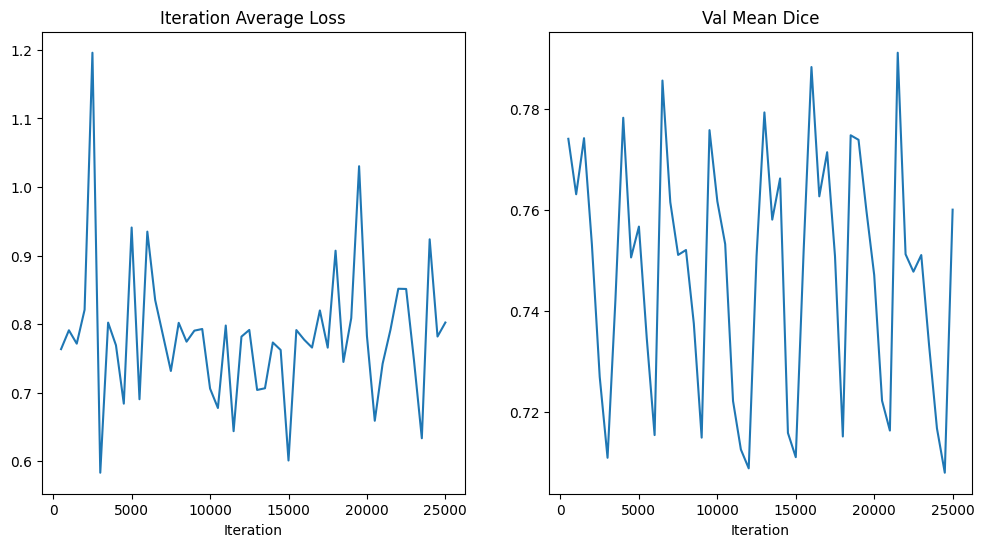

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()